In [1]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.unfolding_flow import UnfoldingFlow

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import yaml

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [78]:
conf = {
    "input_shape": {
        "number_jets": 16,
        "number_lept": 1,
        "input_features": 5
    },
    "conditioning_transformer": {
        "out_features": 3,
        "hidden_features": 128,
        "dim_feedforward_transformer": 512,
        "nhead_encoder": 8,
        "no_layers_encoder": 2,
        "nhead_decoder": 8,
        "no_layers_decoder": 2,
        "aggregate": False,
        "no_decoders": 3
    },
    "unfolding_flow": {
        "nfeatures": 10,
        "ncond": 10,
        "ntransforms": 4,
        "hiddenMLP_NoLayers": 16,
        "hiddenMLP_LayerDim": 16,
        "bins": 16,
        "autoregressive": False
    }
}
#conf = yaml.dump(conf)
path_to_model = "results_pretraining_eta_correct_21June/withProv/preTraining-MEMFlow-eta_v0_v0/model_preTraining-MEMFlow-eta_v0_v0.pt"

In [79]:
print(conf["input_shape"]["number_lept"])

1


In [80]:
# Initialize model
model = UnfoldingFlow(model_path=path_to_model,
                    log_mean = [1,1],
                    log_std = [1,1],
                    no_jets=conf["input_shape"]["number_jets"],
                    no_lept=conf["input_shape"]["number_lept"],
                    input_features=conf["input_shape"]["input_features"],
                    cond_hiddenFeatures=conf["conditioning_transformer"]["hidden_features"],
                    cond_dimFeedForward=conf["conditioning_transformer"]["dim_feedforward_transformer"],
                    cond_outFeatures=conf["conditioning_transformer"]["out_features"],
                    cond_nheadEncoder=conf["conditioning_transformer"]["nhead_encoder"],
                    cond_NoLayersEncoder=conf["conditioning_transformer"]["no_layers_encoder"],
                    cond_nheadDecoder=conf["conditioning_transformer"]["nhead_decoder"],
                    cond_NoLayersDecoder=conf["conditioning_transformer"]["no_layers_decoder"],
                    cond_NoDecoders=conf["conditioning_transformer"]["no_decoders"],
                    cond_aggregate=conf["conditioning_transformer"]["aggregate"],
                    flow_nfeatures=conf["unfolding_flow"]["nfeatures"],
                    flow_ncond=conf["unfolding_flow"]["ncond"], 
                    flow_ntransforms=conf["unfolding_flow"]["ntransforms"],
                    flow_hiddenMLP_NoLayers=conf["unfolding_flow"]["hiddenMLP_NoLayers"], 
                    flow_hiddenMLP_LayerDim=conf["unfolding_flow"]["hiddenMLP_LayerDim"],
                    flow_bins=conf["unfolding_flow"]["bins"],
                    flow_autoregressive=conf["unfolding_flow"]["autoregressive"])

In [81]:
print(f"parameters total:{count_parameters(model)}")

parameters total:1638378


# 1. No of params based on no. of bins

In [82]:
no_bins = [16,32,64,128,256,512,1024,2048]
no_bins_params = []
for i in range(len(no_bins)):
    model = UnfoldingFlow(model_path=path_to_model,
                    log_mean = [1,1],
                    log_std = [1,1],
                    no_jets=conf["input_shape"]["number_jets"],
                    no_lept=conf["input_shape"]["number_lept"],
                    input_features=conf["input_shape"]["input_features"],
                    cond_hiddenFeatures=conf["conditioning_transformer"]["hidden_features"],
                    cond_dimFeedForward=conf["conditioning_transformer"]["dim_feedforward_transformer"],
                    cond_outFeatures=conf["conditioning_transformer"]["out_features"],
                    cond_nheadEncoder=conf["conditioning_transformer"]["nhead_encoder"],
                    cond_NoLayersEncoder=conf["conditioning_transformer"]["no_layers_encoder"],
                    cond_nheadDecoder=conf["conditioning_transformer"]["nhead_decoder"],
                    cond_NoLayersDecoder=conf["conditioning_transformer"]["no_layers_decoder"],
                    cond_NoDecoders=conf["conditioning_transformer"]["no_decoders"],
                    cond_aggregate=conf["conditioning_transformer"]["aggregate"],
                    flow_nfeatures=conf["unfolding_flow"]["nfeatures"],
                    flow_ncond=conf["unfolding_flow"]["ncond"], 
                    flow_ntransforms=conf["unfolding_flow"]["ntransforms"],
                    flow_hiddenMLP_NoLayers=conf["unfolding_flow"]["hiddenMLP_NoLayers"], 
                    flow_hiddenMLP_LayerDim=conf["unfolding_flow"]["hiddenMLP_LayerDim"],
                    flow_bins=no_bins[i],
                    flow_autoregressive=conf["unfolding_flow"]["autoregressive"])
    no_bins_params.append(count_parameters(model))


[1638378, 1671018, 1736298, 1866858, 2127978, 2650218, 3694698, 5783658]


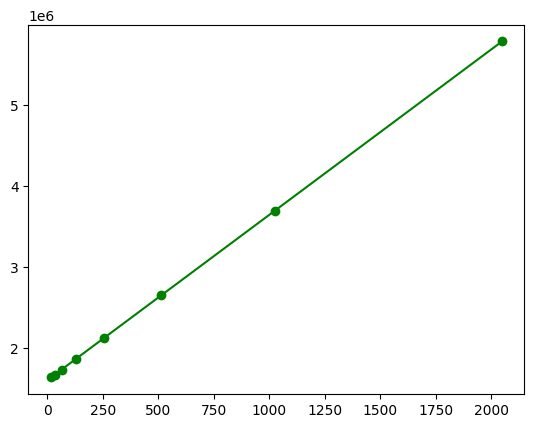

In [83]:
print(no_bins_params)
plt.plot(no_bins, no_bins_params, 'go-')

# 2. No of params based on no. of transf

In [84]:
no_transf = [4,6,8,10,14,18,22,30]
no_transf_params = []
for i in range(len(no_transf)):
    model = UnfoldingFlow(model_path=path_to_model,
                    log_mean = [1,1],
                    log_std = [1,1],
                    no_jets=conf["input_shape"]["number_jets"],
                    no_lept=conf["input_shape"]["number_lept"],
                    input_features=conf["input_shape"]["input_features"],
                    cond_hiddenFeatures=conf["conditioning_transformer"]["hidden_features"],
                    cond_dimFeedForward=conf["conditioning_transformer"]["dim_feedforward_transformer"],
                    cond_outFeatures=conf["conditioning_transformer"]["out_features"],
                    cond_nheadEncoder=conf["conditioning_transformer"]["nhead_encoder"],
                    cond_NoLayersEncoder=conf["conditioning_transformer"]["no_layers_encoder"],
                    cond_nheadDecoder=conf["conditioning_transformer"]["nhead_decoder"],
                    cond_NoLayersDecoder=conf["conditioning_transformer"]["no_layers_decoder"],
                    cond_NoDecoders=conf["conditioning_transformer"]["no_decoders"],
                    cond_aggregate=conf["conditioning_transformer"]["aggregate"],
                    flow_nfeatures=conf["unfolding_flow"]["nfeatures"],
                    flow_ncond=conf["unfolding_flow"]["ncond"], 
                    flow_ntransforms=no_transf[i],
                    flow_hiddenMLP_NoLayers=conf["unfolding_flow"]["hiddenMLP_NoLayers"], 
                    flow_hiddenMLP_LayerDim=conf["unfolding_flow"]["hiddenMLP_LayerDim"],
                    flow_bins=conf["unfolding_flow"]["bins"],
                    flow_autoregressive=conf["unfolding_flow"]["autoregressive"])
    no_transf_params.append(count_parameters(model))

[1638378, 1663190, 1688002, 1712814, 1762438, 1812062, 1861686, 1960934]


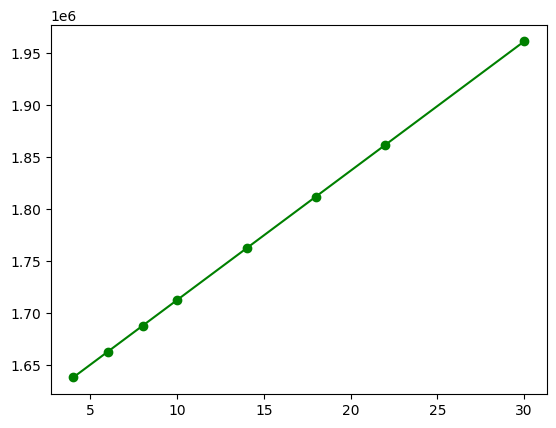

In [85]:
print(no_transf_params)
plt.plot(no_transf, no_transf_params, 'go-')

# 3. No params based on no. of no_layers

In [86]:
no_layers = [16,32,64,128,256,512,1024,2048]
no_layers_params = []
for i in range(len(no_layers)):
    model = UnfoldingFlow(model_path=path_to_model,
                    log_mean = [1,1],
                    log_std = [1,1],
                    no_jets=conf["input_shape"]["number_jets"],
                    no_lept=conf["input_shape"]["number_lept"],
                    input_features=conf["input_shape"]["input_features"],
                    cond_hiddenFeatures=conf["conditioning_transformer"]["hidden_features"],
                    cond_dimFeedForward=conf["conditioning_transformer"]["dim_feedforward_transformer"],
                    cond_outFeatures=conf["conditioning_transformer"]["out_features"],
                    cond_nheadEncoder=conf["conditioning_transformer"]["nhead_encoder"],
                    cond_NoLayersEncoder=conf["conditioning_transformer"]["no_layers_encoder"],
                    cond_nheadDecoder=conf["conditioning_transformer"]["nhead_decoder"],
                    cond_NoLayersDecoder=conf["conditioning_transformer"]["no_layers_decoder"],
                    cond_NoDecoders=conf["conditioning_transformer"]["no_decoders"],
                    cond_aggregate=conf["conditioning_transformer"]["aggregate"],
                    flow_nfeatures=conf["unfolding_flow"]["nfeatures"],
                    flow_ncond=conf["unfolding_flow"]["ncond"], 
                    flow_ntransforms=conf["unfolding_flow"]["ntransforms"],
                    flow_hiddenMLP_NoLayers=no_layers[i], 
                    flow_hiddenMLP_LayerDim=conf["unfolding_flow"]["hiddenMLP_LayerDim"],
                    flow_bins=conf["unfolding_flow"]["bins"],
                    flow_autoregressive=conf["unfolding_flow"]["autoregressive"])
    no_layers_params.append(count_parameters(model))


[1638378, 1655786, 1690602, 1760234, 1899498, 2178026, 2735082, 3849194]


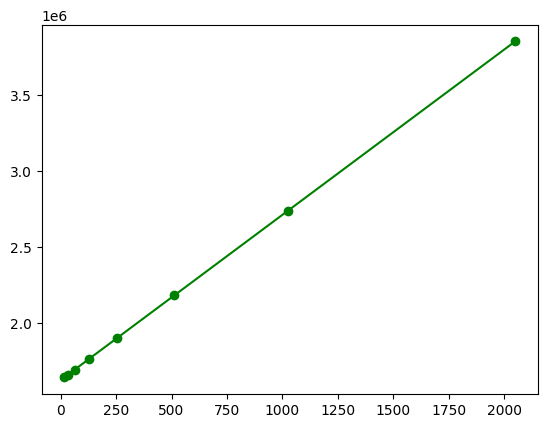

In [87]:
print(no_layers_params)
plt.plot(no_layers, no_layers_params, 'go-')

# 4. No params obbased on no of layer dim

In [88]:
no_layers_DIM = [16,32,128,256,512,1024,2048, 4096]
no_layers_DIM_params = []
for i in range(len(no_layers_DIM)):
    model = UnfoldingFlow(model_path=path_to_model,
                    log_mean = [1,1],
                    log_std = [1,1],
                    no_jets=conf["input_shape"]["number_jets"],
                    no_lept=conf["input_shape"]["number_lept"],
                    input_features=conf["input_shape"]["input_features"],
                    cond_hiddenFeatures=conf["conditioning_transformer"]["hidden_features"],
                    cond_dimFeedForward=conf["conditioning_transformer"]["dim_feedforward_transformer"],
                    cond_outFeatures=conf["conditioning_transformer"]["out_features"],
                    cond_nheadEncoder=conf["conditioning_transformer"]["nhead_encoder"],
                    cond_NoLayersEncoder=conf["conditioning_transformer"]["no_layers_encoder"],
                    cond_nheadDecoder=conf["conditioning_transformer"]["nhead_decoder"],
                    cond_NoLayersDecoder=conf["conditioning_transformer"]["no_layers_decoder"],
                    cond_NoDecoders=conf["conditioning_transformer"]["no_decoders"],
                    cond_aggregate=conf["conditioning_transformer"]["aggregate"],
                    flow_nfeatures=conf["unfolding_flow"]["nfeatures"],
                    flow_ncond=conf["unfolding_flow"]["ncond"], 
                    flow_ntransforms=conf["unfolding_flow"]["ntransforms"],
                    flow_hiddenMLP_NoLayers=conf["unfolding_flow"]["hiddenMLP_NoLayers"], 
                    flow_hiddenMLP_LayerDim=no_layers_DIM[i],
                    flow_bins=conf["unfolding_flow"]["bins"],
                    flow_autoregressive=conf["unfolding_flow"]["autoregressive"])
    no_layers_DIM_params.append(count_parameters(model))


[1638378, 1716842, 2832746, 6040938, 18355562, 66577770, 257394026, 1016513898]


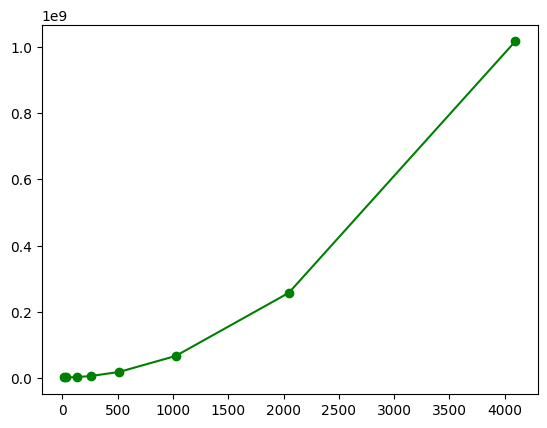

In [89]:
print(no_layers_DIM_params)
plt.plot(no_layers_DIM, no_layers_DIM_params, 'go-')

# Compare bins etc.

[]

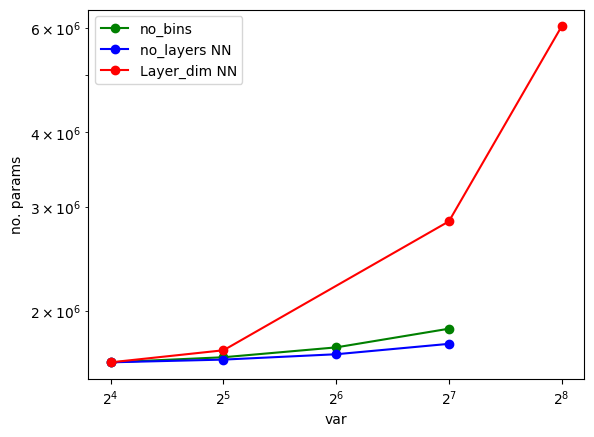

In [97]:
no_bins_norm = [no_bins[i]/max(no_bins) for i in range(len(no_bins))]
no_layers_norm = [no_layers[i]/max(no_layers) for i in range(len(no_layers))]
no_layers_DIM_norm = [no_layers_DIM[i]/max(no_layers_DIM) for i in range(len(no_layers_DIM))]

N = 4
plt.plot(no_bins[0:N], no_bins_params[0:N], 'go-', label='no_bins')
plt.plot(no_layers[0:N], no_layers_params[0:N], 'bo-', label='no_layers NN')
plt.plot(no_layers_DIM[0:N], no_layers_DIM_params[0:N], 'ro-', label='Layer_dim NN')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('var')
plt.ylabel('no. params')
plt.legend()
plt.plot()

[]

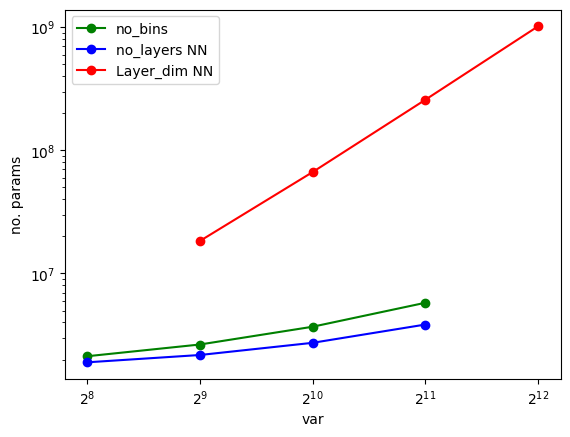

In [98]:
plt.plot(no_bins[N:], no_bins_params[N:], 'go-', label='no_bins')
plt.plot(no_layers[N:], no_layers_params[N:], 'bo-', label='no_layers NN')
plt.plot(no_layers_DIM[N:], no_layers_DIM_params[N:], 'ro-', label='Layer_dim NN')
plt.xscale('log', base=2)
plt.xlabel('var')
plt.yscale('log')
plt.ylabel('no. params')
plt.legend()
plt.plot()

# Compare ntransf with no layers NN

In [92]:
no_layers2 = [4,6,8,10,14,18,22,30]
no_layers_params2 = []
for i in range(len(no_layers)):
    model = UnfoldingFlow(model_path=path_to_model,
                    log_mean = [1,1],
                    log_std = [1,1],
                    no_jets=conf["input_shape"]["number_jets"],
                    no_lept=conf["input_shape"]["number_lept"],
                    input_features=conf["input_shape"]["input_features"],
                    cond_hiddenFeatures=conf["conditioning_transformer"]["hidden_features"],
                    cond_dimFeedForward=conf["conditioning_transformer"]["dim_feedforward_transformer"],
                    cond_outFeatures=conf["conditioning_transformer"]["out_features"],
                    cond_nheadEncoder=conf["conditioning_transformer"]["nhead_encoder"],
                    cond_NoLayersEncoder=conf["conditioning_transformer"]["no_layers_encoder"],
                    cond_nheadDecoder=conf["conditioning_transformer"]["nhead_decoder"],
                    cond_NoLayersDecoder=conf["conditioning_transformer"]["no_layers_decoder"],
                    cond_NoDecoders=conf["conditioning_transformer"]["no_decoders"],
                    cond_aggregate=conf["conditioning_transformer"]["aggregate"],
                    flow_nfeatures=conf["unfolding_flow"]["nfeatures"],
                    flow_ncond=conf["unfolding_flow"]["ncond"], 
                    flow_ntransforms=conf["unfolding_flow"]["ntransforms"],
                    flow_hiddenMLP_NoLayers=no_layers[i], 
                    flow_hiddenMLP_LayerDim=conf["unfolding_flow"]["hiddenMLP_LayerDim"],
                    flow_bins=conf["unfolding_flow"]["bins"],
                    flow_autoregressive=conf["unfolding_flow"]["autoregressive"])
    no_layers_params2.append(count_parameters(model))


[]

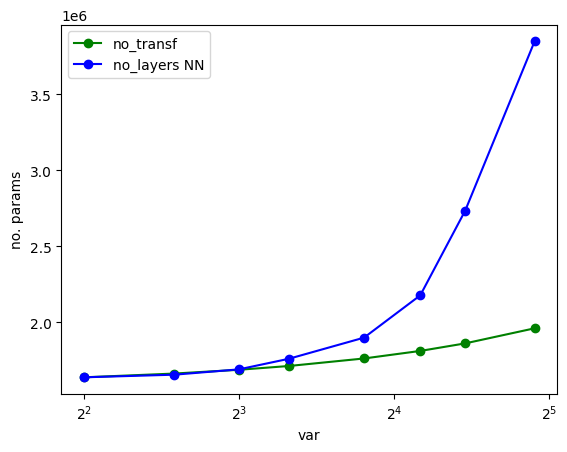

In [93]:
plt.plot(no_transf, no_transf_params, 'go-', label='no_transf')
plt.plot(no_layers2, no_layers_params2, 'bo-', label='no_layers NN')
plt.xlabel('var')
plt.xscale('log', base=2)
plt.ylabel('no. params')
plt.legend()
plt.plot()

In [94]:
batchSize = 1024
path_data = '../../dataset/v7/'
device = torch.device('cpu')

path_unscaled = 'results_preTraining/runs_2/preTraining-MEMFlow_2_v9/unscaledRegressedPartonsTensor.pt'

In [96]:
data = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=[],
                        parton_list=['data_higgs_t_tbar_ISR_cartesian'])

dataCorrect = data.parton_data.data_higgs_t_tbar_ISR_cartesian

higgsCorrect = vector.array(
    {
        "E": dataCorrect[:,0,0].detach().numpy(),
        "px": dataCorrect[:,0,1].detach().numpy(),
        "py": dataCorrect[:,0,2].detach().numpy(),
        "pz": dataCorrect[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCorrect[:,1,0].detach().numpy(),
        "px": dataCorrect[:,1,1].detach().numpy(),
        "py": dataCorrect[:,1,2].detach().numpy(),
        "pz": dataCorrect[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCorrect[:,2,0].detach().numpy(),
        "px": dataCorrect[:,2,1].detach().numpy(),
        "py": dataCorrect[:,2,2].detach().numpy(),
        "pz": dataCorrect[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCorrect[:,3,0].detach().numpy(),
        "px": dataCorrect[:,3,1].detach().numpy(),
        "py": dataCorrect[:,3,2].detach().numpy(),
        "pz": dataCorrect[:,3,3].detach().numpy(),
    }
)


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files


In [97]:
unscaledTensor = torch.load(path_unscaled)

data_regressed = torch.sign(unscaledTensor)*(torch.exp(torch.abs(unscaledTensor)) - 1)

higgs = vector.array(
    {
        "E": data_regressed[:,0,0].detach().numpy(),
        "px": data_regressed[:,0,1].detach().numpy(),
        "py": data_regressed[:,0,2].detach().numpy(),
        "pz": data_regressed[:,0,3].detach().numpy(),
    }
)

thad = vector.array(
    {
        "E": data_regressed[:,1,0].detach().numpy(),
        "px": data_regressed[:,1,1].detach().numpy(),
        "py": data_regressed[:,1,2].detach().numpy(),
        "pz": data_regressed[:,1,3].detach().numpy(),
    }
)

tlep = vector.array(
    {
        "E": data_regressed[:,2,0].detach().numpy(),
        "px": data_regressed[:,2,1].detach().numpy(),
        "py": data_regressed[:,2,2].detach().numpy(),
        "pz": data_regressed[:,2,3].detach().numpy(),
    }
)

glISR = vector.array(
    {
        "E": data_regressed[:,3,0].detach().numpy(),
        "px": data_regressed[:,3,1].detach().numpy(),
        "py": data_regressed[:,3,2].detach().numpy(),
        "pz": data_regressed[:,3,3].detach().numpy(),
    }
)

print(unscaledTensor.shape)

torch.Size([569993, 4, 4])


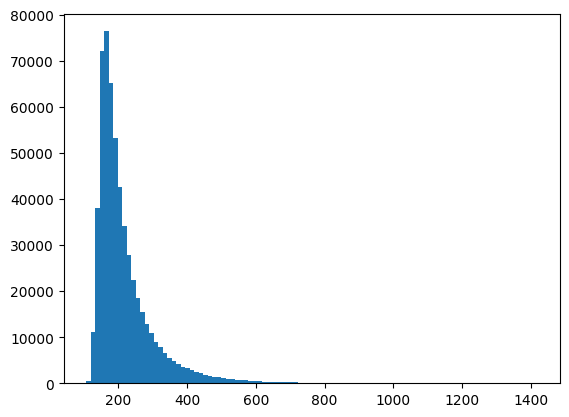

In [98]:
x = plt.hist(higgs["E"], bins=100)

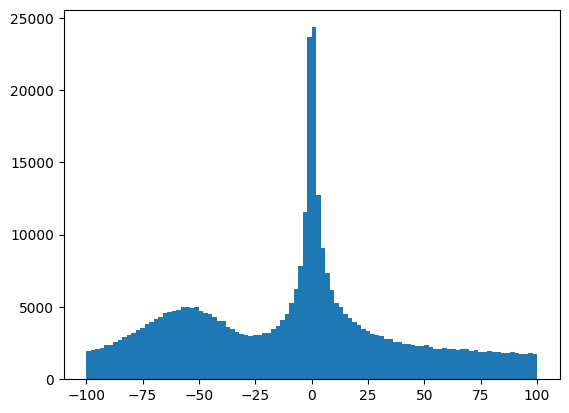

In [99]:
x = plt.hist(higgs["px"], bins=100, range=(-100,100))

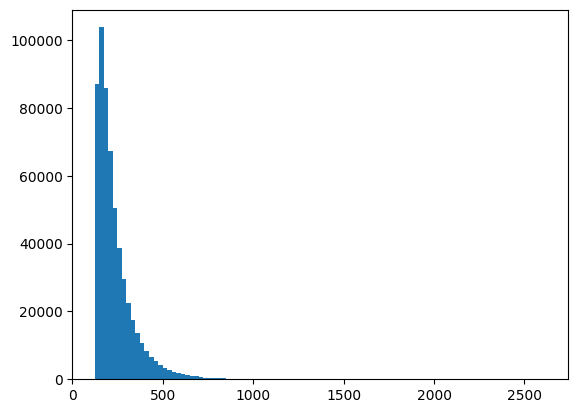

In [100]:
x = plt.hist(higgsCorrect["E"], bins=100)

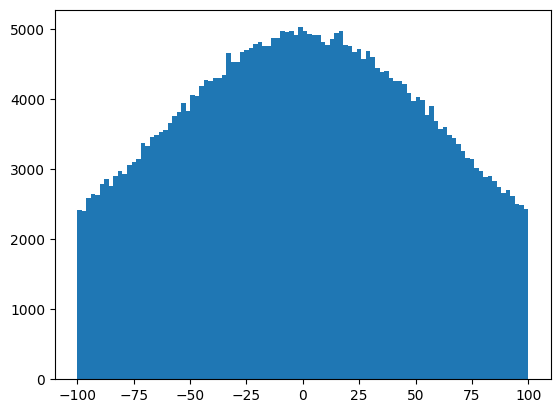

In [101]:
x = plt.hist(higgsCorrect["px"], bins=100, range=(-100,100))

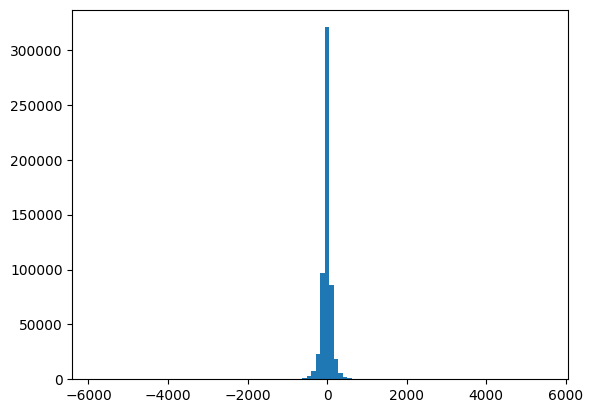

In [102]:
x = plt.hist(higgsCorrect["pz"] - higgs["pz"], bins=100)

# Plot eta

In [103]:
import matplotlib as mpl

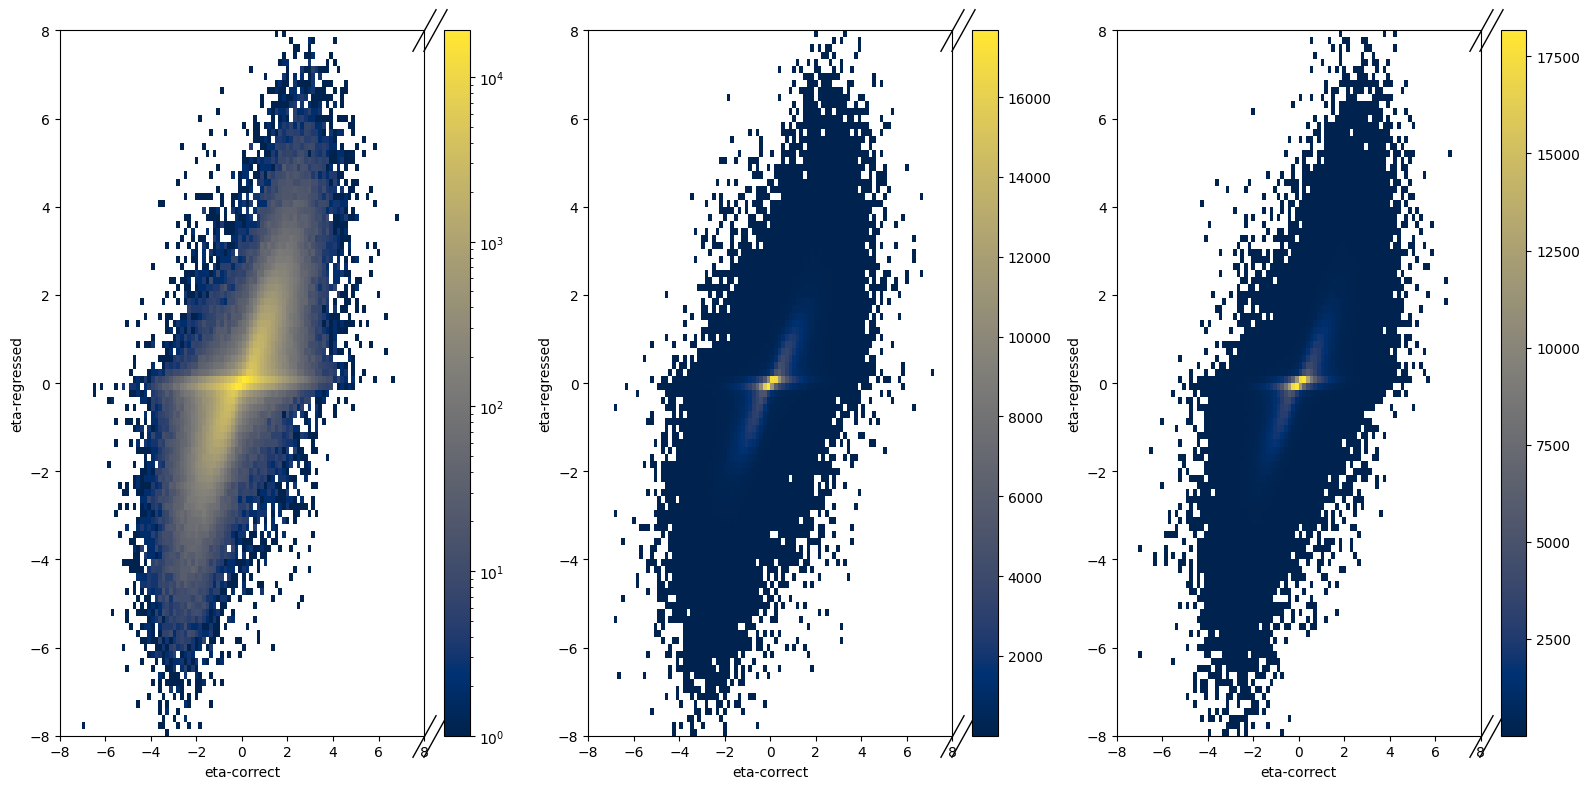

In [104]:
pi = torch.pi

# Quick construction, no other imports needed:
hist2d_eta_higgs = (
  Hist.new
  .Reg(bins=100, start=-8, stop=8, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=-8, stop=8, name="eta-regressed", label="eta-regressed")
  .Double())

hist2d_eta_thad = (
  Hist.new
  .Reg(bins=100, start=-8, stop=8, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=-8, stop=8, name="eta-regressed", label="eta-regressed")
  .Double())

hist2d_eta_tlep = (
  Hist.new
  .Reg(bins=100, start=-8, stop=8, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=-8, stop=8, name="eta-regressed", label="eta-regressed")
  .Double())

hist2d_eta_higgs.fill(higgsCorrect.eta,
                higgs.eta)
    
hist2d_eta_thad.fill(thadCorrect.eta,
                thad.eta)
    
hist2d_eta_tlep.fill(tlepCorrect.eta,
                tlep.eta)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_higgs, norm=mpl.colors.LogNorm(vmin=1), cmap="cividis", ax=axs[0])

mplhep.hist2dplot(hist2d_eta_thad, cmap="cividis", cmin=1, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_tlep, cmap="cividis", cmin=1, ax=axs[2])

plt.tight_layout()

# makessense to be worse because eta is related to pz

# Plot E, px, py, pz for thad

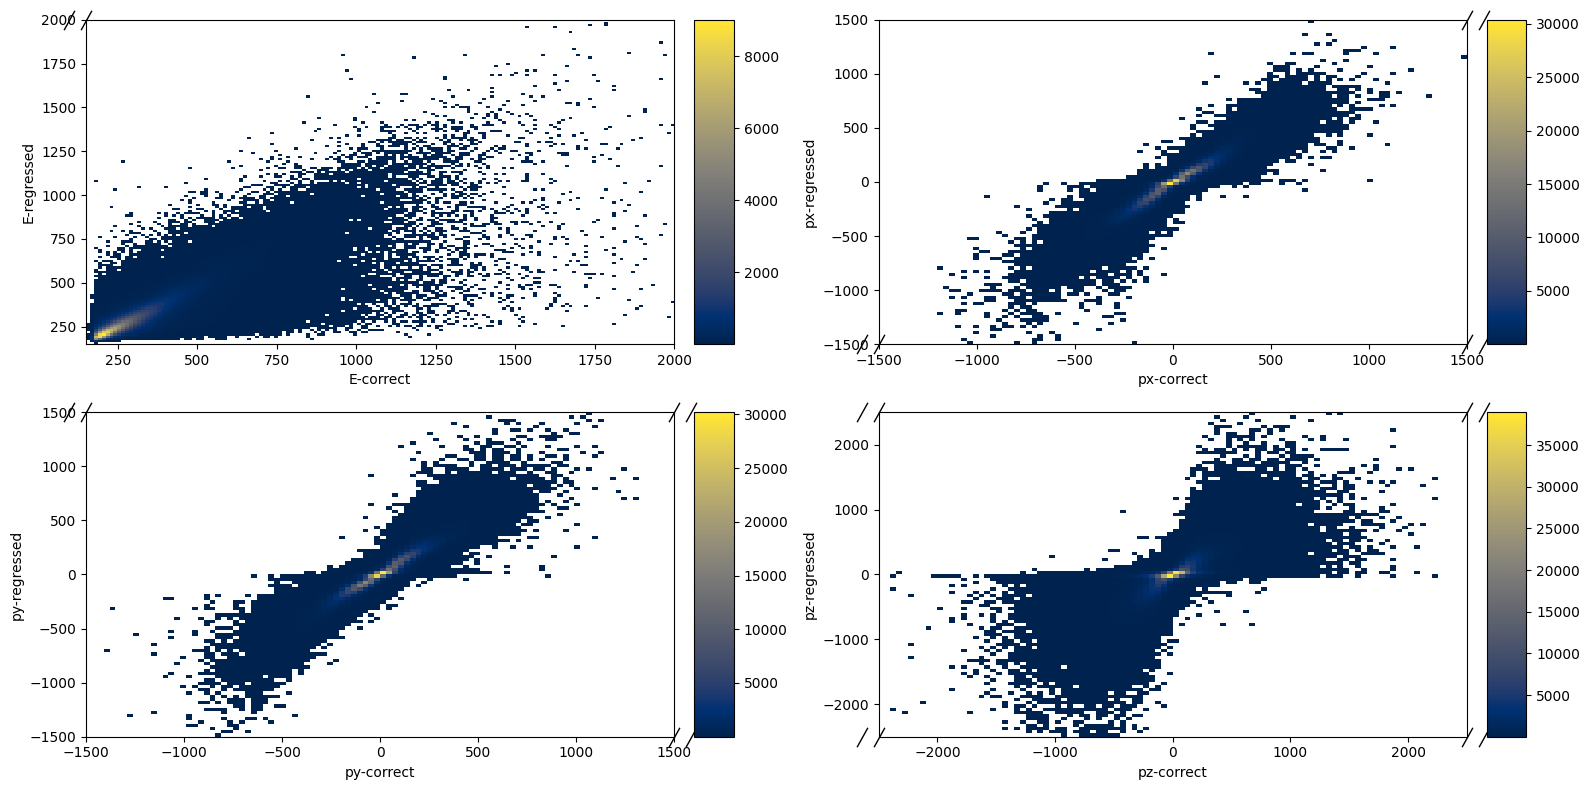

In [105]:
hist2d_E_thad = (
  Hist.new
  .Reg(bins=150, start=150, stop=2000, name="E-correct", label="E-correct")
  .Reg(bins=150, start=150, stop=2000, name="E-regressed", label="E-regressed")
  .Double())

hist2d_px_thad = (
  Hist.new
  .Reg(bins=100, start=-1500, stop=1500, name="px-correct", label="px-correct")
  .Reg(bins=100, start=-1500, stop=1500, name="px-regressed", label="px-regressed")
  .Double())

hist2d_py_thad = (
  Hist.new
  .Reg(bins=100, start=-1500, stop=1500, name="py-correct", label="py-correct")
  .Reg(bins=100, start=-1500, stop=1500, name="py-regressed", label="py-regressed")
  .Double())

hist2d_pz_thad = (
  Hist.new
  .Reg(bins=100, start=-2500, stop=2500, name="pz-correct", label="pz-correct")
  .Reg(bins=100, start=-2500, stop=2500, name="pz-regressed", label="pz-regressed")
  .Double())

hist2d_E_thad.fill(thadCorrect.E,
                thad.E)

hist2d_px_thad.fill(thadCorrect.px,
                thad.px)

hist2d_py_thad.fill(thadCorrect.py,
                thad.py)

hist2d_pz_thad.fill(thadCorrect.pz,
                thad.pz)

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

mplhep.hist2dplot(hist2d_E_thad, cmap="cividis", cmin=1, ax=axs[0, 0])

mplhep.hist2dplot(hist2d_px_thad, cmap="cividis", cmin=1, ax=axs[0, 1])

mplhep.hist2dplot(hist2d_py_thad, cmap="cividis", cmin=1, ax=axs[1, 0])

mplhep.hist2dplot(hist2d_pz_thad, cmap="cividis", cmin=1, ax=axs[1, 1])

plt.tight_layout()

# Plot phi

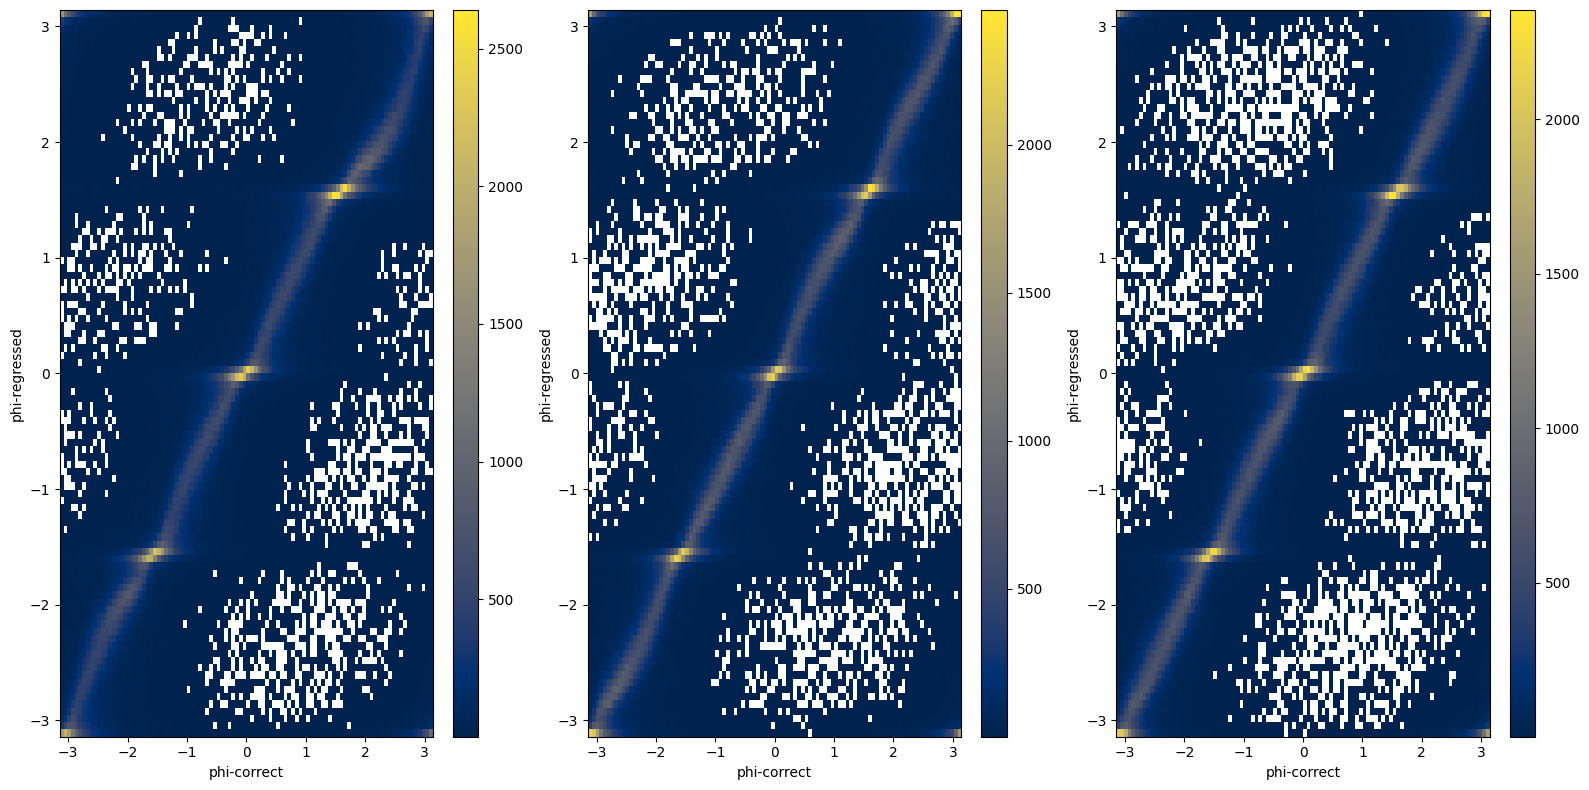

In [106]:
# Quick construction, no other imports needed:
hist2d_phi_higgs = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
  .Double())

hist2d_phi_thad = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
  .Double())

hist2d_phi_tlep = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
  .Double())

hist2d_phi_higgs.fill(higgsCorrect.phi,
                higgs.phi)
    
hist2d_phi_thad.fill(thadCorrect.phi,
                thad.phi)
    
hist2d_phi_tlep.fill(tlepCorrect.phi,
                tlep.phi)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_phi_higgs, cmap="cividis", cmin=1, ax=axs[0])

mplhep.hist2dplot(hist2d_phi_thad, cmap="cividis", cmin=1, ax=axs[1])

mplhep.hist2dplot(hist2d_phi_tlep, cmap="cividis", cmin=1, ax=axs[2])

plt.tight_layout()

# Plot pt

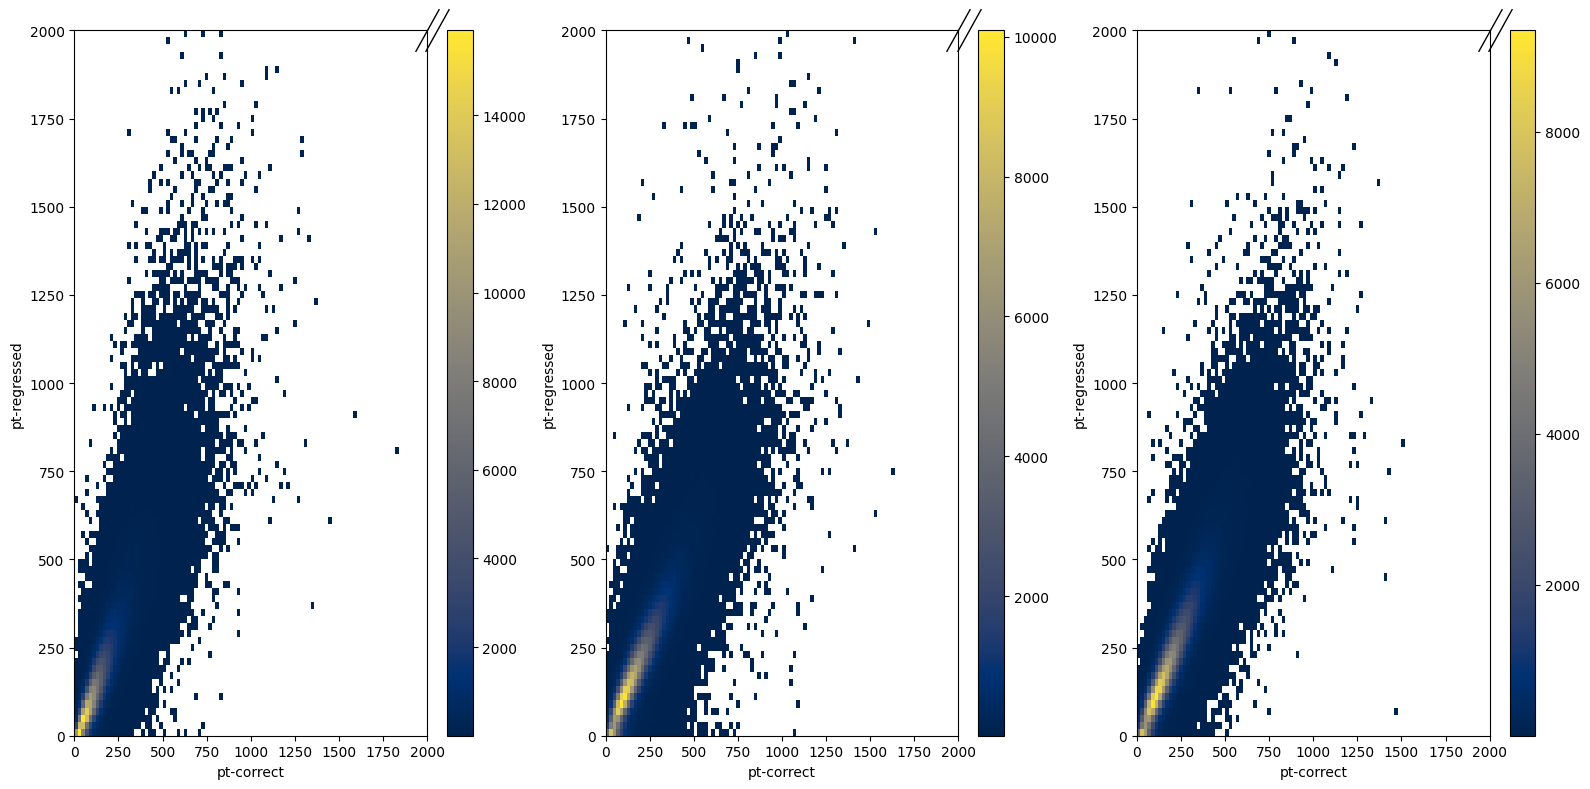

In [107]:
# Quick construction, no other imports needed:
hist2d_pt_higgs = (
  Hist.new
  .Reg(bins=100, start=0, stop=2000, name="pt-correct", label="pt-correct")
  .Reg(bins=100, start=0, stop=2000, name="pt-regressed", label="pt-regressed")
  .Double())

hist2d_pt_thad = (
  Hist.new
  .Reg(bins=100, start=0, stop=2000, name="pt-correct", label="pt-correct")
  .Reg(bins=100, start=0, stop=2000, name="pt-regressed", label="pt-regressed")
  .Double())

hist2d_pt_tlep = (
  Hist.new
  .Reg(bins=100, start=0, stop=2000, name="pt-correct", label="pt-correct")
  .Reg(bins=100, start=0, stop=2000, name="pt-regressed", label="pt-regressed")
  .Double())

hist2d_pt_higgs.fill(higgsCorrect.pt,
                higgs.pt)
    
hist2d_pt_thad.fill(thadCorrect.pt,
                thad.pt)
    
hist2d_pt_tlep.fill(tlepCorrect.pt,
                tlep.pt)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_pt_higgs, cmap="cividis", cmin=1, ax=axs[0])

mplhep.hist2dplot(hist2d_pt_thad, cmap="cividis", cmin=1, ax=axs[1])

mplhep.hist2dplot(hist2d_pt_tlep, cmap="cividis", cmin=1, ax=axs[2])

plt.tight_layout()

# Plot eta vs delta(pt)

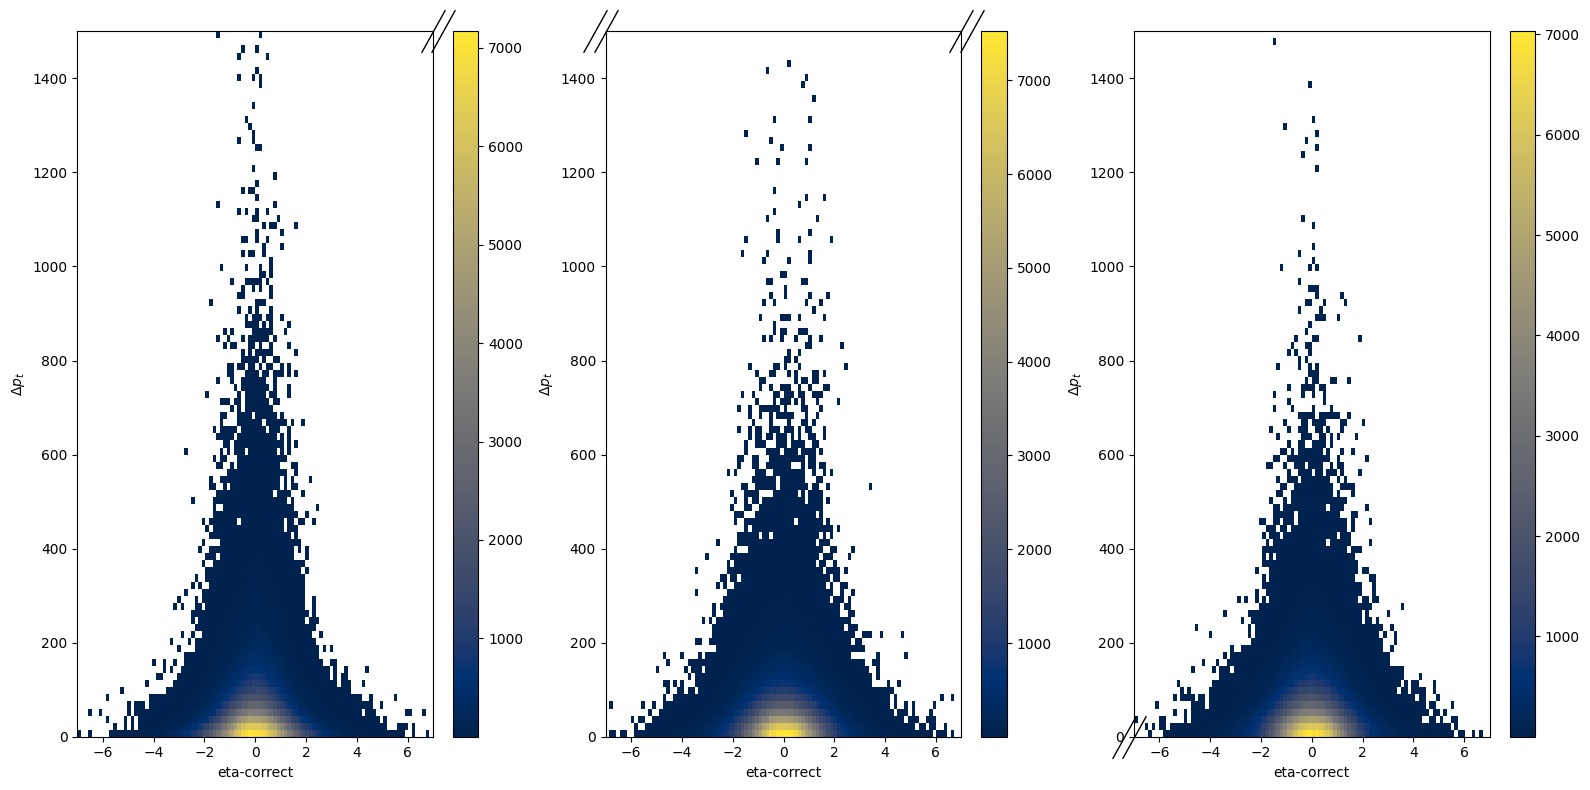

In [108]:
# Quick construction, no other imports needed:
hist2d_eta_Diffpt_higgs = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=1500, name="$\Delta p_t$", label="$\Delta p_t$")
  .Double())

hist2d_eta_Diffpt_thad = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=1500, name="$\Delta p_t$", label="$\Delta p_t$")
  .Double())

hist2d_eta_Diffpt_tlep = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=1500, name="$\Delta p_t$", label="$\Delta p_t$")
  .Double())

hist2d_eta_Diffpt_higgs.fill(higgsCorrect.eta,
                np.abs(higgs.pt - higgsCorrect.pt))
    
hist2d_eta_Diffpt_thad.fill(thadCorrect.eta,
                np.abs(thad.pt - thadCorrect.pt))
    
hist2d_eta_Diffpt_tlep.fill(tlepCorrect.eta,
                np.abs(tlep.pt - tlepCorrect.pt))

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_Diffpt_higgs, cmap="cividis", cmin=1, ax=axs[0])

mplhep.hist2dplot(hist2d_eta_Diffpt_thad, cmap="cividis", cmin=1, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_Diffpt_tlep, cmap="cividis", cmin=1, ax=axs[2])

plt.tight_layout()

# Plot eta vs delta(phi)

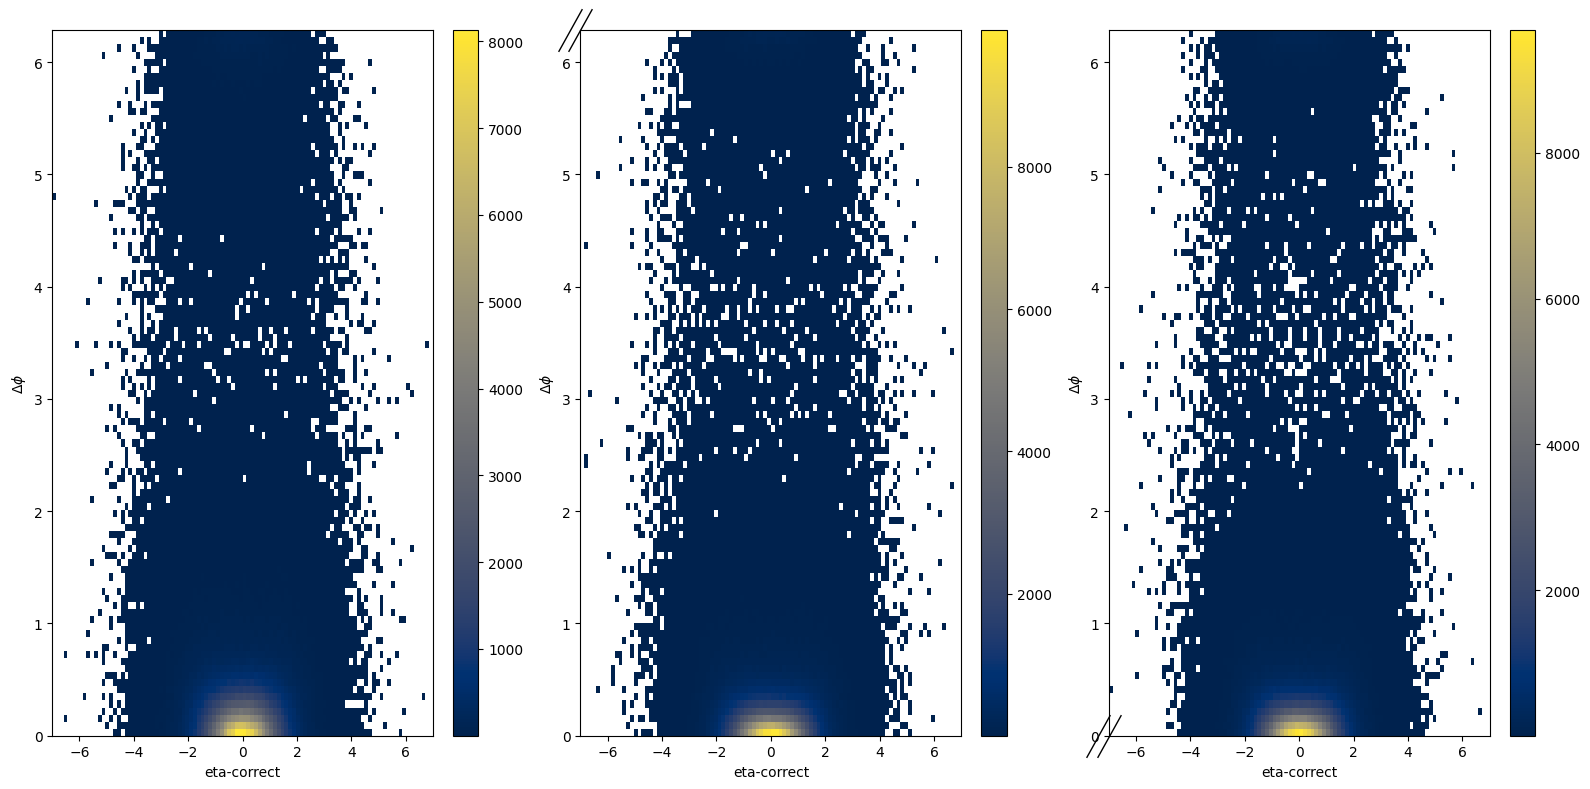

In [109]:
# Quick construction, no other imports needed:
hist2d_eta_Diffphi_higgs = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=2*pi, name="$\Delta \phi$", label="$\Delta \phi$")
  .Double())

hist2d_eta_Diffphi_thad = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=2*pi, name="$\Delta \phi$", label="$\Delta \phi$")
  .Double())

hist2d_eta_Diffphi_tlep = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=2*pi, name="$\Delta \phi$", label="$\Delta \phi$")
  .Double())

hist2d_eta_Diffphi_higgs.fill(higgsCorrect.eta,
                np.abs(higgs.phi - higgsCorrect.phi))
    
hist2d_eta_Diffphi_thad.fill(thadCorrect.eta,
                np.abs(thad.phi - thadCorrect.phi))
    
hist2d_eta_Diffphi_tlep.fill(tlepCorrect.eta,
                np.abs(tlep.phi - tlepCorrect.phi))

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_Diffphi_higgs, cmap="cividis", cmin=1, ax=axs[0])

mplhep.hist2dplot(hist2d_eta_Diffphi_thad, cmap="cividis", cmin=1, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_Diffphi_tlep, cmap="cividis", cmin=1, ax=axs[2])

plt.tight_layout()

# Plot eta vs delta(R)

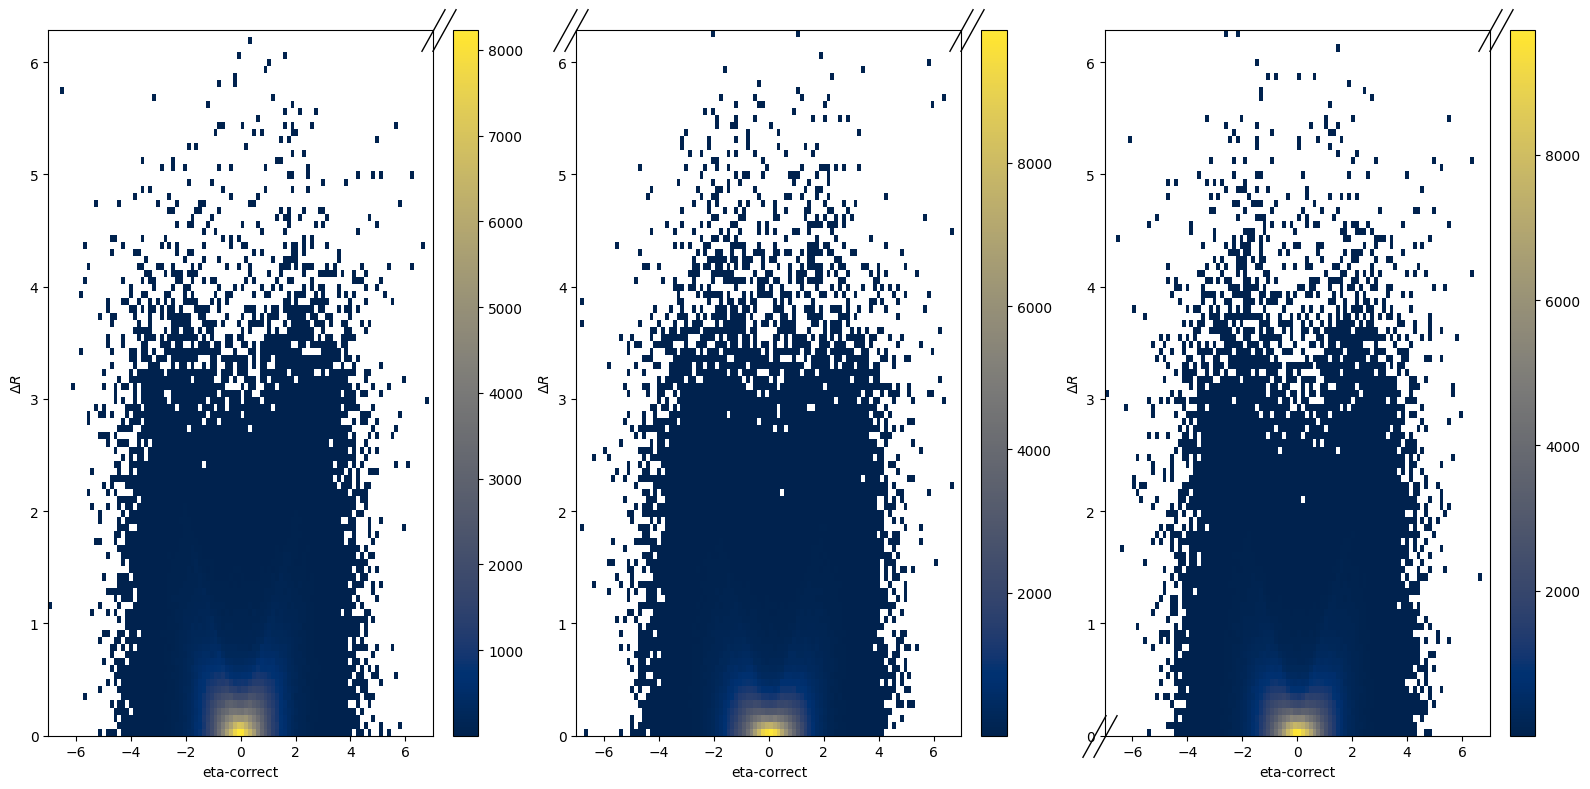

In [110]:
# Quick construction, no other imports needed:
hist2d_eta_DiffR_higgs = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=2*pi, name="$\Delta R$", label="$\Delta R$")
  .Double())

hist2d_eta_DiffR_thad = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=2*pi, name="$\Delta R$", label="$\Delta R$")
  .Double())

hist2d_eta_DiffR_tlep = (
  Hist.new
  .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=2*pi, name="$\Delta R$", label="$\Delta R$")
  .Double())

hist2d_eta_DiffR_higgs.fill(higgsCorrect.eta,
                np.abs(np.sqrt(higgs.phi**2 + higgs.eta**2) -  np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2)))
    
hist2d_eta_DiffR_thad.fill(thadCorrect.eta,
                np.abs(np.sqrt(thad.phi**2 + thad.eta**2) -  np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2)))
    
hist2d_eta_DiffR_tlep.fill(tlepCorrect.eta,
                np.abs(np.sqrt(tlep.phi**2 + tlep.eta**2) -  np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2)))

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_DiffR_higgs, cmap="cividis", cmin=1, ax=axs[0])

mplhep.hist2dplot(hist2d_eta_DiffR_thad, cmap="cividis", cmin=1, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_DiffR_tlep, cmap="cividis", cmin=1, ax=axs[2])

plt.tight_layout()

# Split in matched/unmatched

In [111]:
import awkward as ak

In [112]:
df = ak.from_parquet("../../dataset/v7/all_jets.parquet")

jets = df.jets
partons = df.partons
partons_matched = df.partons_matched
lepton_partons = df.lepton_partons
lepton_reco = df.lepton_reco

# in fiecare event am 4 particule: higgs tlep thad glISR
# vreau sa vad care din astea sunt matched si care nu
# ma uit la jets cu prov = 2 pt higgs si tot asa?

In [113]:
partons[0].type

ArrayType(RecordType([NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64')], ['pt', 'eta', 'phi', 'mass', 'pdgId', 'prov']), 7)

In [114]:
partons_matched[0].type

ArrayType(OptionType(RecordType([NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64'), NumpyType('float64')], ['pt', 'eta', 'phi', 'mass', 'pdgId', 'prov'])), 5)

In [115]:
ak.to_numpy(partons[0]["pt"])

array([30.55859375, 73.28515625, 78.609375  , 12.87988281, 40.84570312,
       54.125     , 66.        ])

In [116]:
ak.to_numpy(partons_matched[0]["pt"])

masked_array(data=[78.609375, 73.28515625, --, 30.55859375, 40.845703125],
             mask=[False, False,  True, False, False],
       fill_value=1e+20)

In [117]:
partons[7878].prov

<Array [4, 3, 2, 5, 5, 1, 1] type='7 * float64'>

In [118]:
jets[0]["matched"]

<Array [True, True, False, True, True] type='5 * bool'>

In [119]:
jets[0]["prov"]

<Array [2, 3, -1, 4, 5] type='5 * float64'>

In [120]:
jets[3]["matched"]

<Array [True, True, True, False, True, True, False] type='7 * bool'>

In [121]:
jets[3]["prov"]

<Array [4, 2, 1, -1, 3, 1, -1] type='7 * float64'>

In [122]:
partons_knownprov = partons_matched[jets.prov != -1]

# Higgs mask

In [123]:
prov1_jets = jets[jets.prov == 1]

In [124]:
prov1 = prov1_jets["prov"]

In [125]:
prov1

<Array [[], [1, 1], [1], ..., [1, ...], [1], [1]] type='569993 * var * float64'>

In [126]:
higgs_mask = ak.count(prov1, axis=1) == 2

In [127]:
higgs_mask = ak.to_numpy(higgs_mask) # matched higgs

higgs_mask

array([False,  True, False, ...,  True, False, False])

# thad mask

In [128]:
prov2_jets = jets[jets.prov == 2] # b from hadronic top decay

In [129]:
prov2 = prov2_jets["prov"]

In [130]:
prov2

<Array [[2], [2], [2], [2], ..., [2], [2], [2]] type='569993 * var * float64'>

In [131]:
hadb_mask = ak.count(prov2, axis=1) == 1

In [132]:
hadb_mask

<Array [True, True, True, True, ..., True, True, True] type='569993 * bool'>

In [133]:
prov5_jets = jets[jets.prov == 5] # q from hadronic W decay

In [134]:
prov5 = prov5_jets["prov"]

In [135]:
prov5

<Array [[5], [5, 5], [5], [], ..., [5], [], [5]] type='569993 * var * float64'>

In [136]:
hadW_mask = ak.count(prov5, axis=1) == 2

In [137]:
hadW_mask

<Array [False, True, False, ..., False, False, False] type='569993 * bool'>

In [138]:
hadb_mask = ak.to_numpy(hadb_mask)
hadW_mask = ak.to_numpy(hadW_mask)

In [139]:
hadt_mask = np.logical_and(hadb_mask, hadW_mask)

In [140]:
hadt_mask # matched thad

array([False,  True, False, ..., False, False, False])

# tlep mask

In [141]:
prov3_jets = jets[jets.prov == 3] # b from lept top decay

prov3 = prov3_jets["prov"]

prov3

<Array [[3], [3], [3], [3], ..., [3], [3], [3]] type='569993 * var * float64'>

In [142]:
lepb_mask = ak.count(prov3, axis=1) == 1

lepb_mask

<Array [True, True, True, True, ..., True, True, True] type='569993 * bool'>

In [143]:
x = lepton_reco.pt < 0
ak.any(x) # all elements from x are false => all leptons matched

False

In [144]:
tlep_mask = lepb_mask

tlep_mask = ak.to_numpy(tlep_mask)

tlep_mask

array([ True,  True,  True, ...,  True,  True,  True])

# Gluon ISR mask

In [145]:
prov4_jets = jets[jets.prov == 4]
prov4 = prov4_jets["prov"]
prov4

<Array [[4], [], [], [4], ..., [4], [], [4], []] type='569993 * var * float64'>

In [146]:
ISR_mask = ak.count(prov4, axis=1) == 1
ISR_mask = ak.to_numpy(ISR_mask)
ISR_mask

array([ True, False, False, ..., False,  True, False])

# matched plots

In [147]:
def plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, ISRCorrect, ISR,
            higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False):
    
    
    # Quick construction, no other imports needed:
    hist2d_eta_higgs = (
      Hist.new
      .Reg(bins=100, start=-8, stop=8, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=-8, stop=8, name="eta-regressed", label="eta-regressed")
      .Double())

    hist2d_eta_thad = (
      Hist.new
      .Reg(bins=100, start=-8, stop=8, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=-8, stop=8, name="eta-regressed", label="eta-regressed")
      .Double())

    hist2d_eta_tlep = (
      Hist.new
      .Reg(bins=100, start=-8, stop=8, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=-8, stop=8, name="eta-regressed", label="eta-regressed")
      .Double())
    
    hist2d_eta_ISR = (
      Hist.new
      .Reg(bins=100, start=-8, stop=8, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=-8, stop=8, name="eta-regressed", label="eta-regressed")
      .Double())

    hist2d_eta_higgs.fill(higgsCorrect.eta[higgs_mask],
                    higgs.eta[higgs_mask])

    hist2d_eta_thad.fill(thadCorrect.eta[thad_mask],
                    thad.eta[thad_mask])

    hist2d_eta_tlep.fill(tlepCorrect.eta[tlep_mask],
                    tlep.eta[tlep_mask])
    
    hist2d_eta_ISR.fill(ISRCorrect.eta[ISR_mask],
                    ISR.eta[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))
    
    if log:
        mplhep.hist2dplot(hist2d_eta_higgs, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_tlep, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_ISR, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[3])

        plt.tight_layout()
    else:
        mplhep.hist2dplot(hist2d_eta_higgs, cmap="cividis", cmin=1, ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_thad, cmap="cividis", cmin=1, ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_tlep, cmap="cividis", cmin=1, ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_ISR, cmap="cividis", cmin=1, ax=axs[3])

        plt.tight_layout()

    # makessense to be worse because eta is related to pz

In [148]:
def plot_particle(particleCorrect, particle, particle_mask=1, log=False):

    hist2d_E_thad = (
      Hist.new
      .Reg(bins=150, start=100, stop=2000, name="E-correct", label="E-correct")
      .Reg(bins=150, start=100, stop=2000, name="E-regressed", label="E-regressed")
      .Double())

    hist2d_px_thad = (
      Hist.new
      .Reg(bins=100, start=-1500, stop=1500, name="px-correct", label="px-correct")
      .Reg(bins=100, start=-1500, stop=1500, name="px-regressed", label="px-regressed")
      .Double())

    hist2d_py_thad = (
      Hist.new
      .Reg(bins=100, start=-1500, stop=1500, name="py-correct", label="py-correct")
      .Reg(bins=100, start=-1500, stop=1500, name="py-regressed", label="py-regressed")
      .Double())

    hist2d_pz_thad = (
      Hist.new
      .Reg(bins=100, start=-2500, stop=2500, name="pz-correct", label="pz-correct")
      .Reg(bins=100, start=-2500, stop=2500, name="pz-regressed", label="pz-regressed")
      .Double())

    hist2d_E_thad.fill(particleCorrect.E[particle_mask],
                    particle.E[particle_mask])

    hist2d_px_thad.fill(particleCorrect.px[particle_mask],
                    particle.px[particle_mask])

    hist2d_py_thad.fill(particleCorrect.py[particle_mask],
                    particle.py[particle_mask])

    hist2d_pz_thad.fill(particleCorrect.pz[particle_mask],
                    particle.pz[particle_mask])

    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    if log:
        
        mplhep.hist2dplot(hist2d_E_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0, 0])

        mplhep.hist2dplot(hist2d_px_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0, 1])

        mplhep.hist2dplot(hist2d_py_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1, 0])

        mplhep.hist2dplot(hist2d_pz_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1, 1])
        
    else:
        mplhep.hist2dplot(hist2d_E_thad, cmap="cividis", cmin=1, ax=axs[0, 0])

        mplhep.hist2dplot(hist2d_px_thad, cmap="cividis", cmin=1, ax=axs[0, 1])

        mplhep.hist2dplot(hist2d_py_thad, cmap="cividis", cmin=1, ax=axs[1, 0])

        mplhep.hist2dplot(hist2d_pz_thad, cmap="cividis", cmin=1, ax=axs[1, 1])
        
    plt.tight_layout()

In [149]:
def plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, ISRCorrect, ISR,
            higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False):

    # Quick construction, no other imports needed:
    hist2d_phi_higgs = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
      .Double())

    hist2d_phi_thad = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
      .Double())

    hist2d_phi_tlep = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
      .Double())
    
    hist2d_phi_ISR = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
      .Double())

    hist2d_phi_higgs.fill(higgsCorrect.phi[higgs_mask],
                    higgs.phi[higgs_mask])

    hist2d_phi_thad.fill(thadCorrect.phi[thad_mask],
                    thad.phi[thad_mask])

    hist2d_phi_tlep.fill(tlepCorrect.phi[tlep_mask],
                    tlep.phi[tlep_mask])
    
    hist2d_phi_ISR.fill(ISRCorrect.phi[ISR_mask],
                    ISR.phi[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    if log:
        
        mplhep.hist2dplot(hist2d_phi_higgs, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0])

        mplhep.hist2dplot(hist2d_phi_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1])

        mplhep.hist2dplot(hist2d_phi_tlep, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[2])
        
        mplhep.hist2dplot(hist2d_phi_ISR, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[3])
    
    else:
        mplhep.hist2dplot(hist2d_phi_higgs, cmap="cividis", cmin=1, ax=axs[0])

        mplhep.hist2dplot(hist2d_phi_thad, cmap="cividis", cmin=1, ax=axs[1])

        mplhep.hist2dplot(hist2d_phi_tlep, cmap="cividis", cmin=1, ax=axs[2])
        
        mplhep.hist2dplot(hist2d_phi_ISR, cmap="cividis", cmin=1, ax=axs[3])
        
    plt.tight_layout()

In [150]:
def plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, ISRCorrect, ISR,
           higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False):

    # Quick construction, no other imports needed:
    hist2d_pt_higgs = (
      Hist.new
      .Reg(bins=100, start=0, stop=2000, name="pt-correct", label="pt-correct")
      .Reg(bins=100, start=0, stop=2000, name="pt-regressed", label="pt-regressed")
      .Double())

    hist2d_pt_thad = (
      Hist.new
      .Reg(bins=100, start=0, stop=2000, name="pt-correct", label="pt-correct")
      .Reg(bins=100, start=0, stop=2000, name="pt-regressed", label="pt-regressed")
      .Double())

    hist2d_pt_tlep = (
      Hist.new
      .Reg(bins=100, start=0, stop=2000, name="pt-correct", label="pt-correct")
      .Reg(bins=100, start=0, stop=2000, name="pt-regressed", label="pt-regressed")
      .Double())
    
    hist2d_pt_ISR = (
      Hist.new
      .Reg(bins=100, start=0, stop=2000, name="pt-correct", label="pt-correct")
      .Reg(bins=100, start=0, stop=2000, name="pt-regressed", label="pt-regressed")
      .Double())

    hist2d_pt_higgs.fill(higgsCorrect.pt[higgs_mask],
                    higgs.pt[higgs_mask])

    hist2d_pt_thad.fill(thadCorrect.pt[thad_mask],
                    thad.pt[thad_mask])

    hist2d_pt_tlep.fill(tlepCorrect.pt[tlep_mask],
                    tlep.pt[tlep_mask])
    
    hist2d_pt_ISR.fill(ISRCorrect.pt[ISR_mask],
                    ISR.pt[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    if log:
        mplhep.hist2dplot(hist2d_pt_higgs, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0])

        mplhep.hist2dplot(hist2d_pt_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1])

        mplhep.hist2dplot(hist2d_pt_tlep, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[2])
        
        mplhep.hist2dplot(hist2d_pt_ISR, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[3])
        
    else:
        mplhep.hist2dplot(hist2d_pt_higgs, cmap="cividis", cmin=1, ax=axs[0])

        mplhep.hist2dplot(hist2d_pt_thad, cmap="cividis", cmin=1, ax=axs[1])

        mplhep.hist2dplot(hist2d_pt_tlep, cmap="cividis", cmin=1, ax=axs[2])
        
        mplhep.hist2dplot(hist2d_pt_ISR, cmap="cividis", cmin=1, ax=axs[3])

    plt.tight_layout()

In [151]:
def plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, ISRCorrect, ISR,
                   higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False):

    # Quick construction, no other imports needed:
    hist2d_eta_Diffpt_higgs = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=1500, name="$\Delta p_t$", label="$\Delta p_t$")
      .Double())

    hist2d_eta_Diffpt_thad = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=1500, name="$\Delta p_t$", label="$\Delta p_t$")
      .Double())

    hist2d_eta_Diffpt_tlep = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=1500, name="$\Delta p_t$", label="$\Delta p_t$")
      .Double())
    
    hist2d_eta_Diffpt_ISR = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=1500, name="$\Delta p_t$", label="$\Delta p_t$")
      .Double())

    hist2d_eta_Diffpt_higgs.fill(higgsCorrect.eta[higgs_mask],
                    np.abs(higgs.pt - higgsCorrect.pt)[higgs_mask])

    hist2d_eta_Diffpt_thad.fill(thadCorrect.eta[thad_mask],
                    np.abs(thad.pt - thadCorrect.pt)[thad_mask])

    hist2d_eta_Diffpt_tlep.fill(tlepCorrect.eta[tlep_mask],
                    np.abs(tlep.pt - tlepCorrect.pt)[tlep_mask])
    
    hist2d_eta_Diffpt_ISR.fill(ISRCorrect.eta[ISR_mask],
                    np.abs(ISR.pt - ISRCorrect.pt)[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    if log:
        mplhep.hist2dplot(hist2d_eta_Diffpt_higgs, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_Diffpt_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_Diffpt_tlep, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_Diffpt_ISR, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[3])
        
    else:
        mplhep.hist2dplot(hist2d_eta_Diffpt_higgs, cmap="cividis", cmin=1, ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_Diffpt_thad, cmap="cividis", cmin=1, ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_Diffpt_tlep, cmap="cividis", cmin=1, ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_Diffpt_ISR, cmap="cividis", cmin=1, ax=axs[3])
        
    plt.tight_layout()

In [152]:
def plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, ISRCorrect, ISR,
                    higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False):

    # Quick construction, no other imports needed:
    hist2d_eta_Diffphi_higgs = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta \phi$", label="$\Delta \phi$")
      .Double())

    hist2d_eta_Diffphi_thad = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta \phi$", label="$\Delta \phi$")
      .Double())

    hist2d_eta_Diffphi_tlep = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta \phi$", label="$\Delta \phi$")
      .Double())
    
    hist2d_eta_Diffphi_ISR = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta \phi$", label="$\Delta \phi$")
      .Double())

    hist2d_eta_Diffphi_higgs.fill(higgsCorrect.eta[higgs_mask],
                    np.abs(higgs.phi - higgsCorrect.phi)[higgs_mask])

    hist2d_eta_Diffphi_thad.fill(thadCorrect.eta[thad_mask],
                    np.abs(thad.phi - thadCorrect.phi)[thad_mask])

    hist2d_eta_Diffphi_tlep.fill(tlepCorrect.eta[tlep_mask],
                    np.abs(tlep.phi - tlepCorrect.phi)[tlep_mask])
    
    hist2d_eta_Diffphi_ISR.fill(ISRCorrect.eta[ISR_mask],
                    np.abs(ISR.phi - ISRCorrect.phi)[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    if log:
        mplhep.hist2dplot(hist2d_eta_Diffphi_higgs, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_Diffphi_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_Diffphi_tlep, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_Diffphi_ISR, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[3])
        
    else:
        mplhep.hist2dplot(hist2d_eta_Diffphi_higgs, cmap="cividis", cmin=1, ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_Diffphi_thad, cmap="cividis", cmin=1, ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_Diffphi_tlep, cmap="cividis", cmin=1, ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_Diffphi_ISR, cmap="cividis", cmin=1, ax=axs[3])
        
    plt.tight_layout()

In [153]:
def plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, ISRCorrect, ISR,
                  higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False): 
    
    # Quick construction, no other imports needed:
    hist2d_eta_DiffR_higgs = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta R$", label="$\Delta R$")
      .Double())

    hist2d_eta_DiffR_thad = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta R$", label="$\Delta R$")
      .Double())

    hist2d_eta_DiffR_tlep = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta R$", label="$\Delta R$")
      .Double())
    
    hist2d_eta_DiffR_ISR = (
      Hist.new
      .Reg(bins=100, start=-7, stop=7, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=2*pi, name="$\Delta R$", label="$\Delta R$")
      .Double())

    hist2d_eta_DiffR_higgs.fill(higgsCorrect.eta[higgs_mask],
                    np.abs(np.sqrt(higgs.phi**2 + higgs.eta**2) -  np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2))[higgs_mask])

    hist2d_eta_DiffR_thad.fill(thadCorrect.eta[thad_mask],
                    np.abs(np.sqrt(thad.phi**2 + thad.eta**2) -  np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2))[thad_mask])

    hist2d_eta_DiffR_tlep.fill(tlepCorrect.eta[tlep_mask],
                    np.abs(np.sqrt(tlep.phi**2 + tlep.eta**2) -  np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2))[tlep_mask])
    
    hist2d_eta_DiffR_ISR.fill(ISRCorrect.eta[ISR_mask],
                    np.abs(np.sqrt(ISR.phi**2 + ISR.eta**2) -  np.sqrt(ISRCorrect.phi**2 + ISRCorrect.eta**2))[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    if log:
        mplhep.hist2dplot(hist2d_eta_DiffR_higgs, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_DiffR_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_DiffR_tlep, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_DiffR_ISR, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[3])
        
    else:
        mplhep.hist2dplot(hist2d_eta_DiffR_higgs, cmap="cividis", cmin=1, ax=axs[0])

        mplhep.hist2dplot(hist2d_eta_DiffR_thad, cmap="cividis", cmin=1, ax=axs[1])

        mplhep.hist2dplot(hist2d_eta_DiffR_tlep, cmap="cividis", cmin=1, ax=axs[2])
        
        mplhep.hist2dplot(hist2d_eta_DiffR_ISR, cmap="cividis", cmin=1, ax=axs[3])

    plt.tight_layout()

In [154]:
def plot_var2d(higgs_var1, higgs_var2, thad_var1, thad_var2, tlep_var1, tlep_var2,
             ISR_var1, ISR_var2, name1, name2, start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
             higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False):

    # Quick construction, no other imports needed:
    hist2d_var_higgs = (
      Hist.new
      .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
      .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
      .Double())

    hist2d_var_thad = (
      Hist.new
      .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
      .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
      .Double())

    hist2d_var_tlep = (
      Hist.new
      .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
      .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
      .Double())
    
    hist2d_var_ISR = (
      Hist.new
      .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
      .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
      .Double())

    hist2d_var_higgs.fill(higgs_var1[higgs_mask],
                        higgs_var2[higgs_mask])

    hist2d_var_thad.fill(thad_var1[thad_mask],
                        thad_var2[thad_mask])

    hist2d_var_tlep.fill(tlep_var1[tlep_mask],
                        tlep_var2[tlep_mask])
    
    hist2d_var_ISR.fill(ISR_var1[ISR_mask],
                        ISR_var2[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    if log:
        mplhep.hist2dplot(hist2d_var_higgs, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[0])

        mplhep.hist2dplot(hist2d_var_thad, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[1])

        mplhep.hist2dplot(hist2d_var_tlep, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[2])
        
        mplhep.hist2dplot(hist2d_var_ISR, cmap="cividis", norm=mpl.colors.LogNorm(vmin=1), ax=axs[3])
        
    else:
        mplhep.hist2dplot(hist2d_var_higgs, cmap="cividis", cmin=1, ax=axs[0])

        mplhep.hist2dplot(hist2d_var_thad, cmap="cividis", cmin=1, ax=axs[1])

        mplhep.hist2dplot(hist2d_var_tlep, cmap="cividis", cmin=1, ax=axs[2])
        
        mplhep.hist2dplot(hist2d_var_ISR, cmap="cividis", cmin=1, ax=axs[3])
        
    plt.tight_layout()

In [155]:
def plot_var1d(higgs_var1, thad_var1, tlep_var1, ISR_var1, name1, start1=0, stop1=1000, bins1=100,
             higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, log=False):

    # Quick construction, no other imports needed:
    hist1d_var_higgs = Hist(hist.axis.Regular(bins=bins1, start=start1, stop=stop1, name=name1))

    hist1d_var_thad = Hist(hist.axis.Regular(bins=bins1, start=start1, stop=stop1, name=name1))

    hist1d_var_tlep = Hist(hist.axis.Regular(bins=bins1, start=start1, stop=stop1, name=name1))
    
    hist1d_var_ISR = Hist(hist.axis.Regular(bins=bins1, start=start1, stop=stop1, name=name1))

    
    hist1d_var_higgs.fill(higgs_var1[higgs_mask])

    hist1d_var_thad.fill(thad_var1[thad_mask])

    hist1d_var_tlep.fill(tlep_var1[tlep_mask])
    
    hist1d_var_ISR.fill(ISR_var1[ISR_mask])

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    if log:
        mplhep.histplot(hist1d_var_higgs, ax=axs[0])

        mplhep.histplot(hist1d_var_thad, ax=axs[1])

        mplhep.histplot(hist1d_var_tlep, ax=axs[2])
        
        mplhep.histplot(hist1d_var_ISR, ax=axs[3])
        
    else:
        mplhep.histplot(hist1d_var_higgs, ax=axs[0])

        mplhep.histplot(hist1d_var_thad, ax=axs[1])

        mplhep.histplot(hist1d_var_tlep, ax=axs[2])
        
        mplhep.histplot(hist1d_var_ISR, ax=axs[3])
        
    plt.tight_layout()

In [156]:
print(higgsCorrect.eta)
print(higgs_mask)


print(higgsCorrect.eta[higgs_mask])
#print(x[x != np.array(None)])

[-0.8516019   0.4184335   0.55650985 ...  0.94919015 -0.18696966
 -0.12913411]
[False  True False ...  True False False]
[ 0.4184335  -0.09963134  0.66096203 ... -0.68148372  0.42494923
  0.94919015]


# First plots

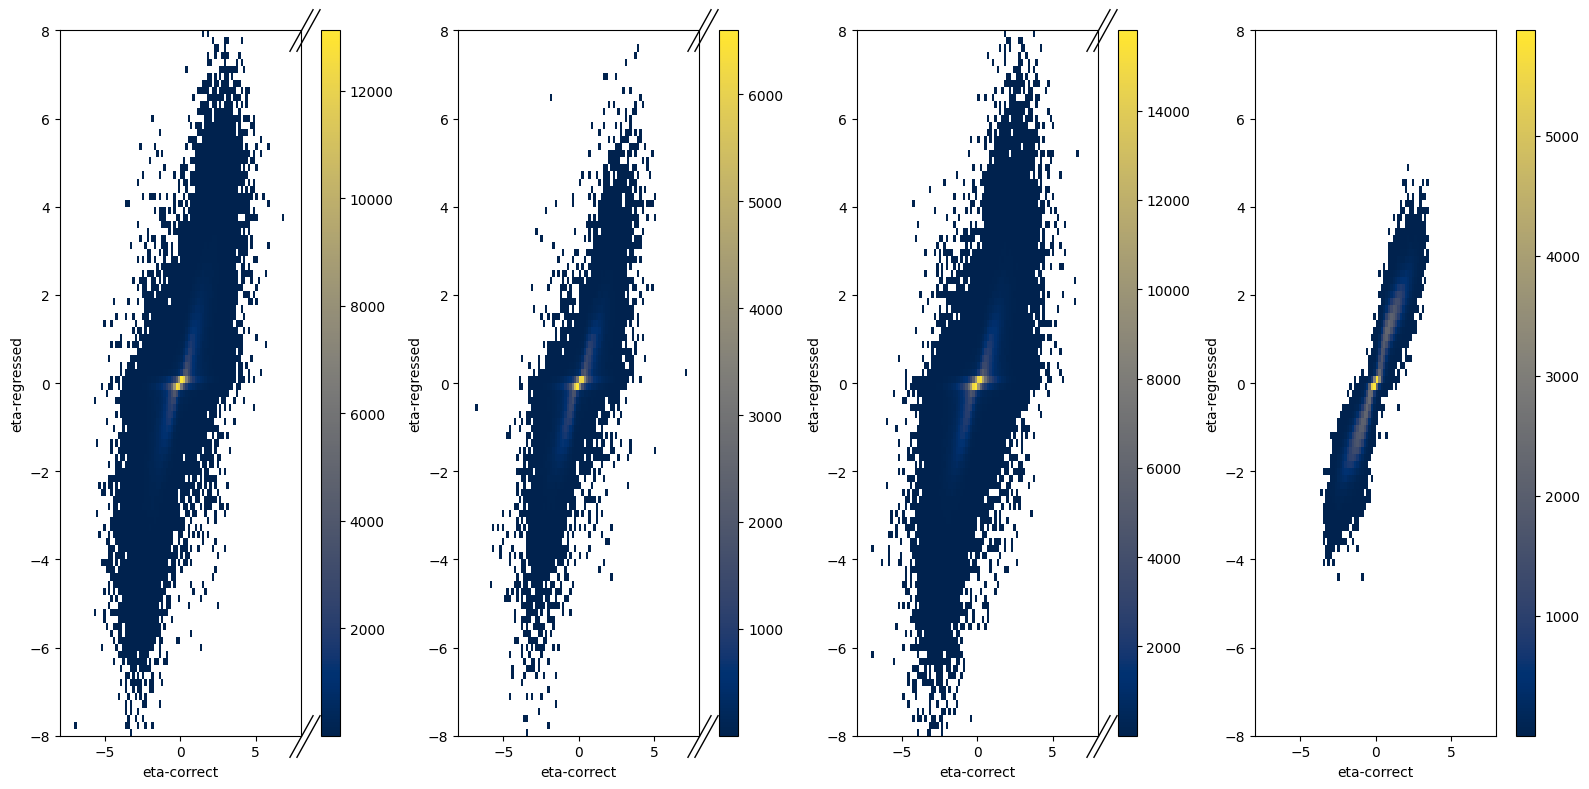

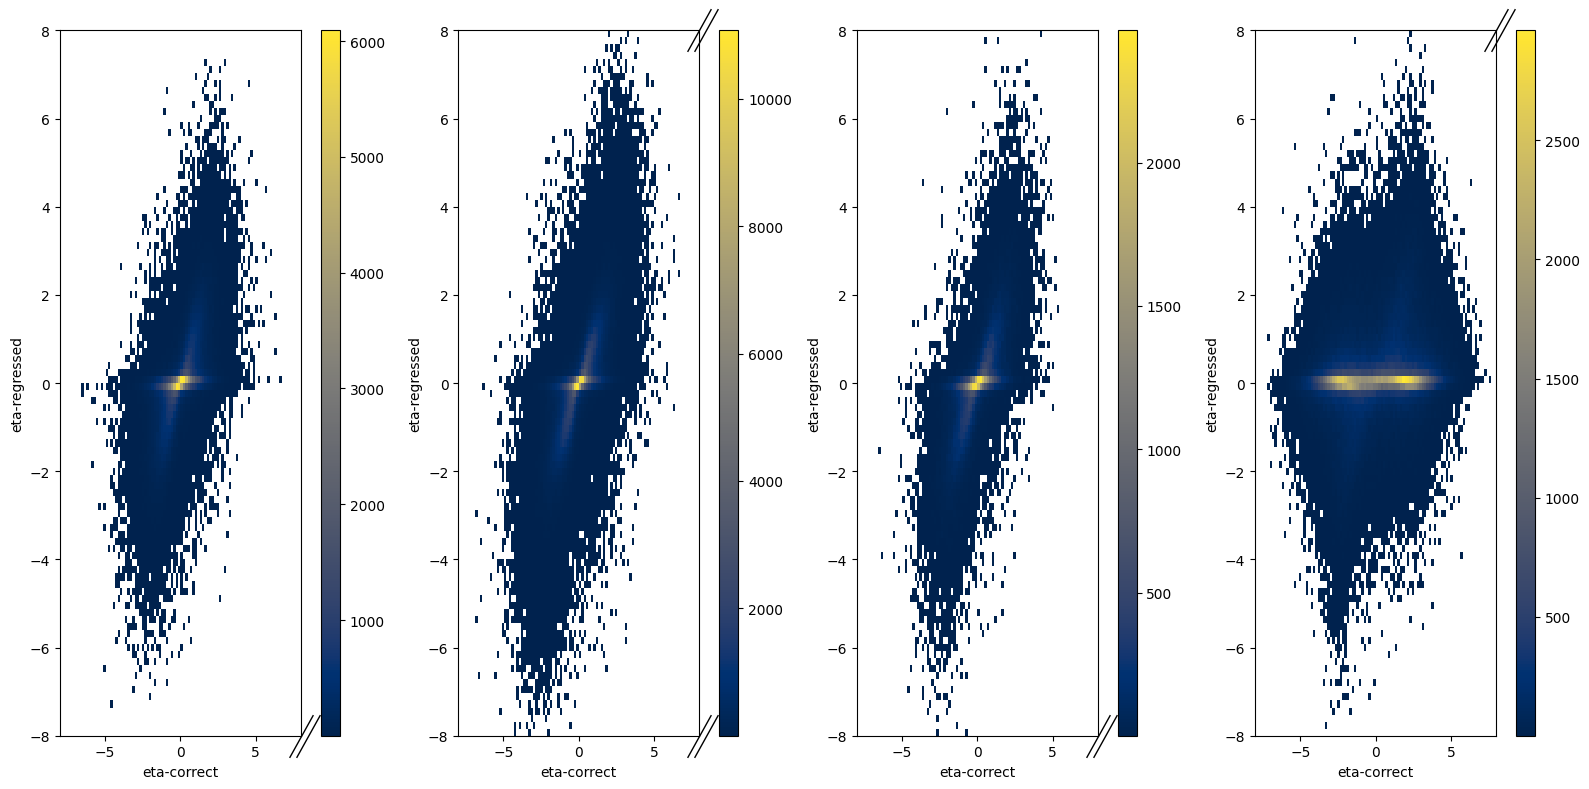

In [157]:
plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask)

plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
         ISR_mask = np.logical_not(ISR_mask))

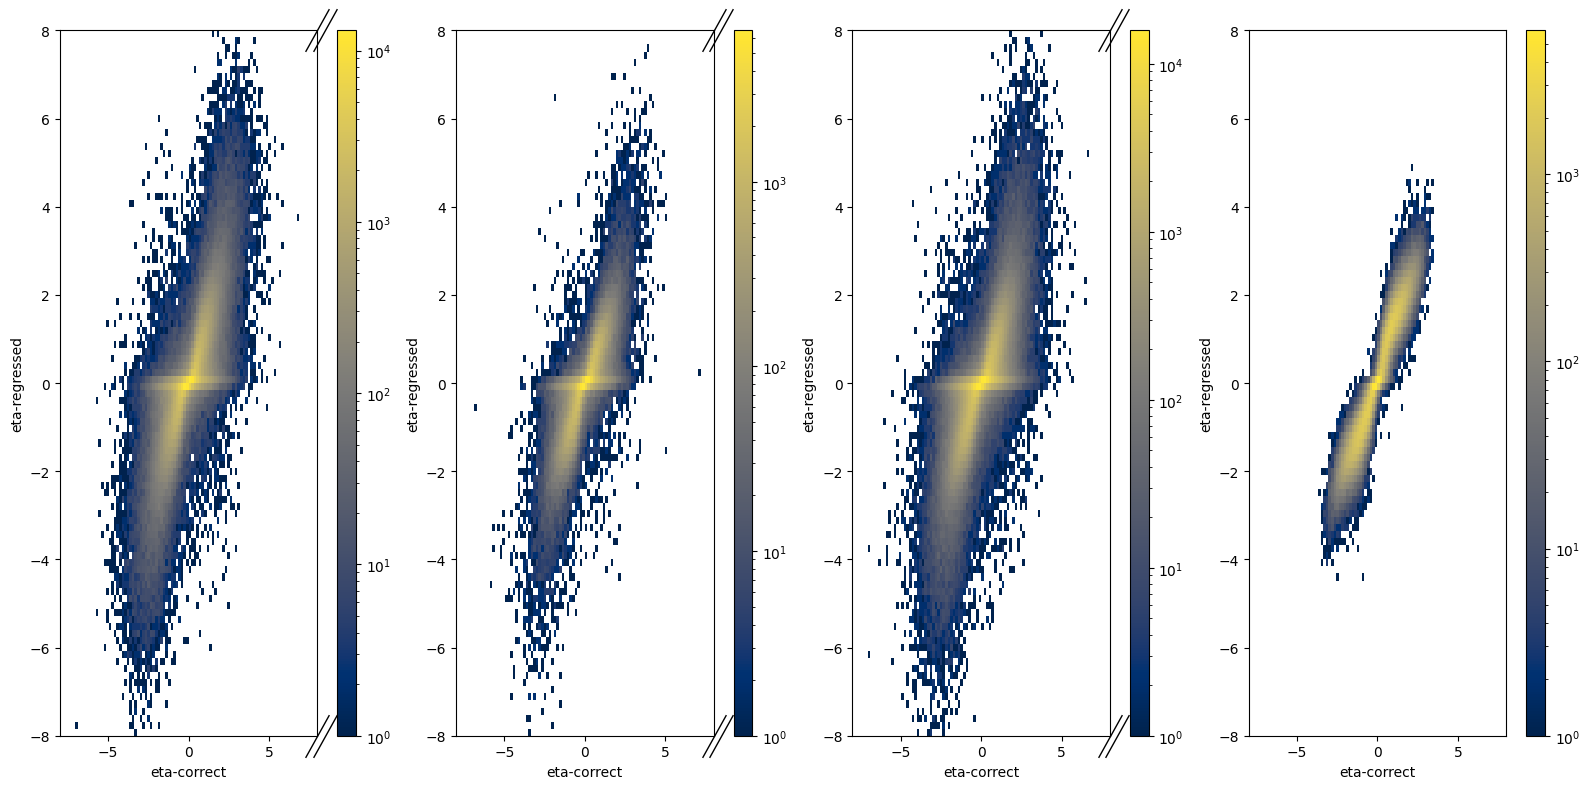

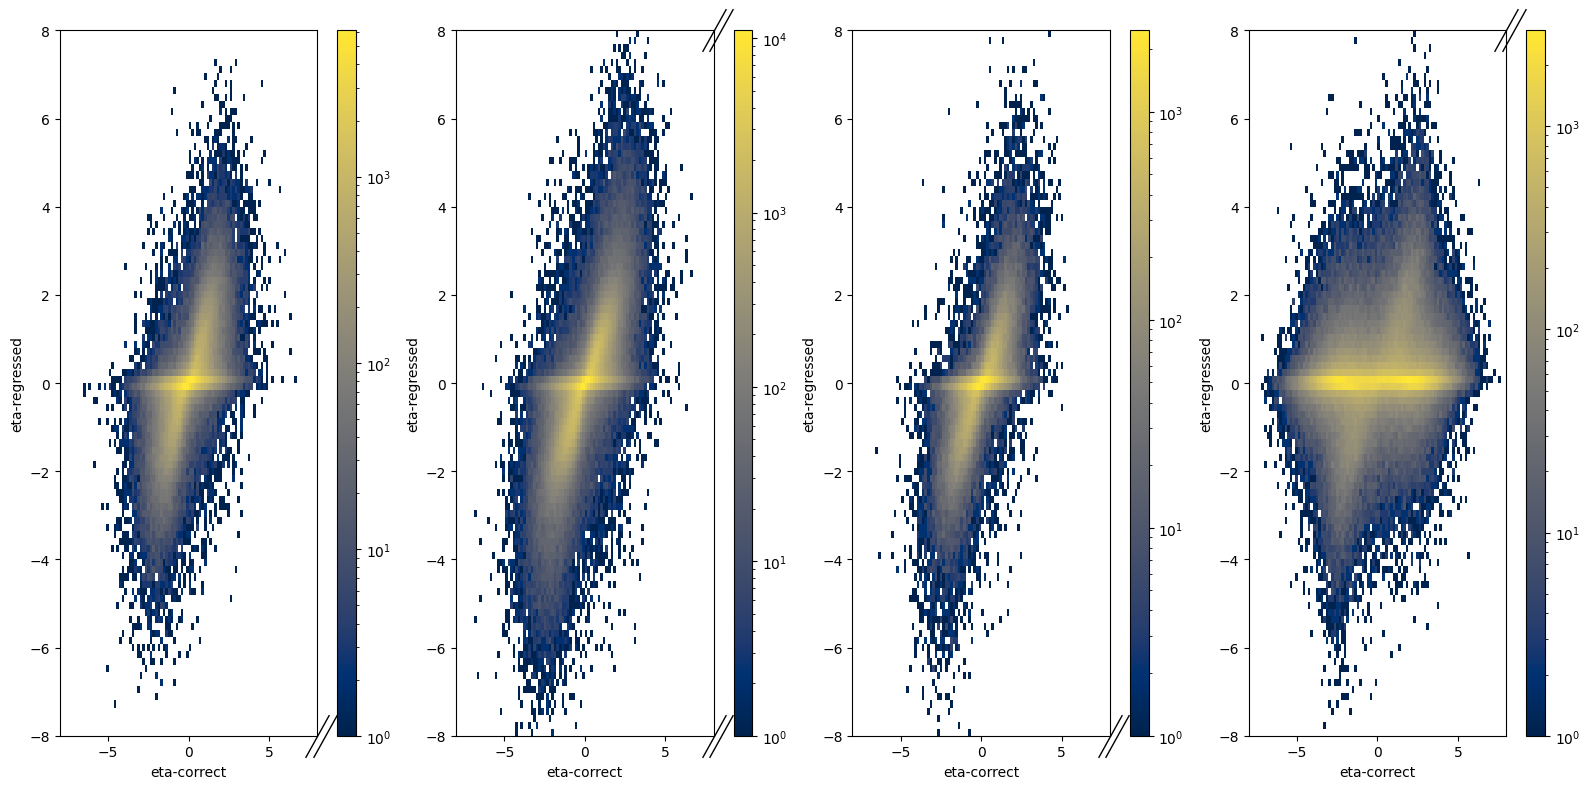

In [158]:
plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask, log=True)

plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
         ISR_mask = np.logical_not(ISR_mask), log=True)

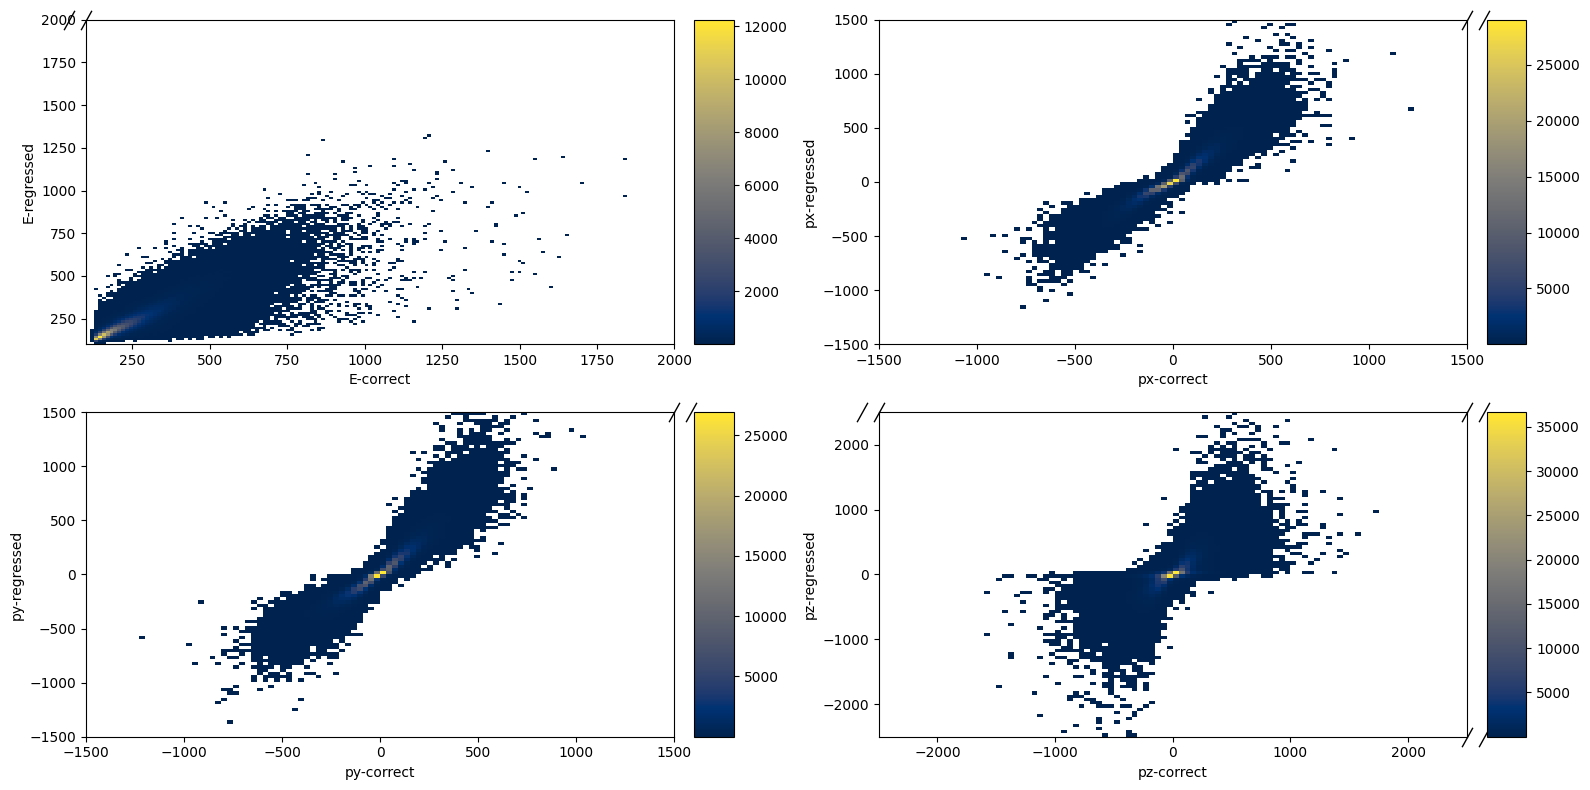

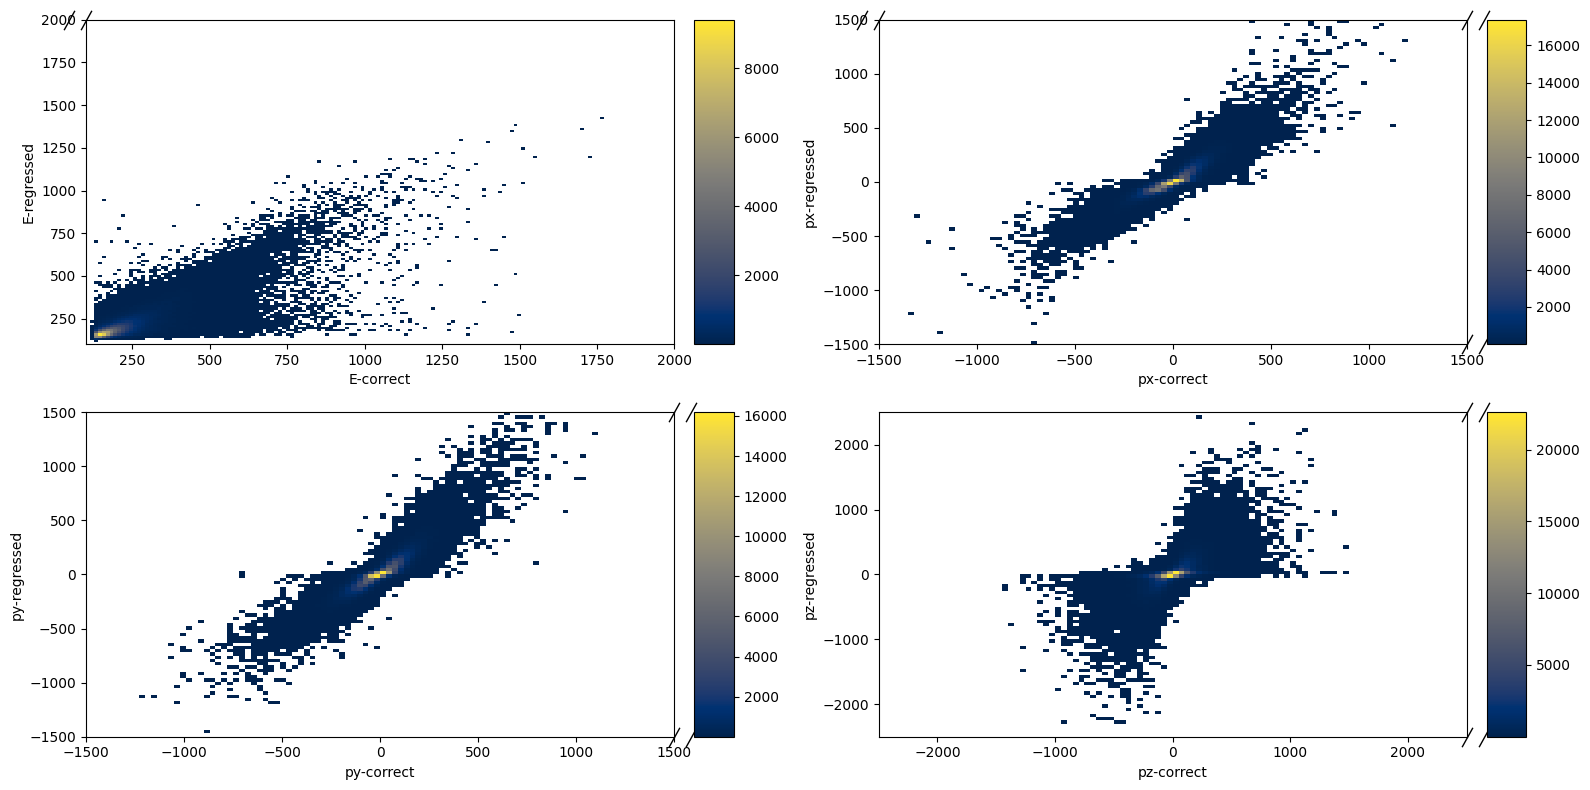

In [159]:
plot_particle(higgsCorrect, higgs, particle_mask = higgs_mask)

plot_particle(higgsCorrect, higgs, particle_mask = np.logical_not(higgs_mask))

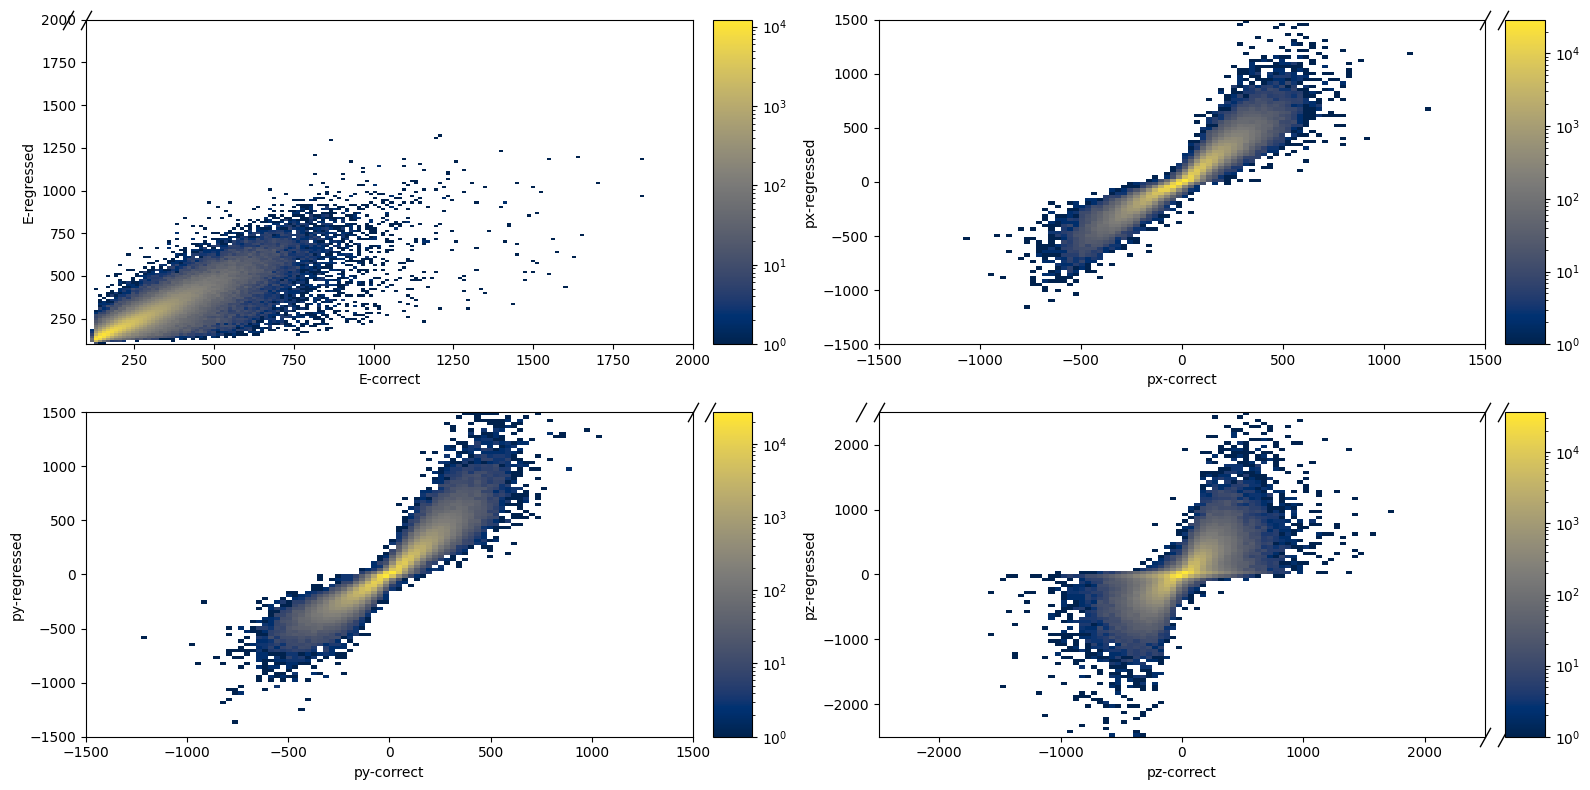

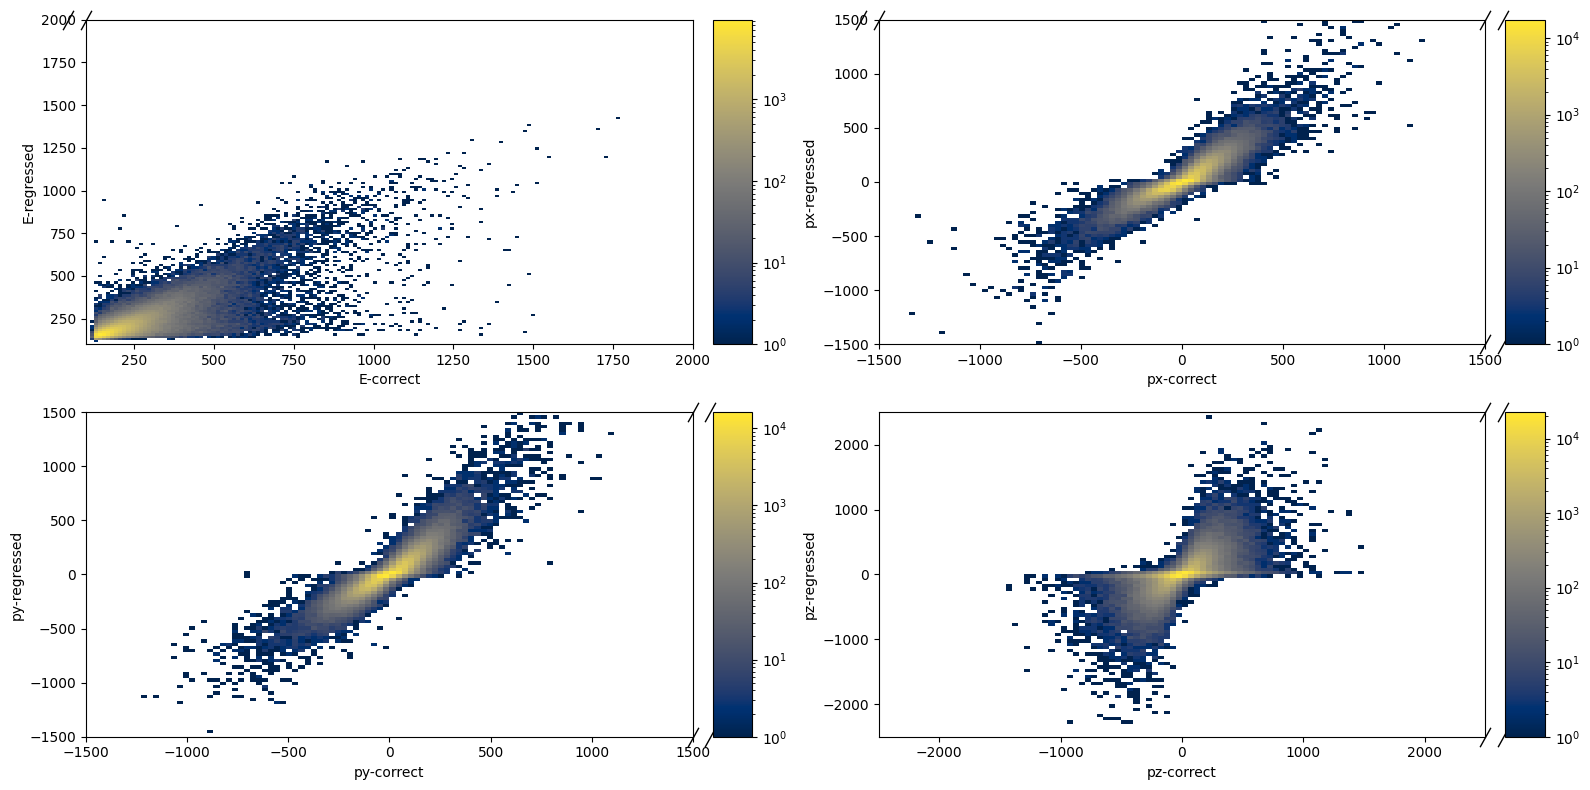

In [160]:
plot_particle(higgsCorrect, higgs, particle_mask = higgs_mask, log=True)

plot_particle(higgsCorrect, higgs, particle_mask = np.logical_not(higgs_mask), log=True)

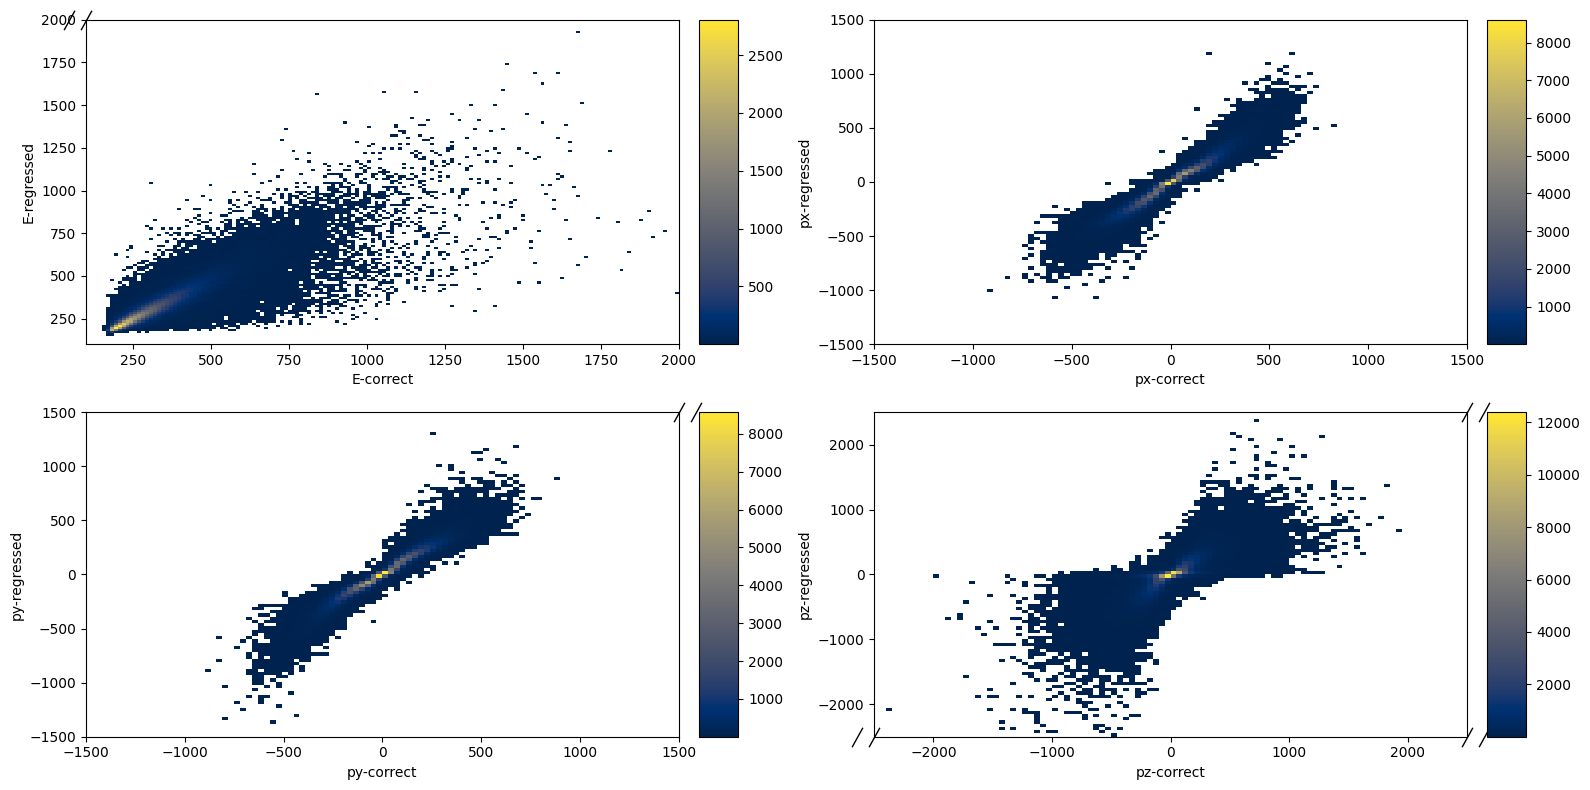

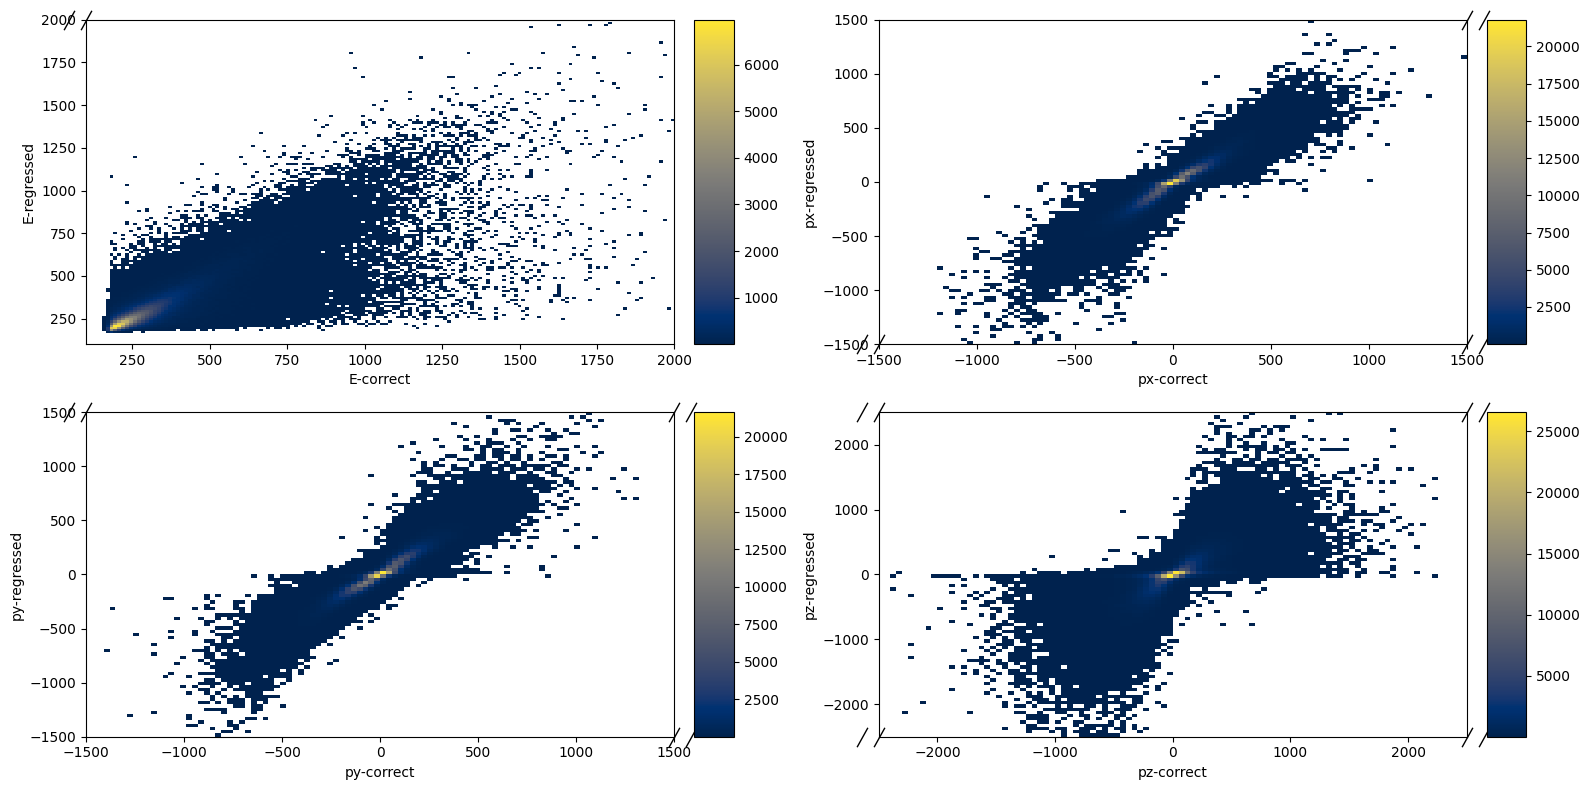

In [161]:
plot_particle(thadCorrect, thad, particle_mask = hadt_mask)

plot_particle(thadCorrect, thad, particle_mask = np.logical_not(hadt_mask))

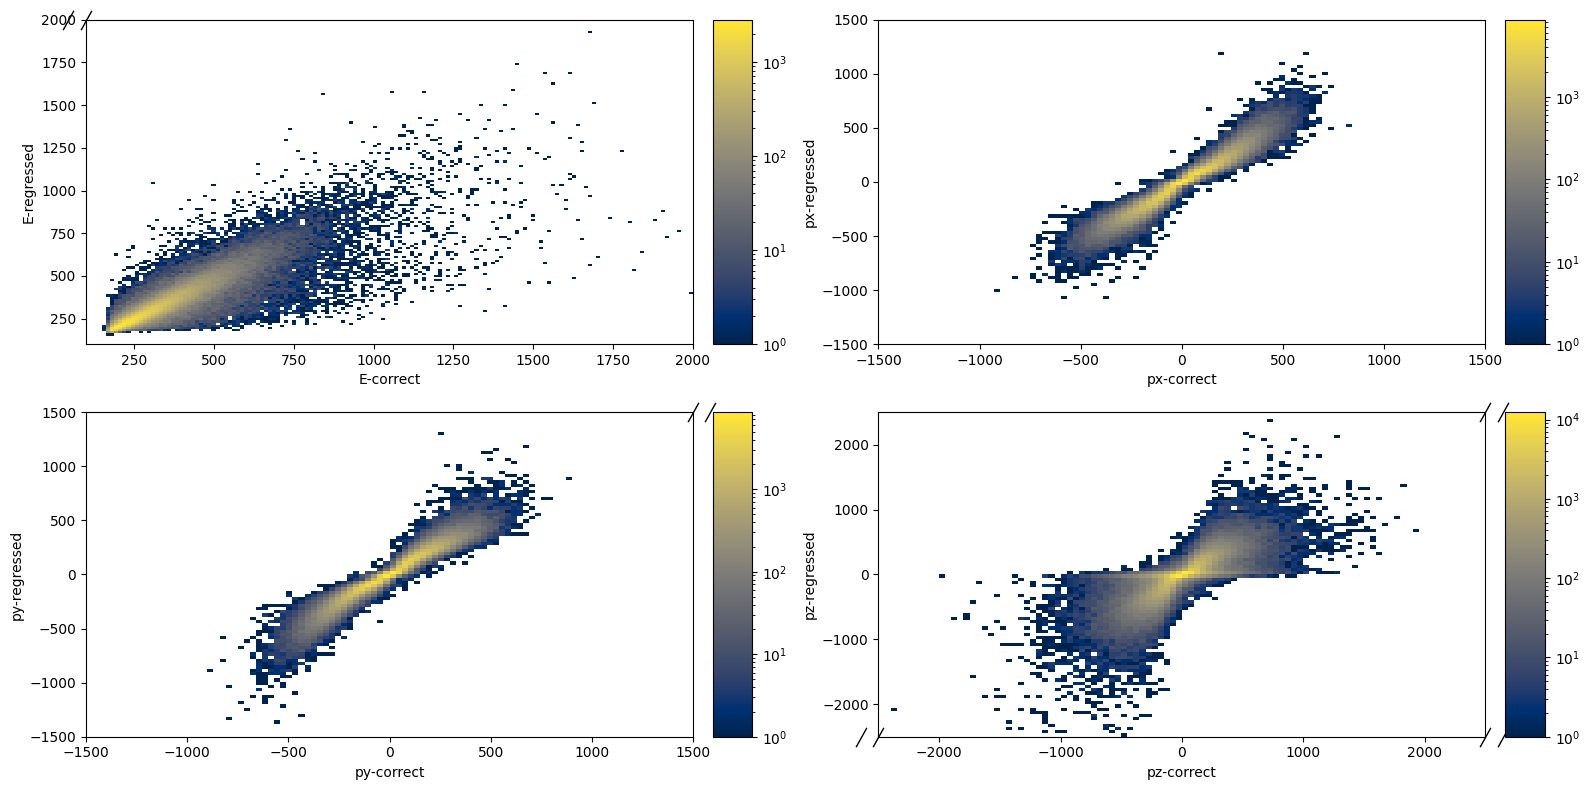

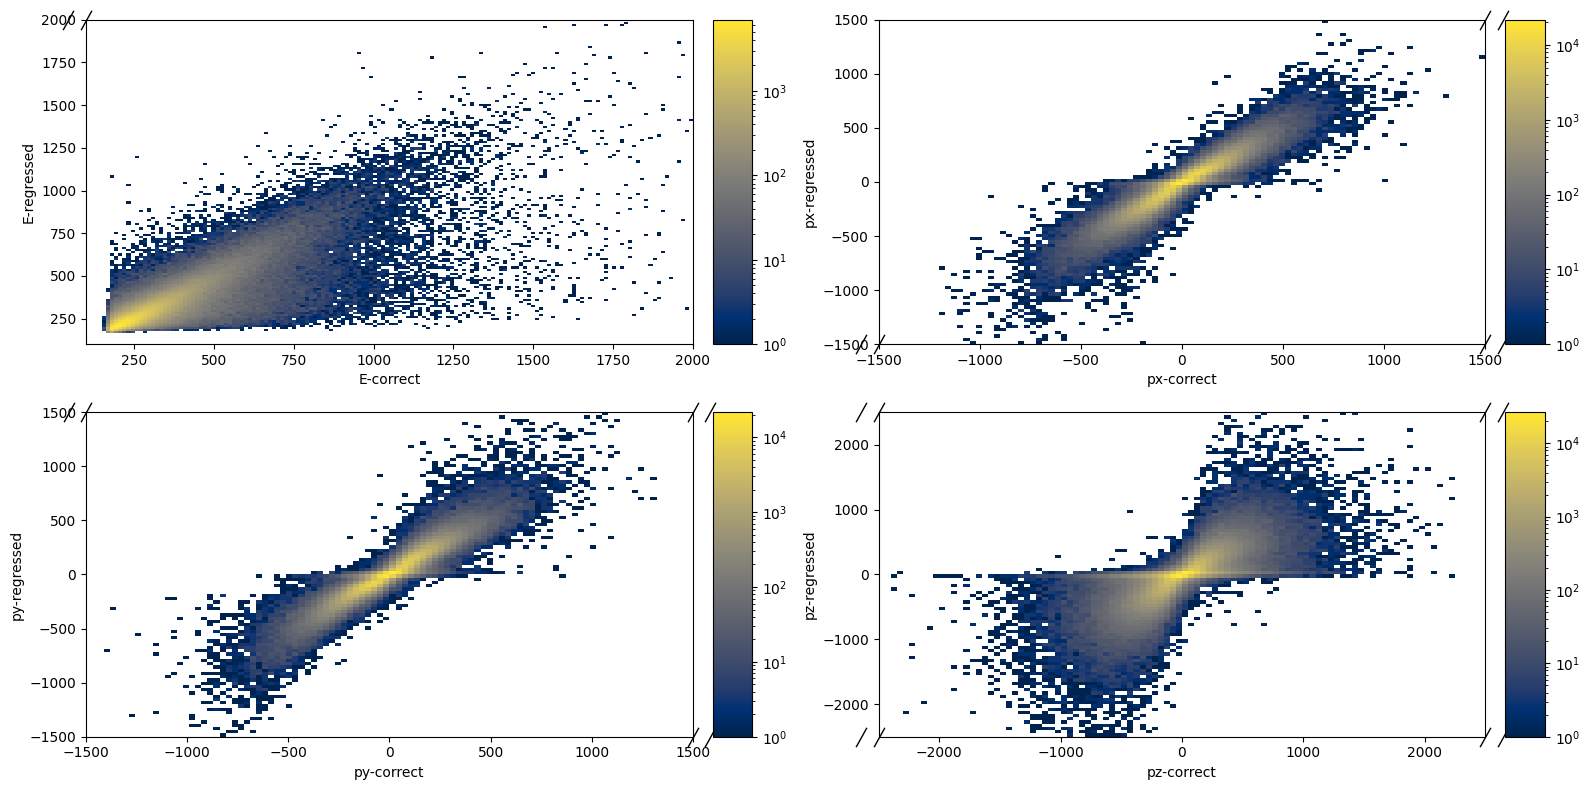

In [162]:
plot_particle(thadCorrect, thad, particle_mask = hadt_mask, log=True)

plot_particle(thadCorrect, thad, particle_mask = np.logical_not(hadt_mask), log=True)

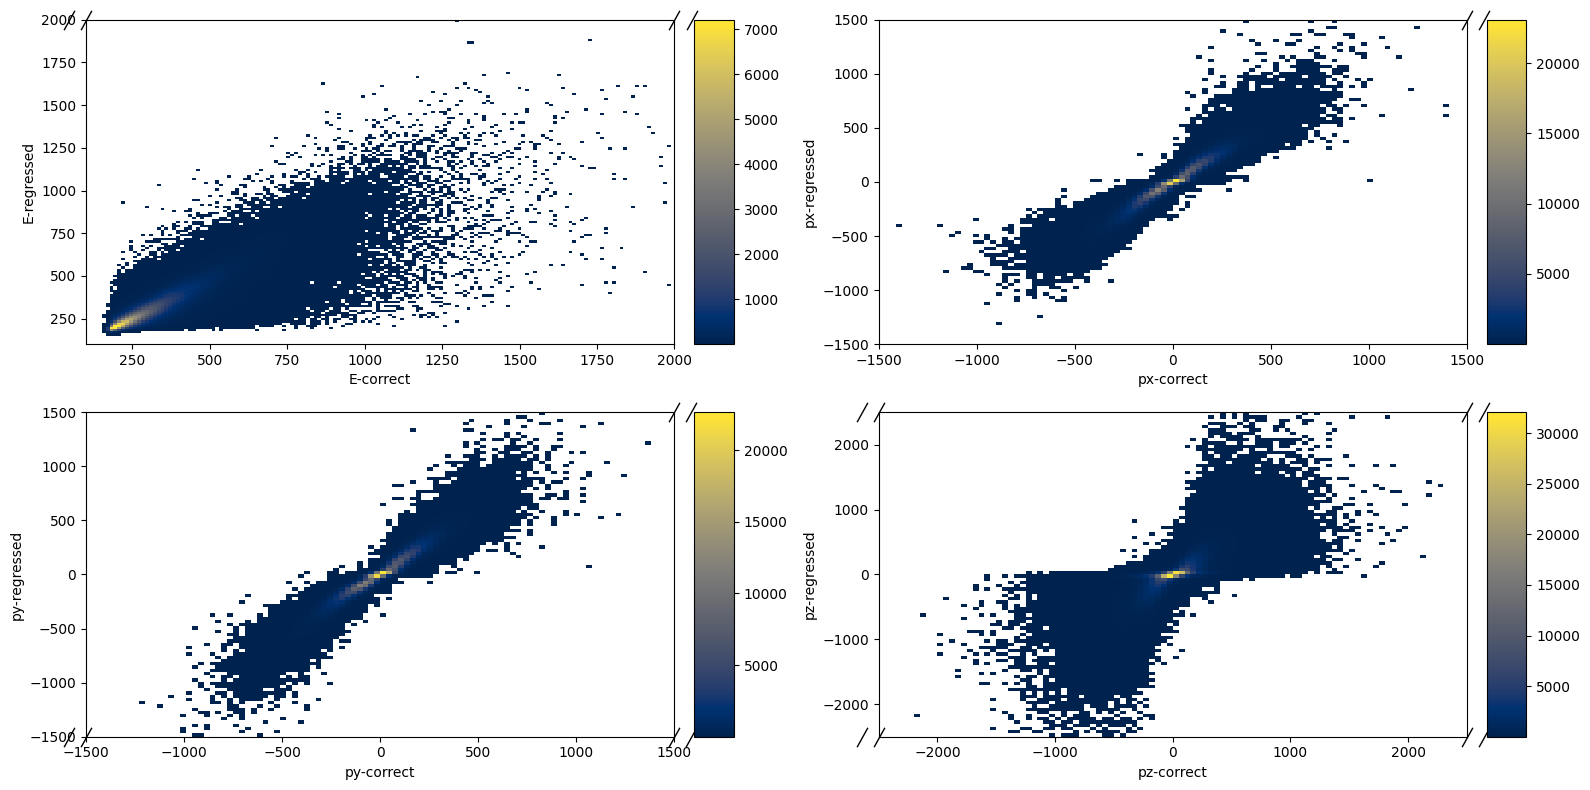

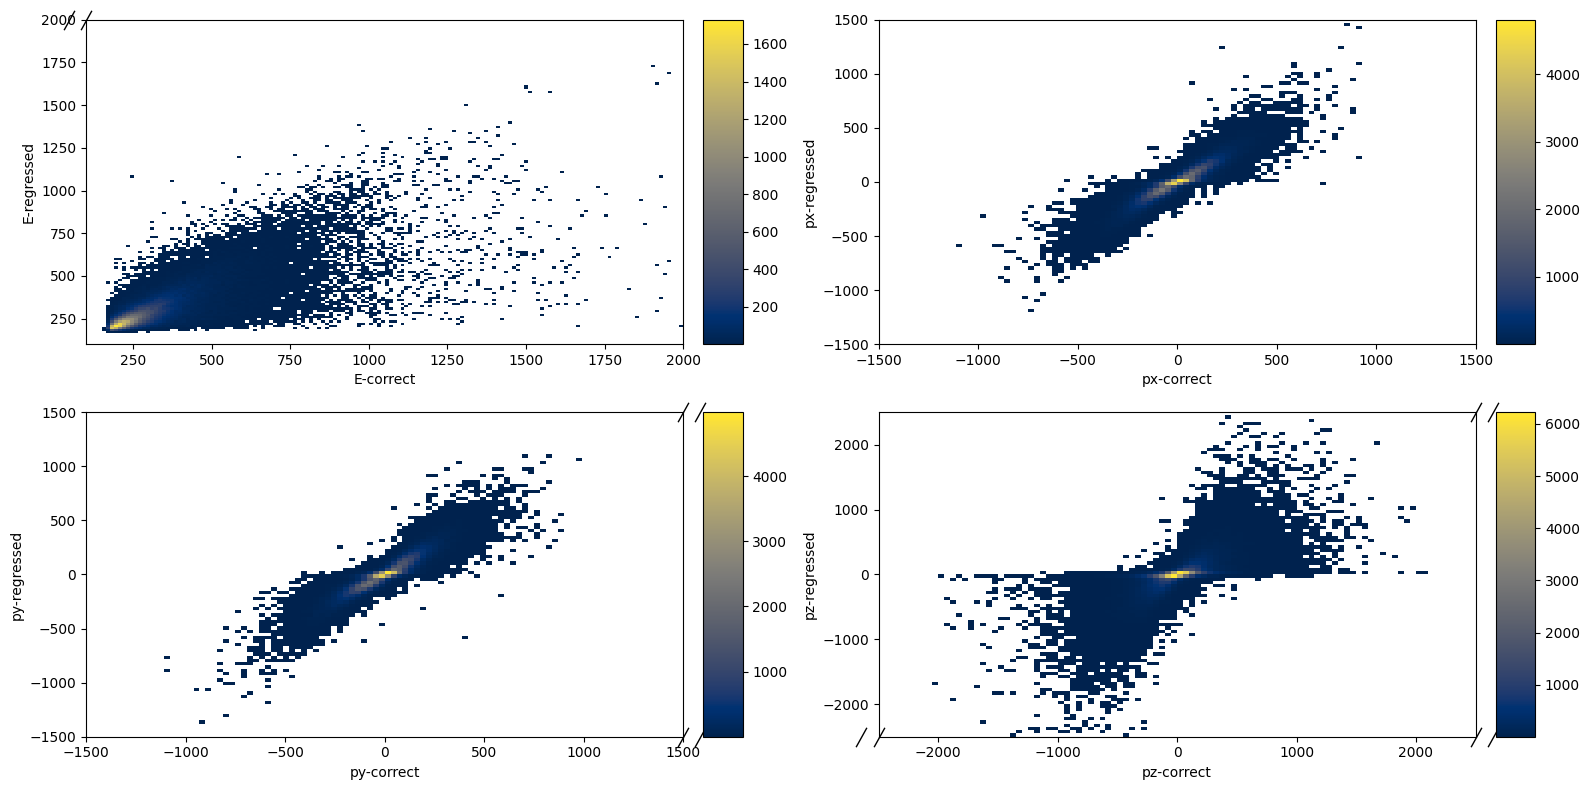

In [163]:
plot_particle(tlepCorrect, tlep, particle_mask = tlep_mask)

plot_particle(tlepCorrect, tlep, particle_mask = np.logical_not(tlep_mask))

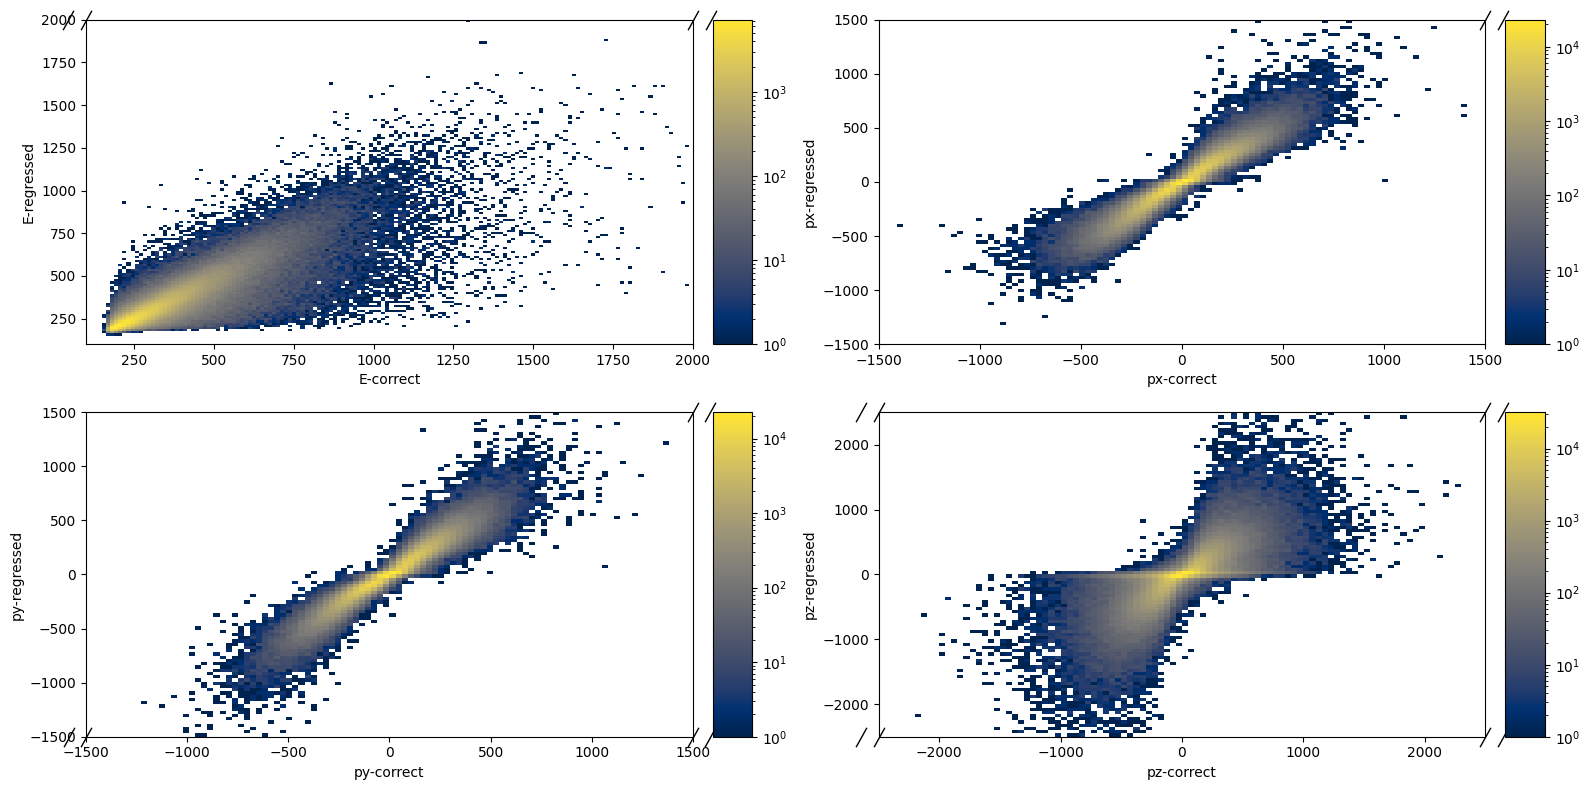

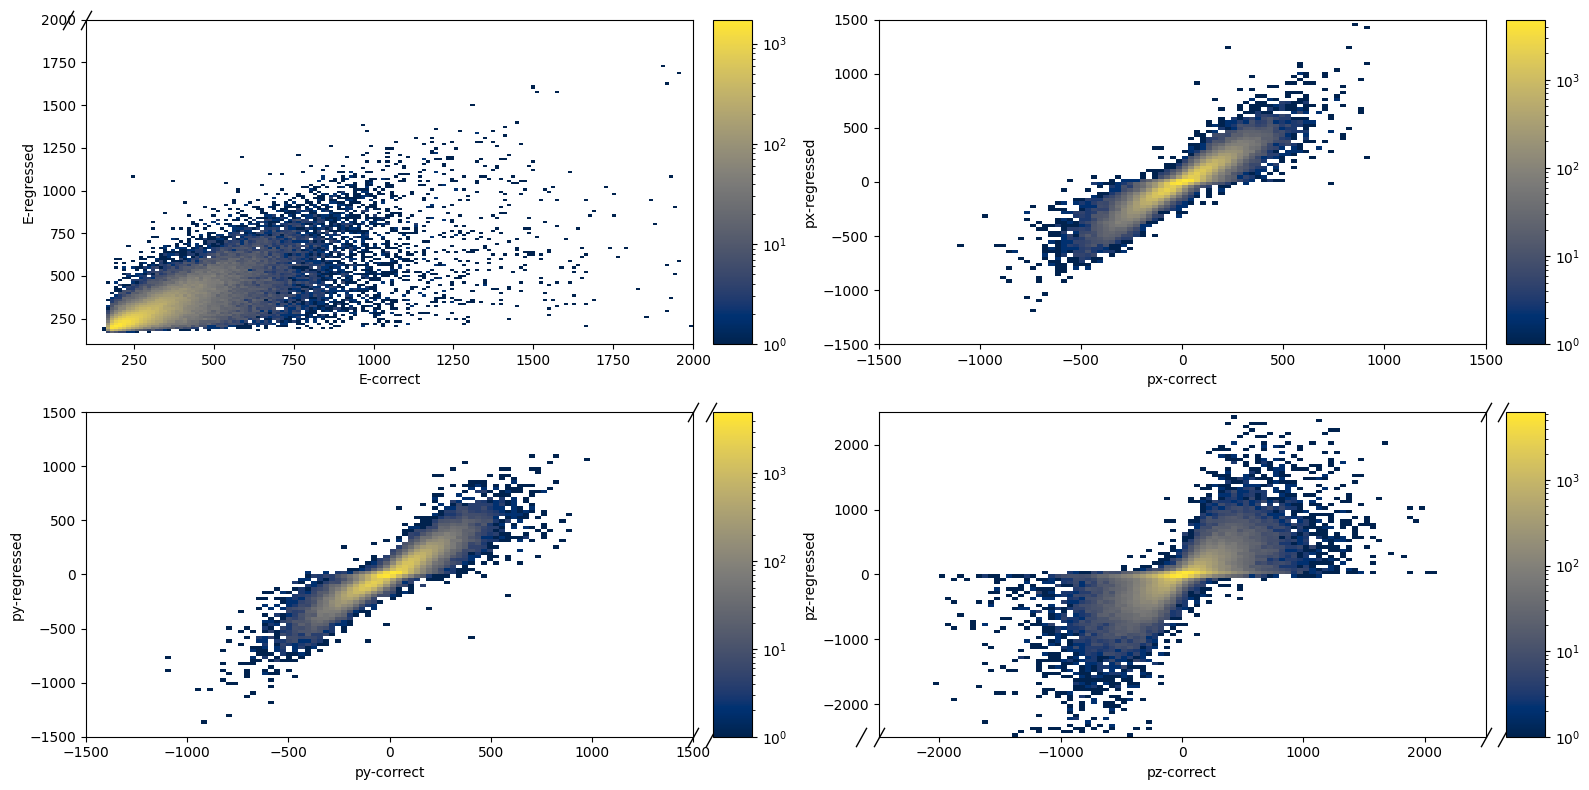

In [164]:
plot_particle(tlepCorrect, tlep, particle_mask = tlep_mask, log=True)

plot_particle(tlepCorrect, tlep, particle_mask = np.logical_not(tlep_mask), log=True)

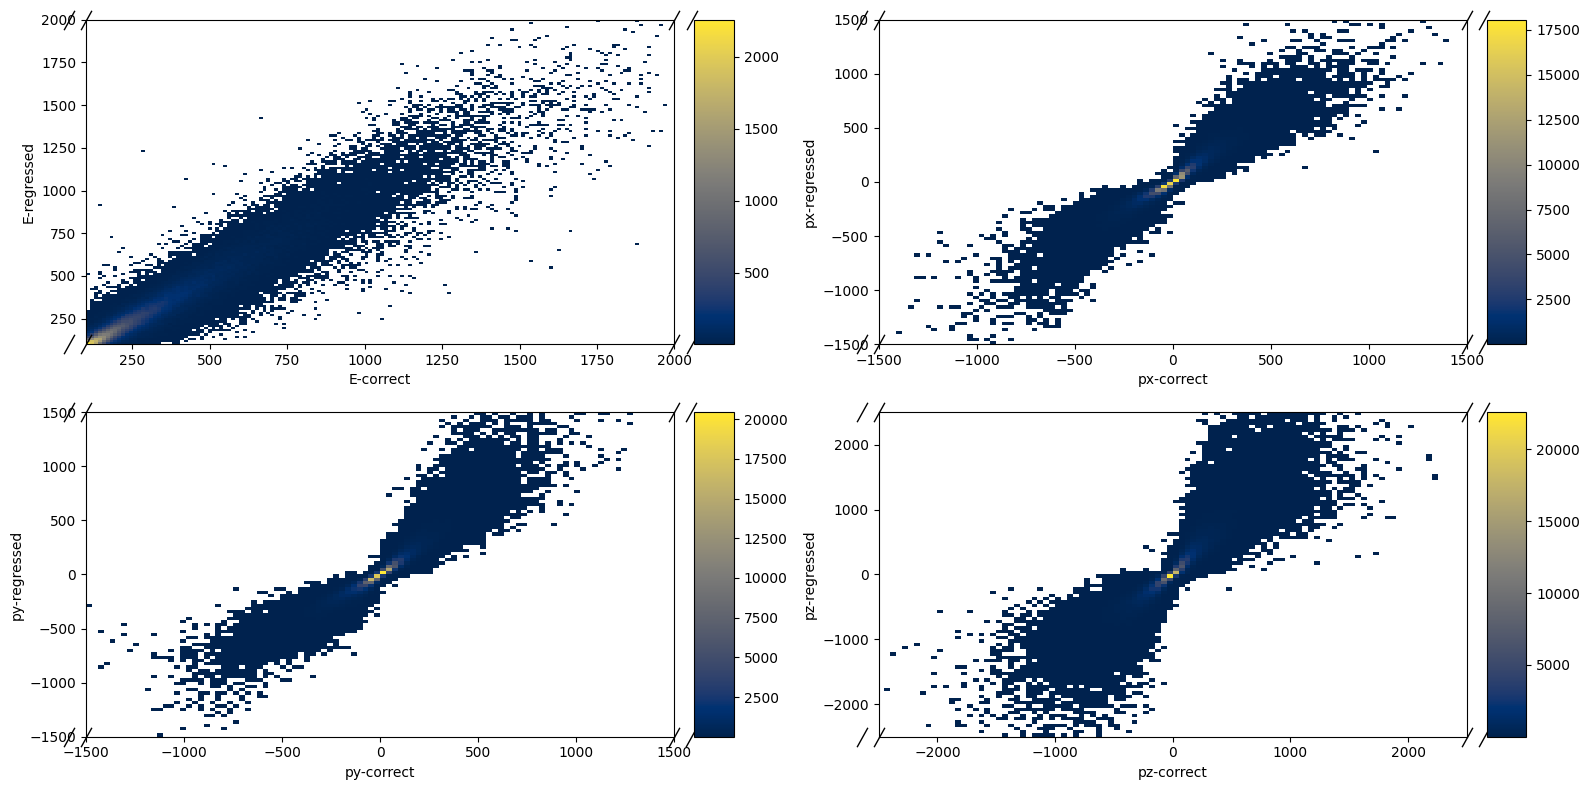

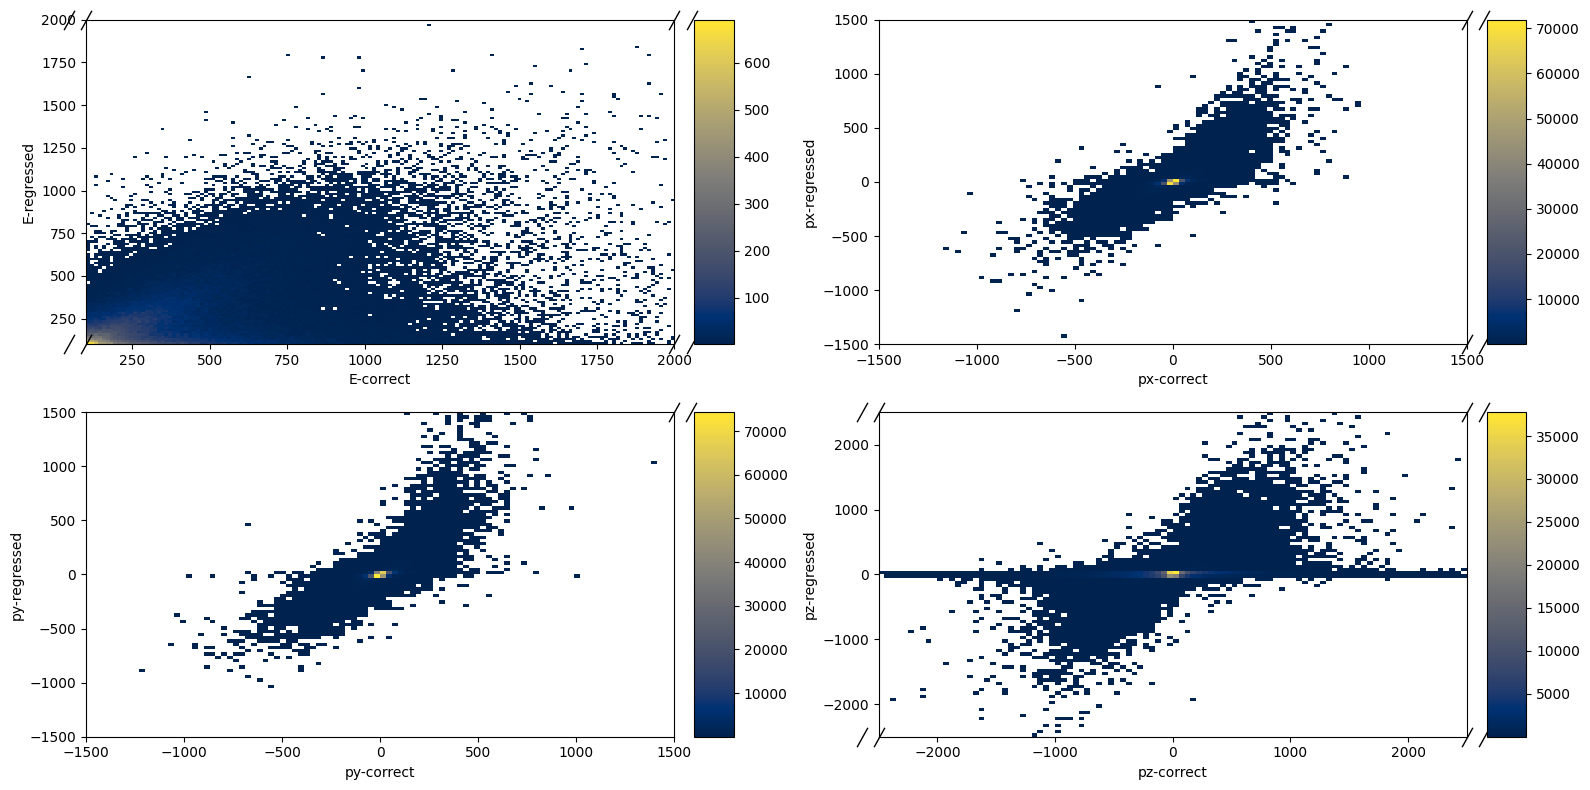

In [165]:
plot_particle(glISRCorrect, glISR, particle_mask = ISR_mask)

plot_particle(glISRCorrect, glISR, particle_mask = np.logical_not(ISR_mask))

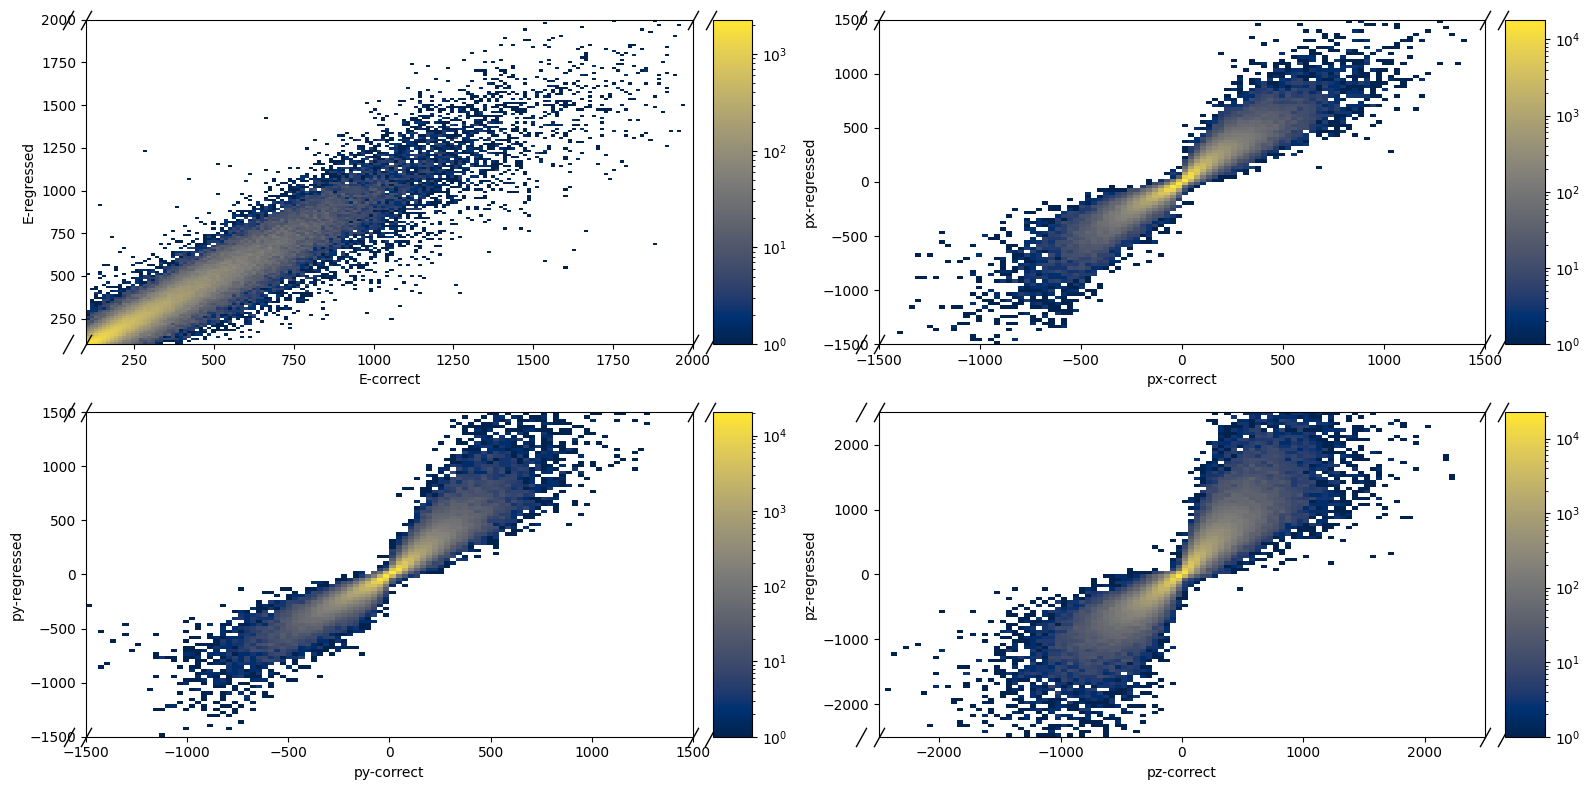

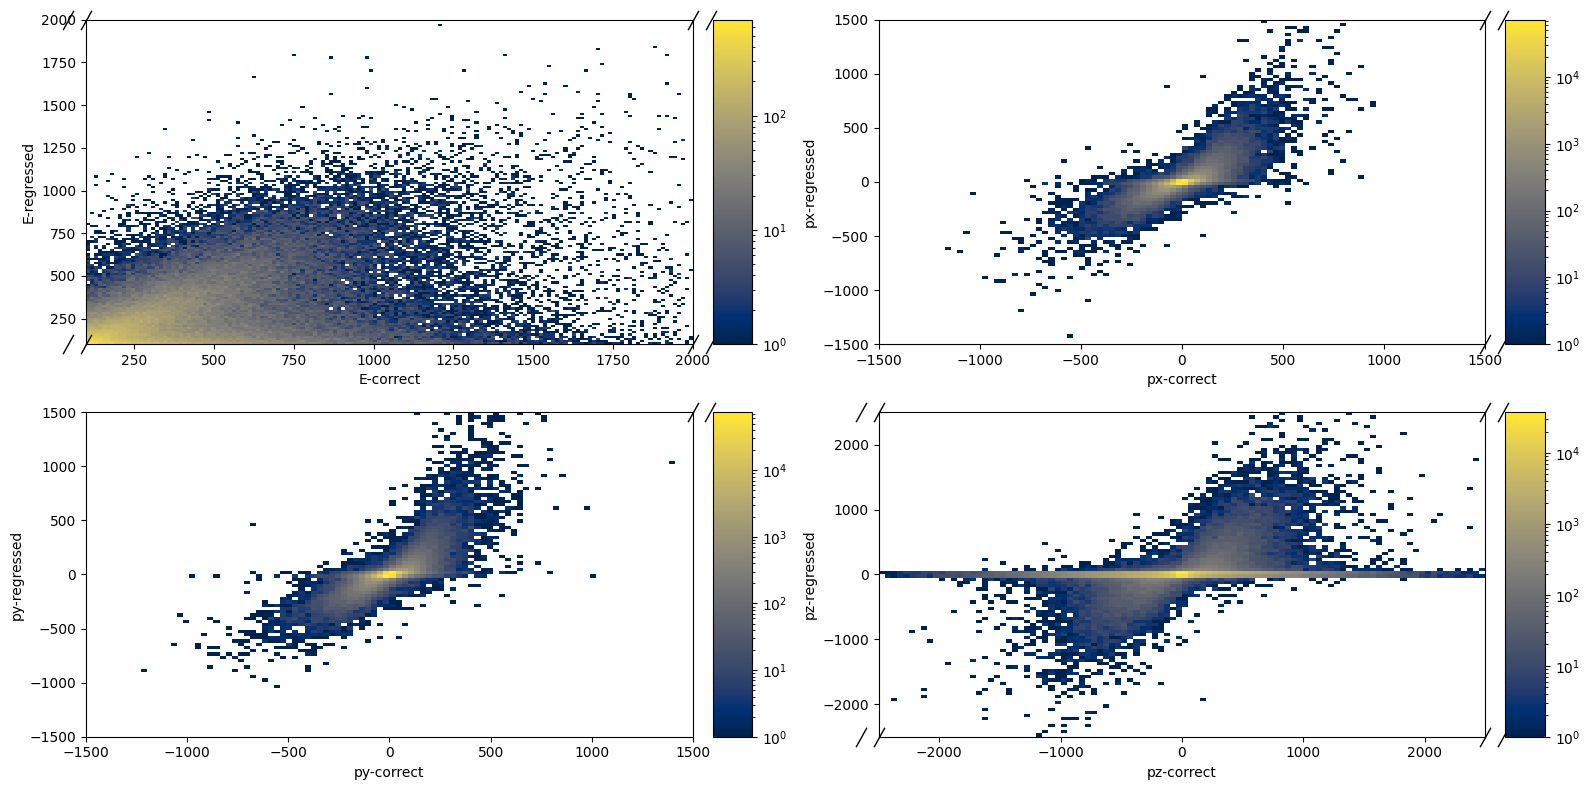

In [166]:
plot_particle(glISRCorrect, glISR, particle_mask = ISR_mask, log=True)

plot_particle(glISRCorrect, glISR, particle_mask = np.logical_not(ISR_mask), log=True)

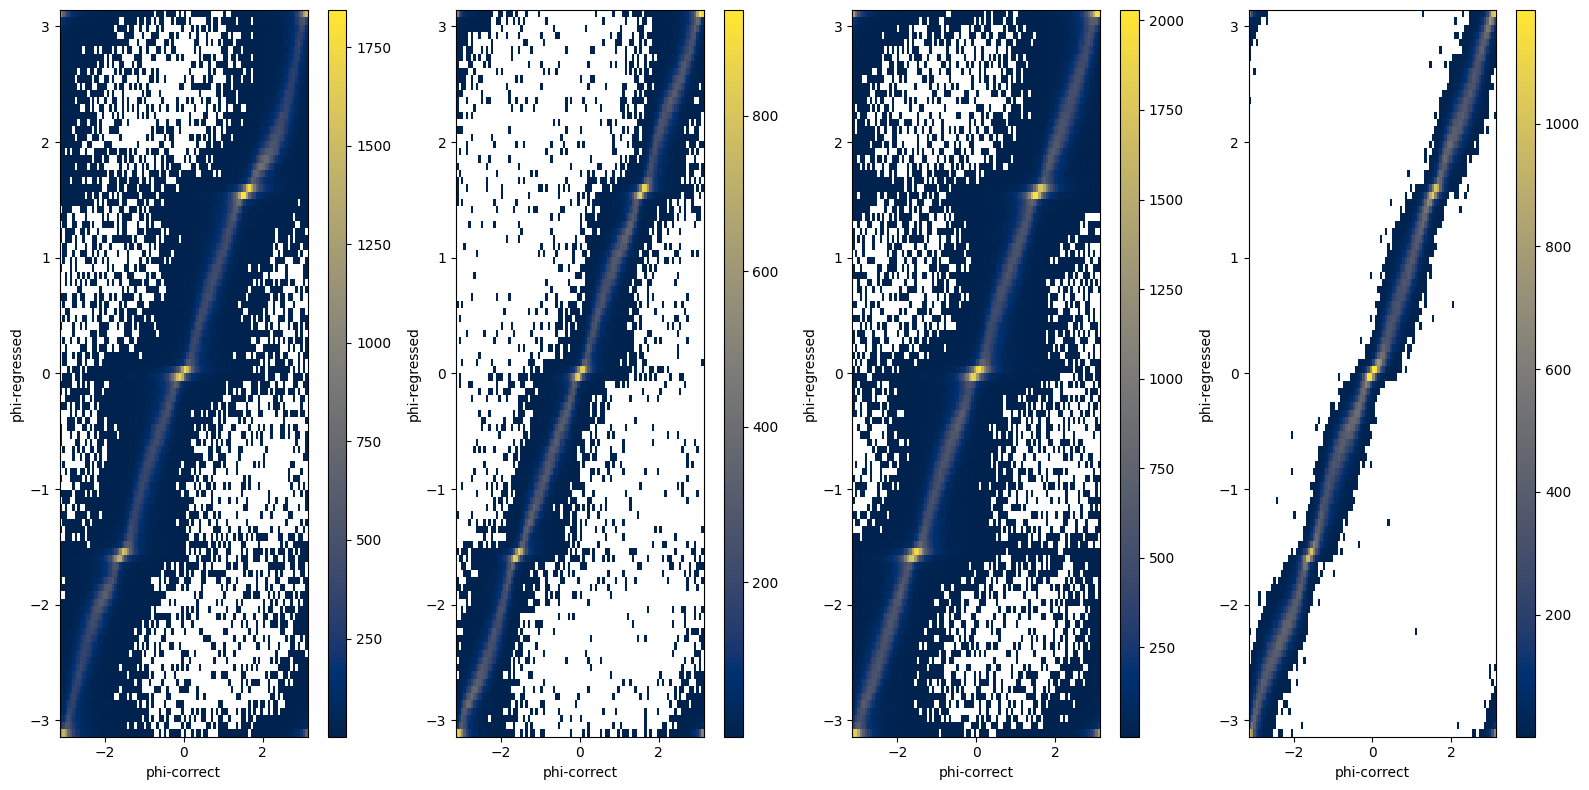

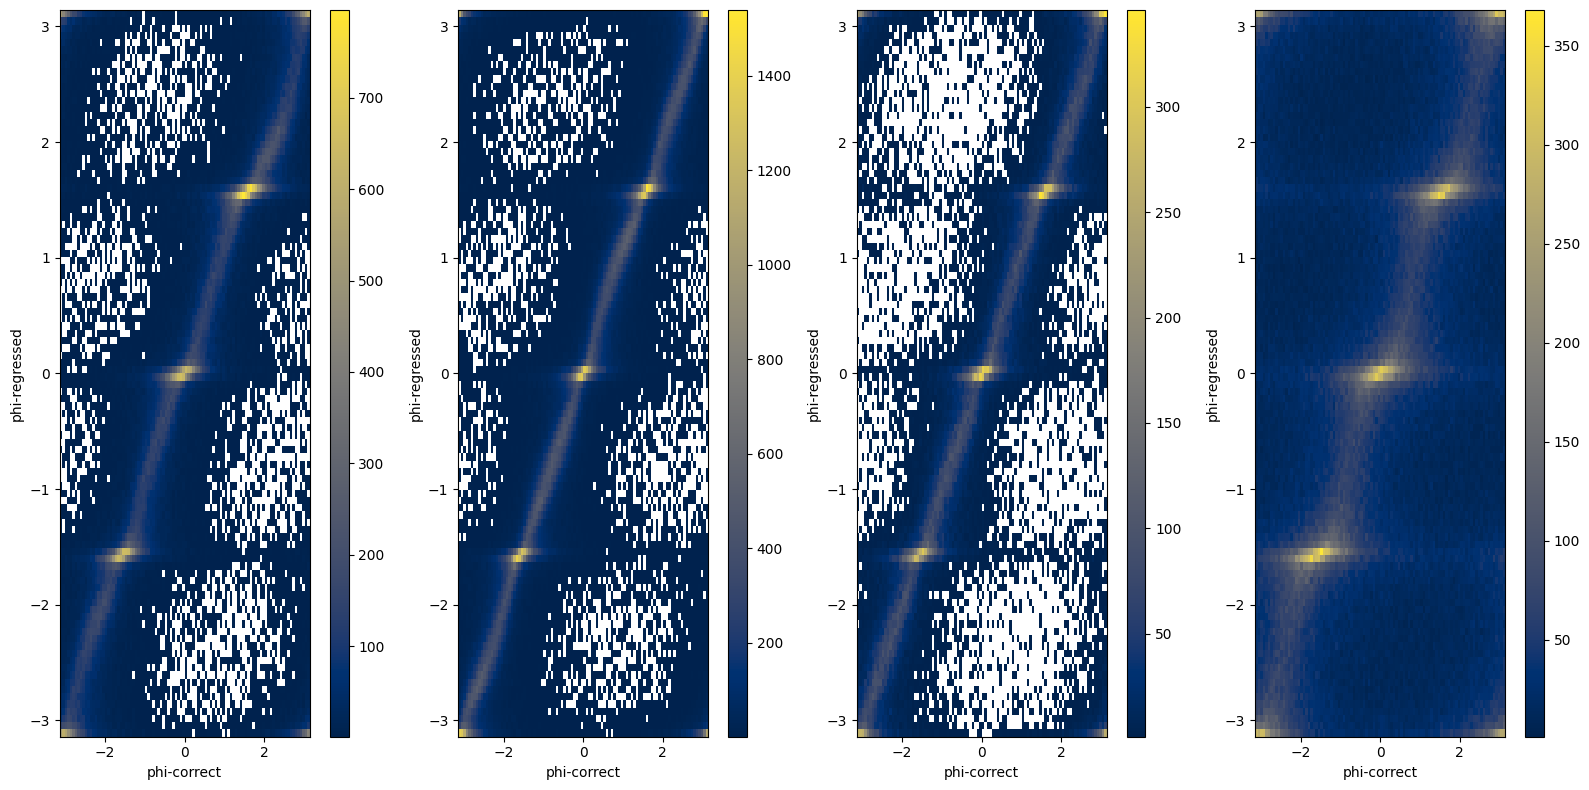

In [167]:
plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask)

plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
         ISR_mask = np.logical_not(ISR_mask))

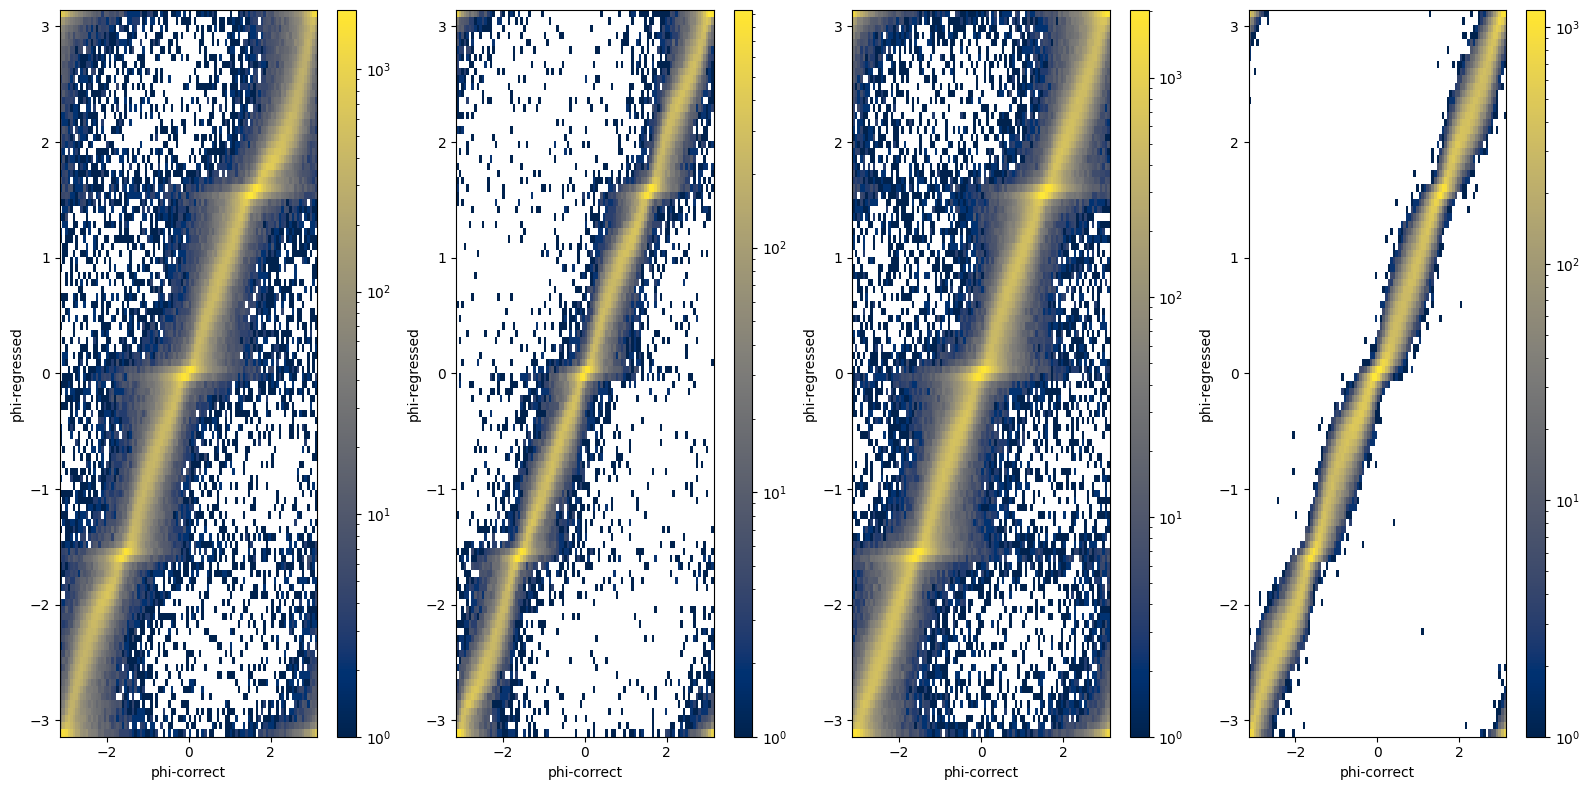

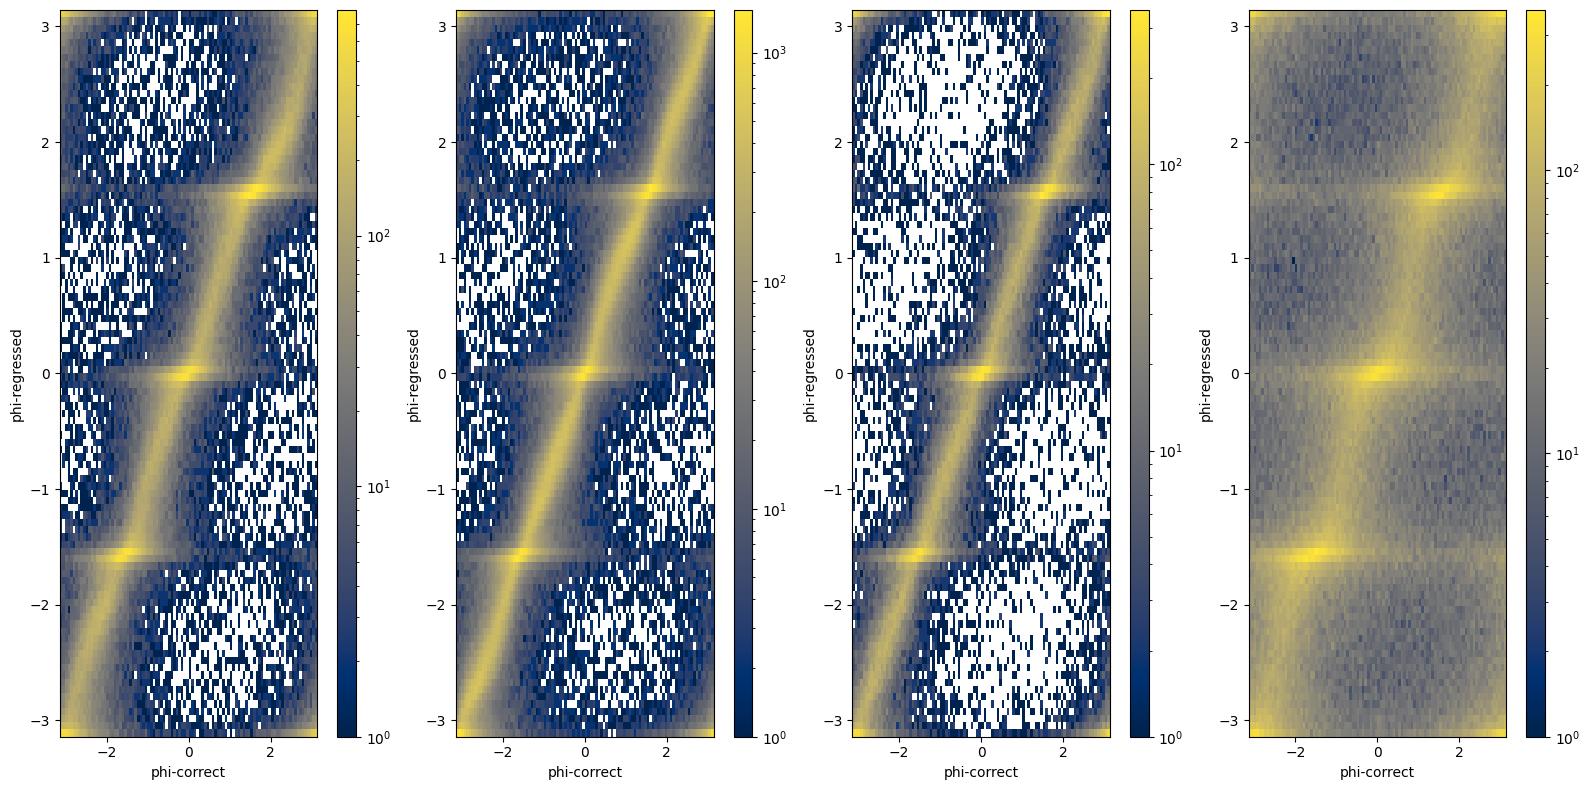

In [168]:
plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask, log=True)

plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
         ISR_mask = np.logical_not(ISR_mask), log=True)

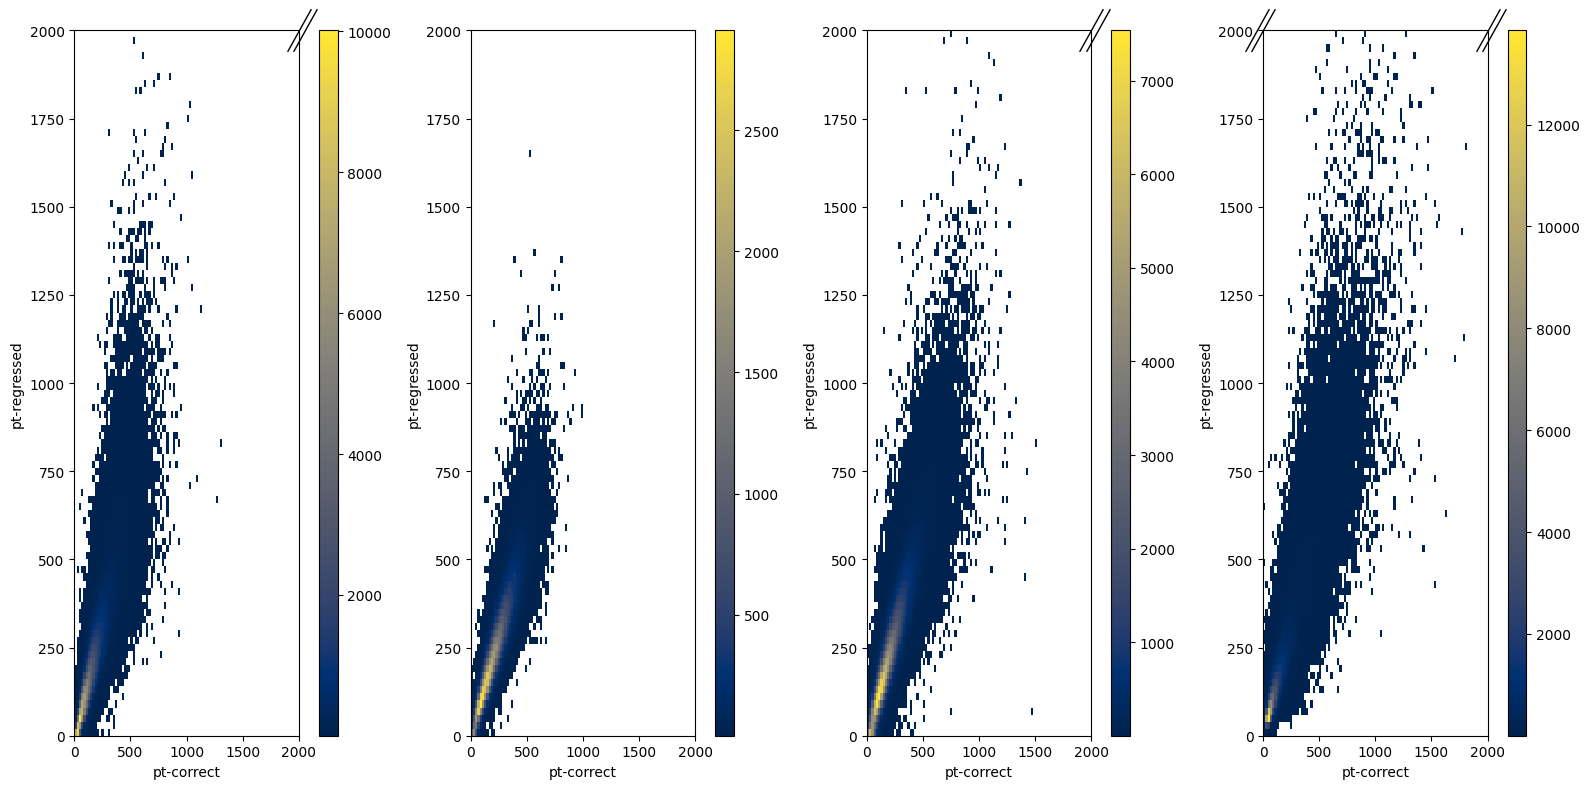

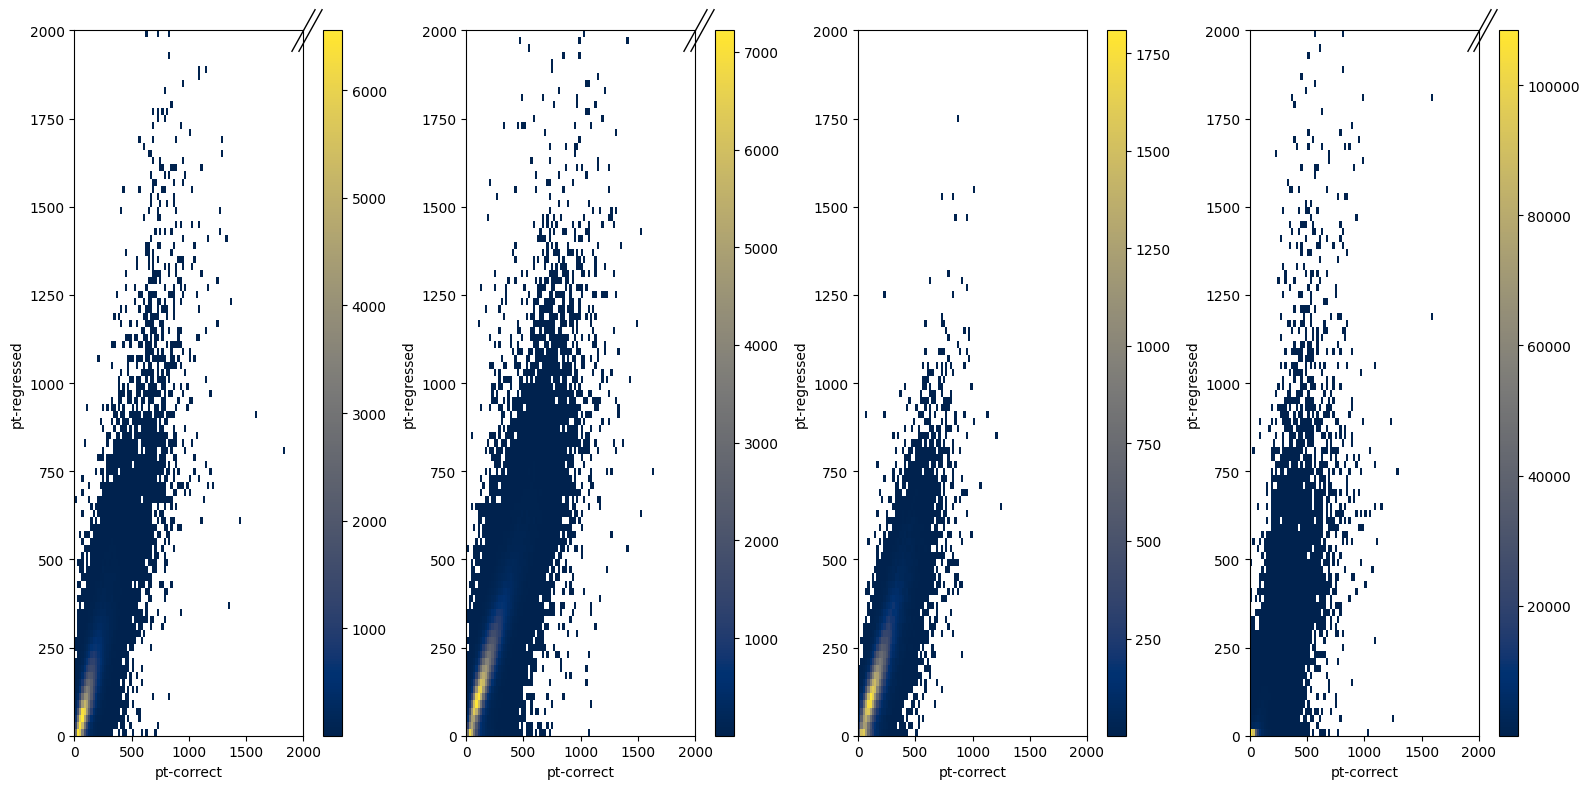

In [169]:
plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask)

plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
       ISR_mask = np.logical_not(ISR_mask))

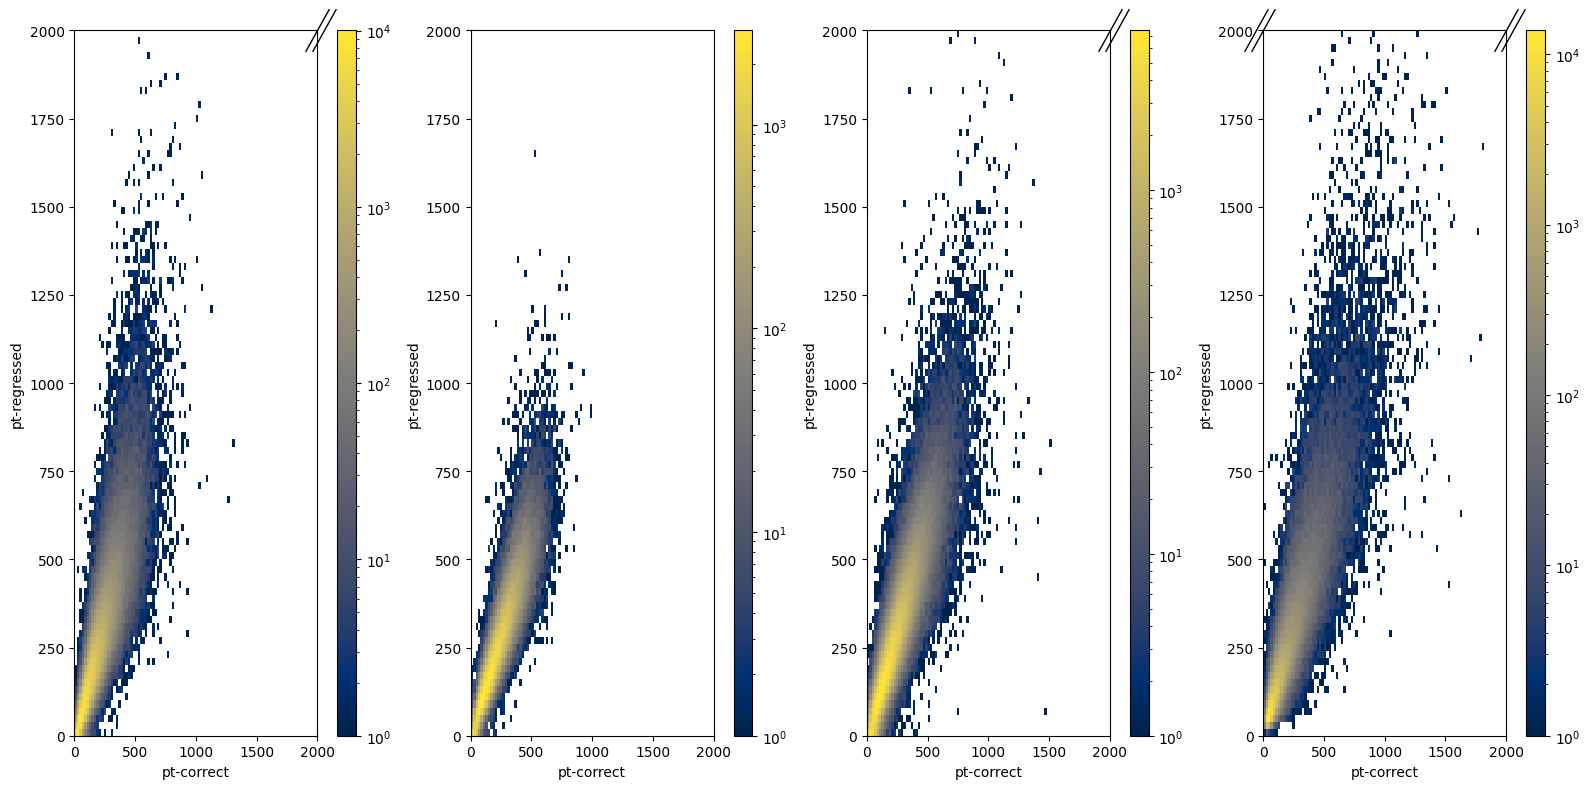

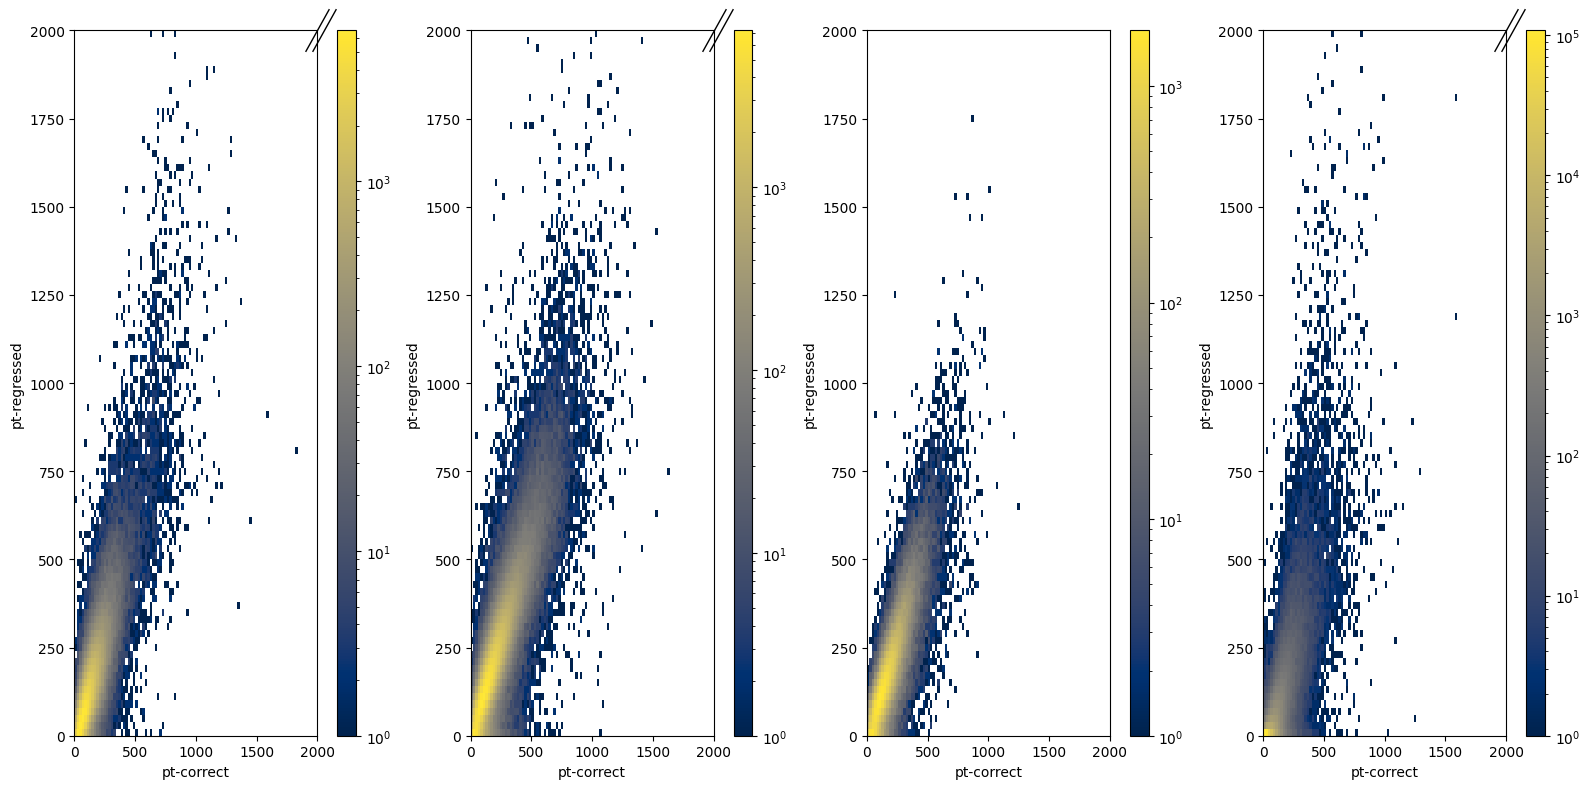

In [170]:
plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask, log=True)

plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
       ISR_mask = np.logical_not(ISR_mask), log=True)

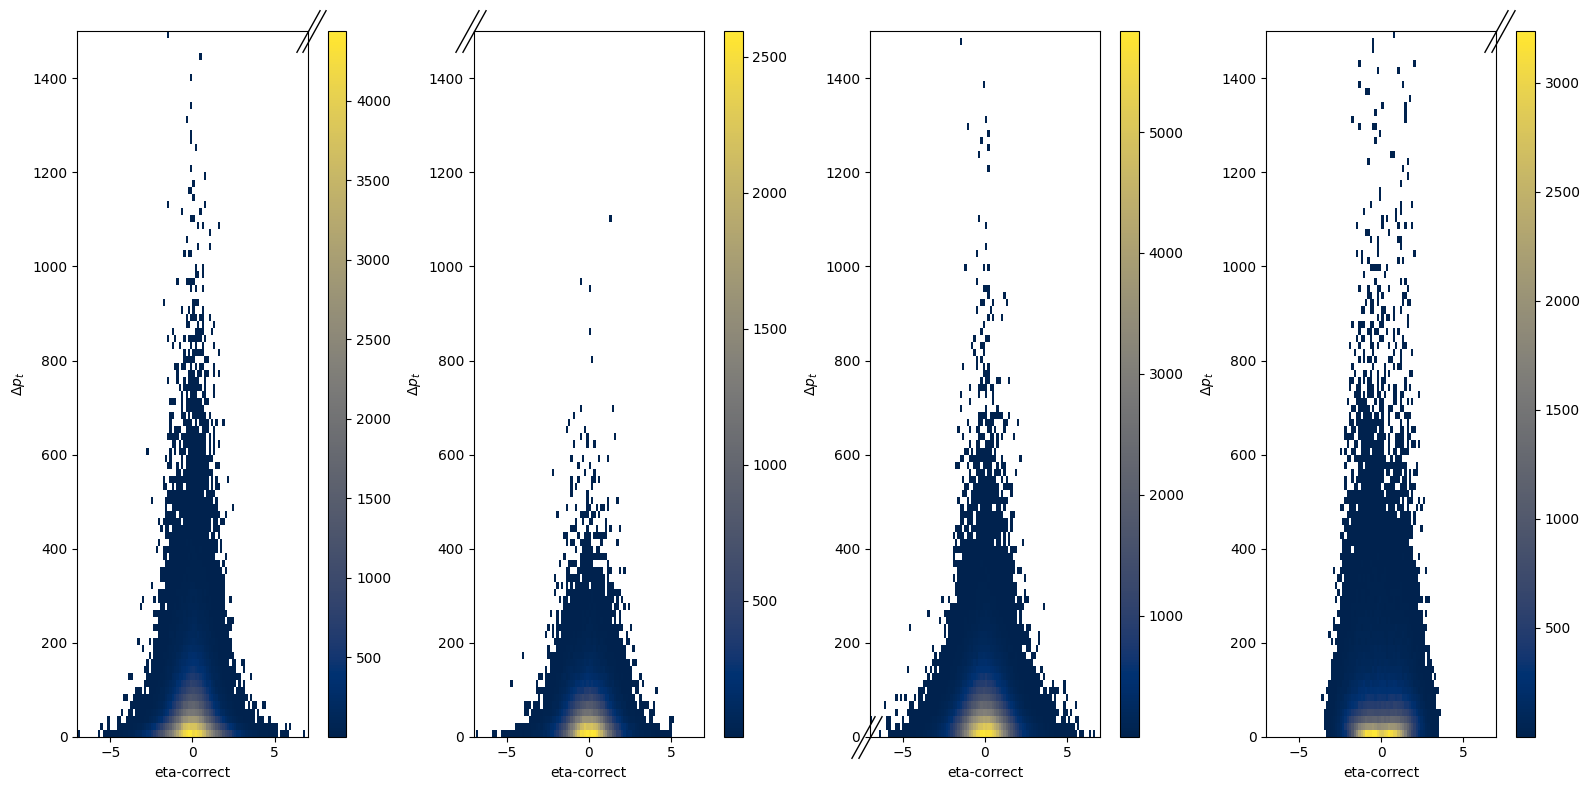

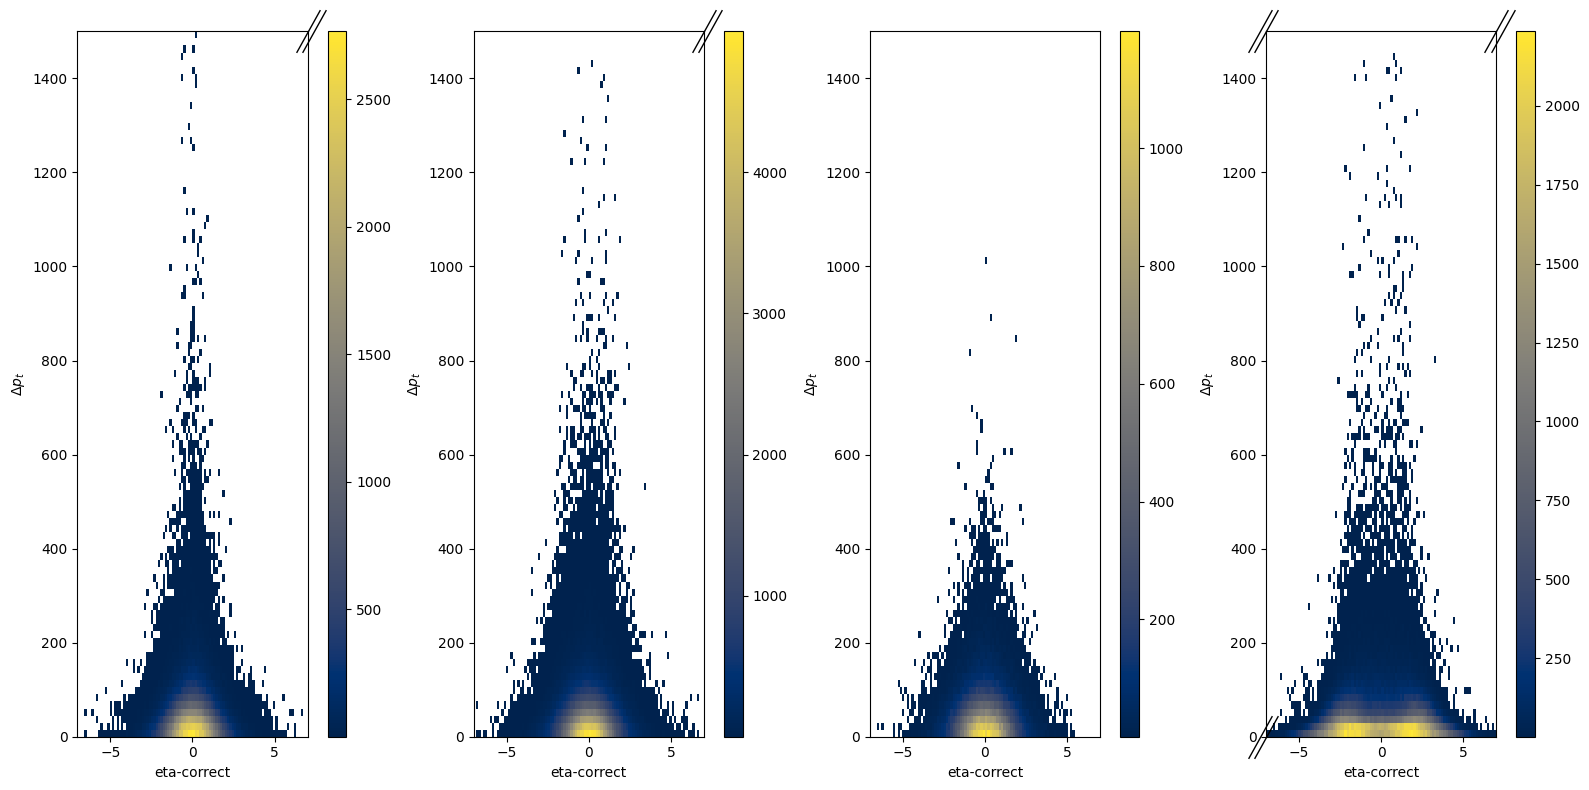

In [171]:
plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask)

plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
        ISR_mask = np.logical_not(ISR_mask))

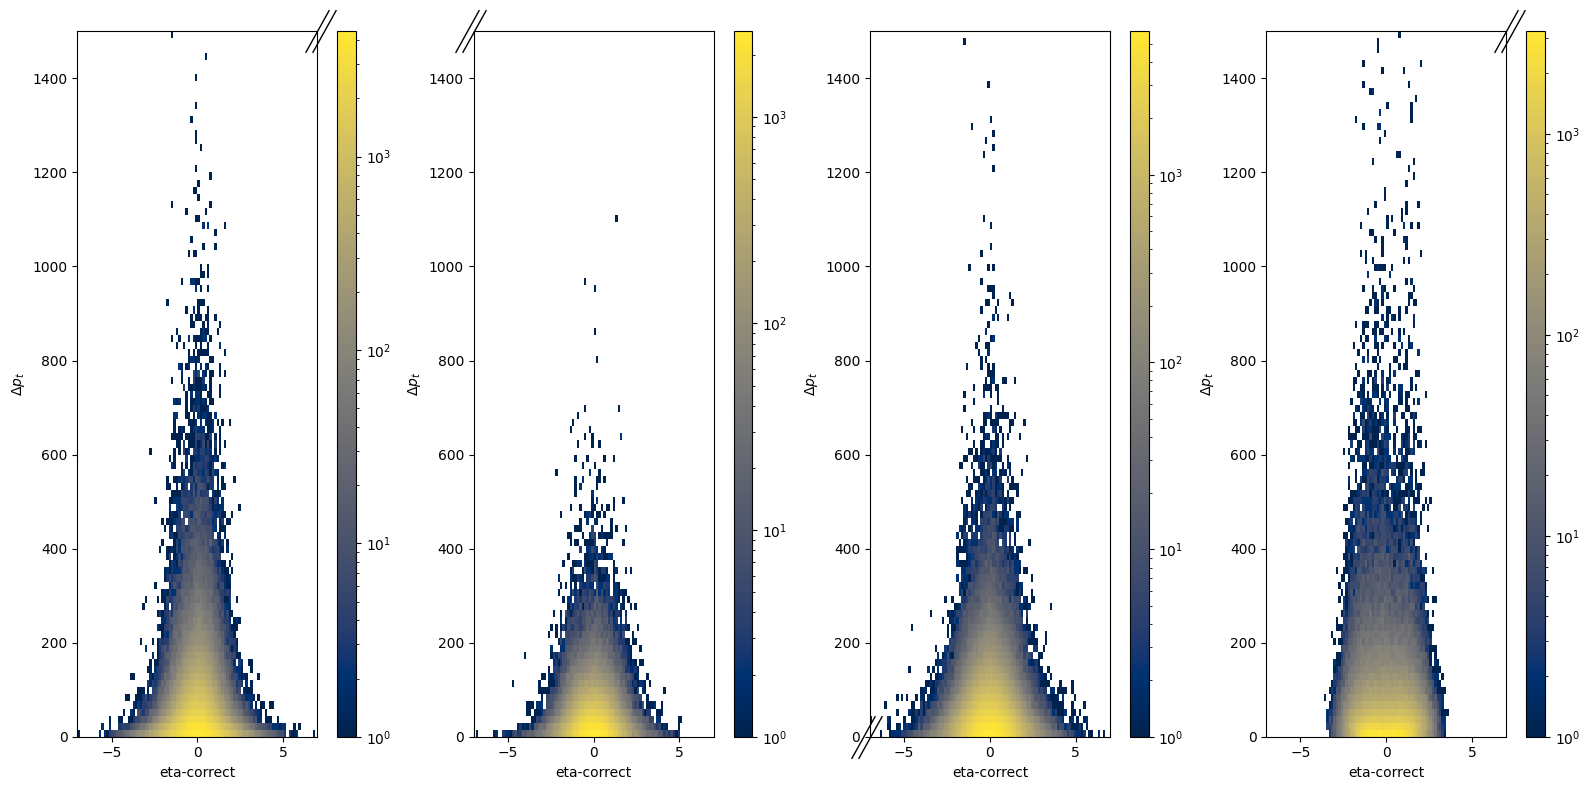

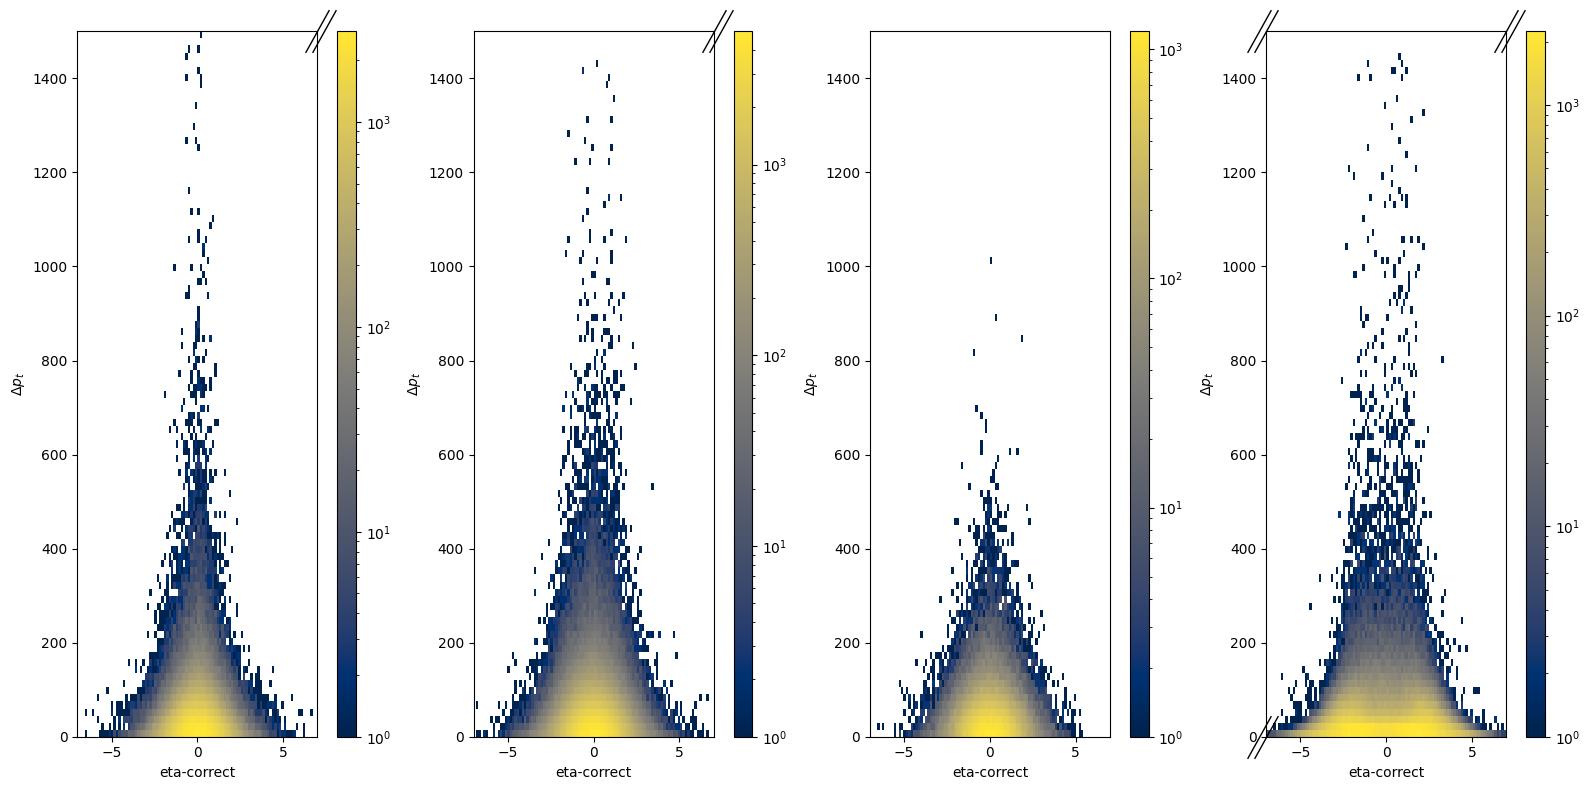

In [172]:
plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask, log=True)

plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
        ISR_mask = np.logical_not(ISR_mask), log=True)

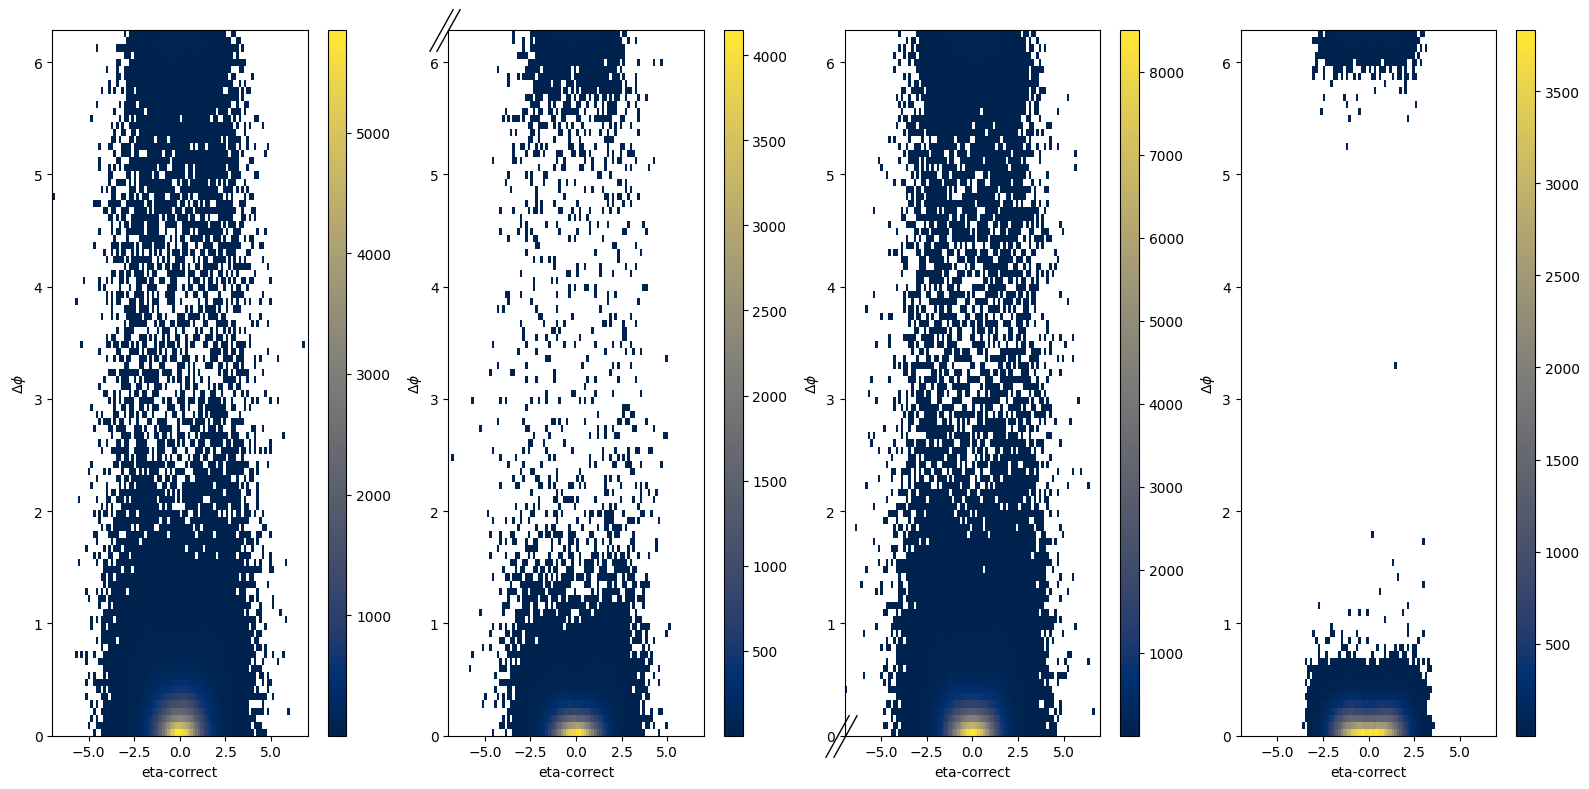

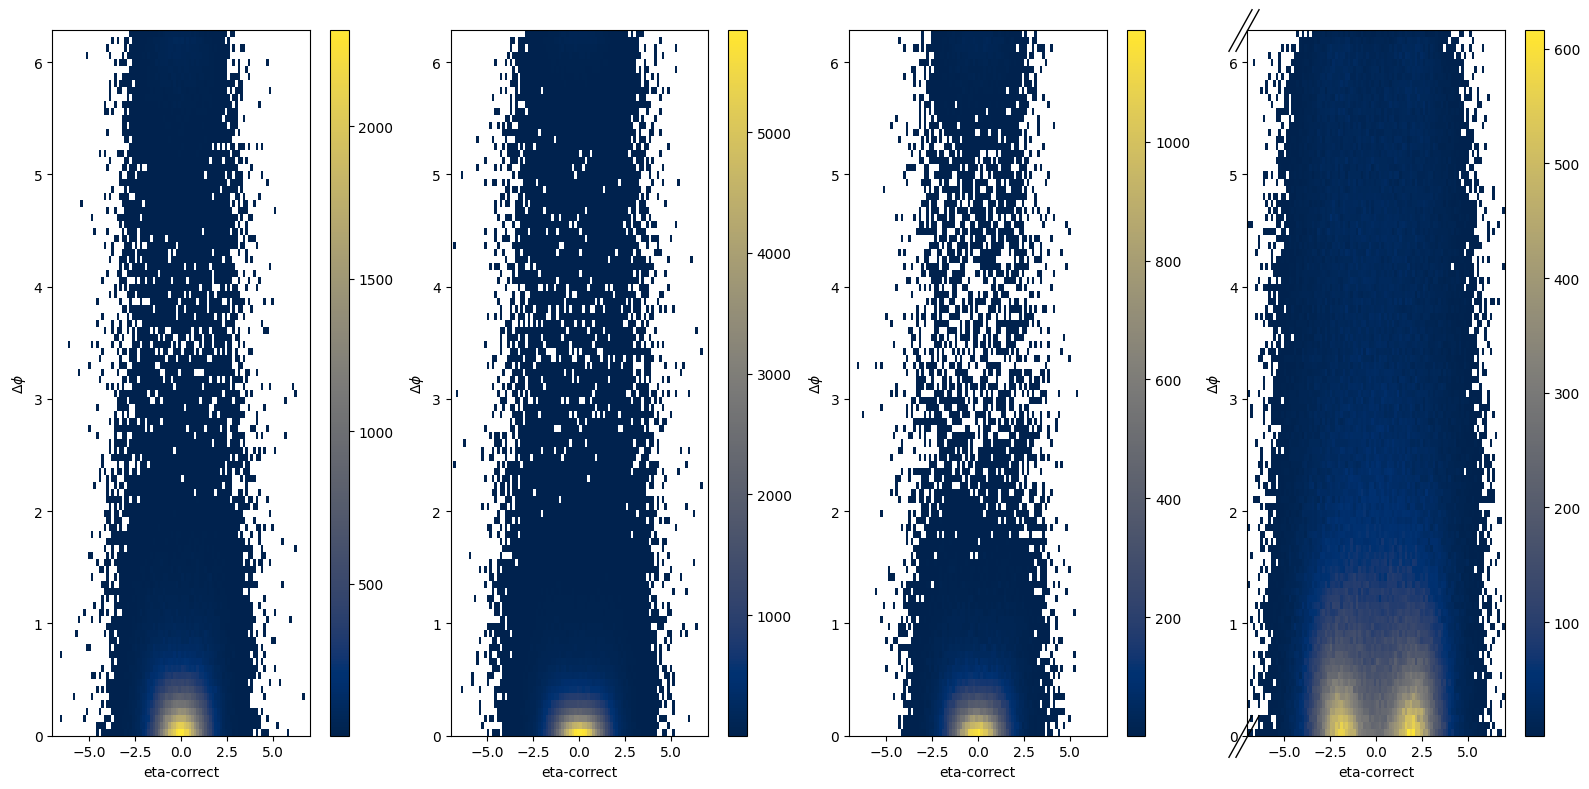

In [173]:
plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask)

plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
        ISR_mask = np.logical_not(ISR_mask))

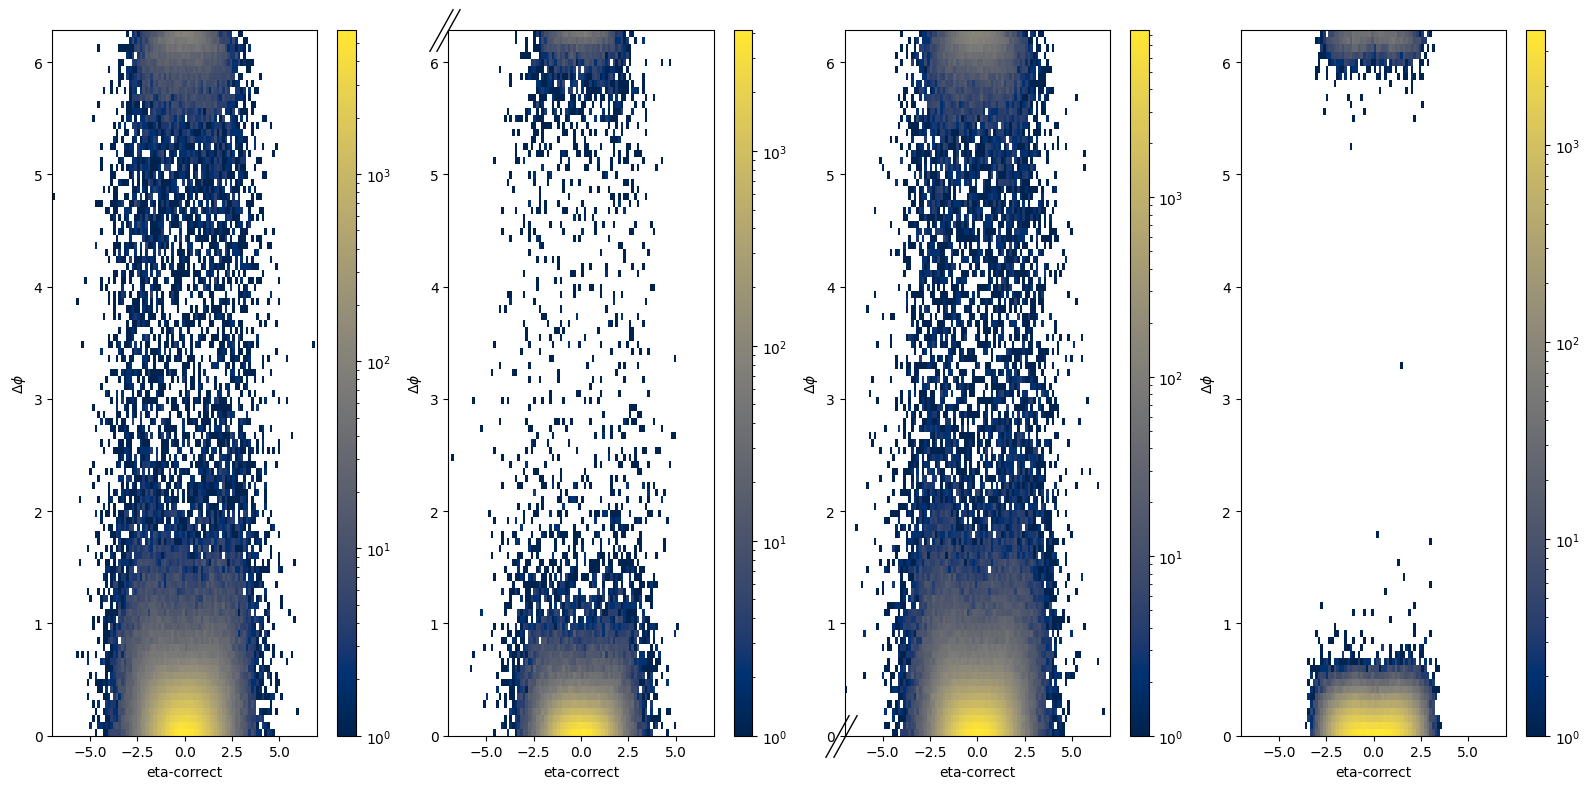

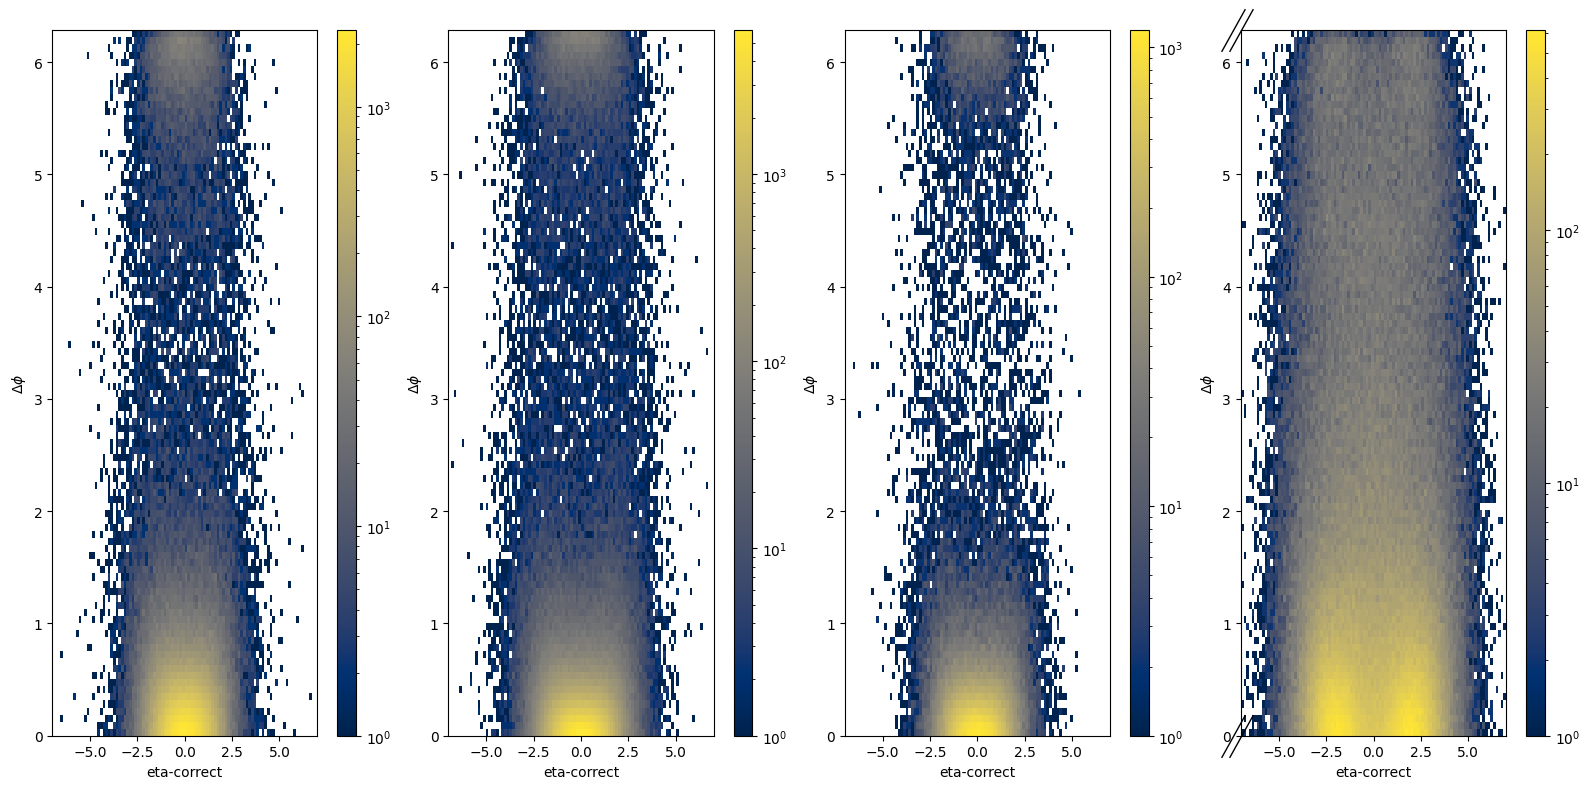

In [174]:
plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask, log=True)

plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
        ISR_mask = np.logical_not(ISR_mask), log=True)

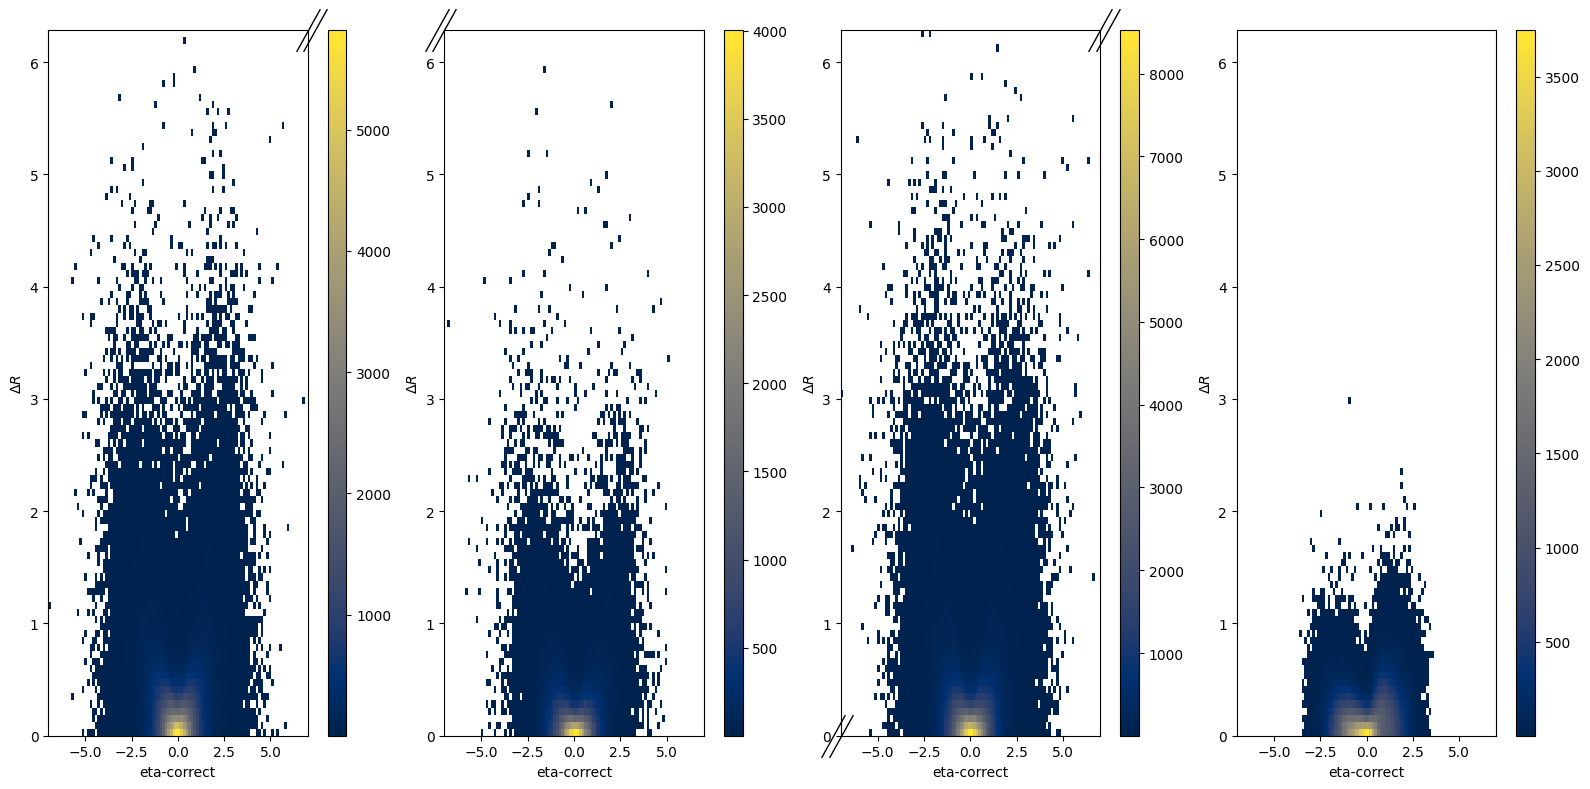

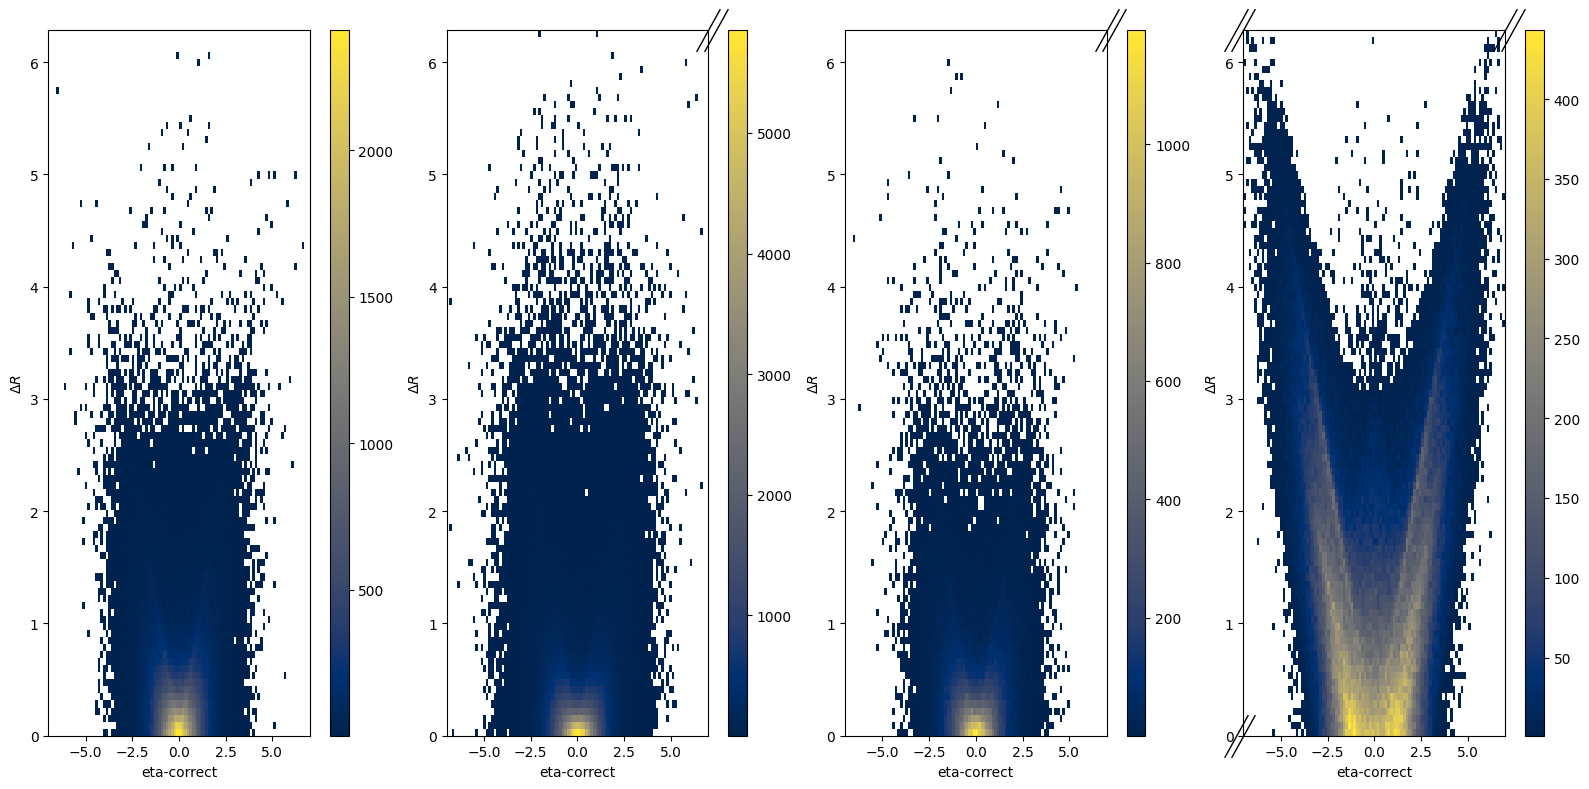

In [175]:
plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask)

plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
        ISR_mask = np.logical_not(ISR_mask))

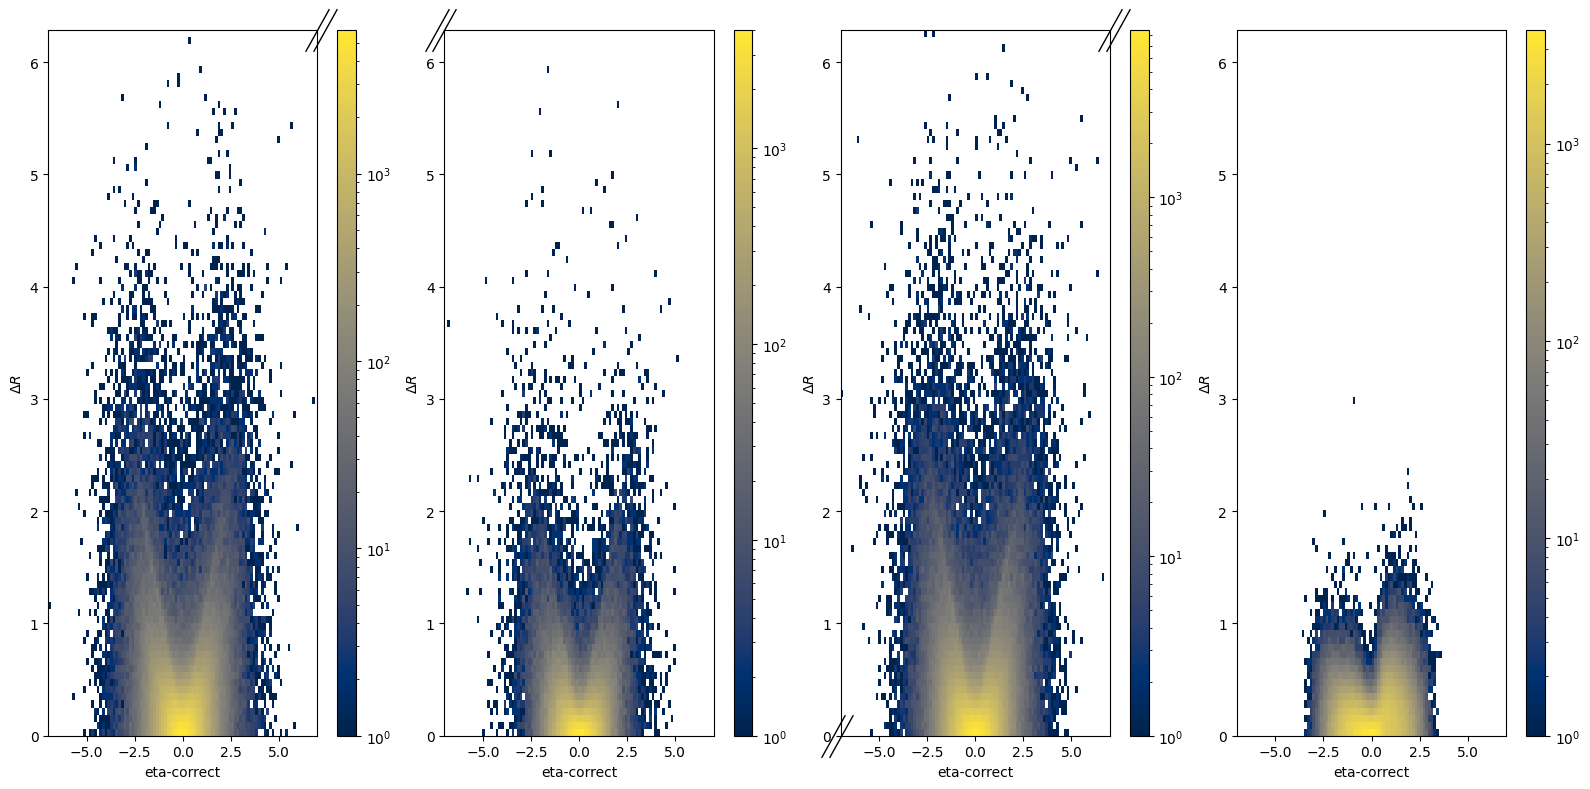

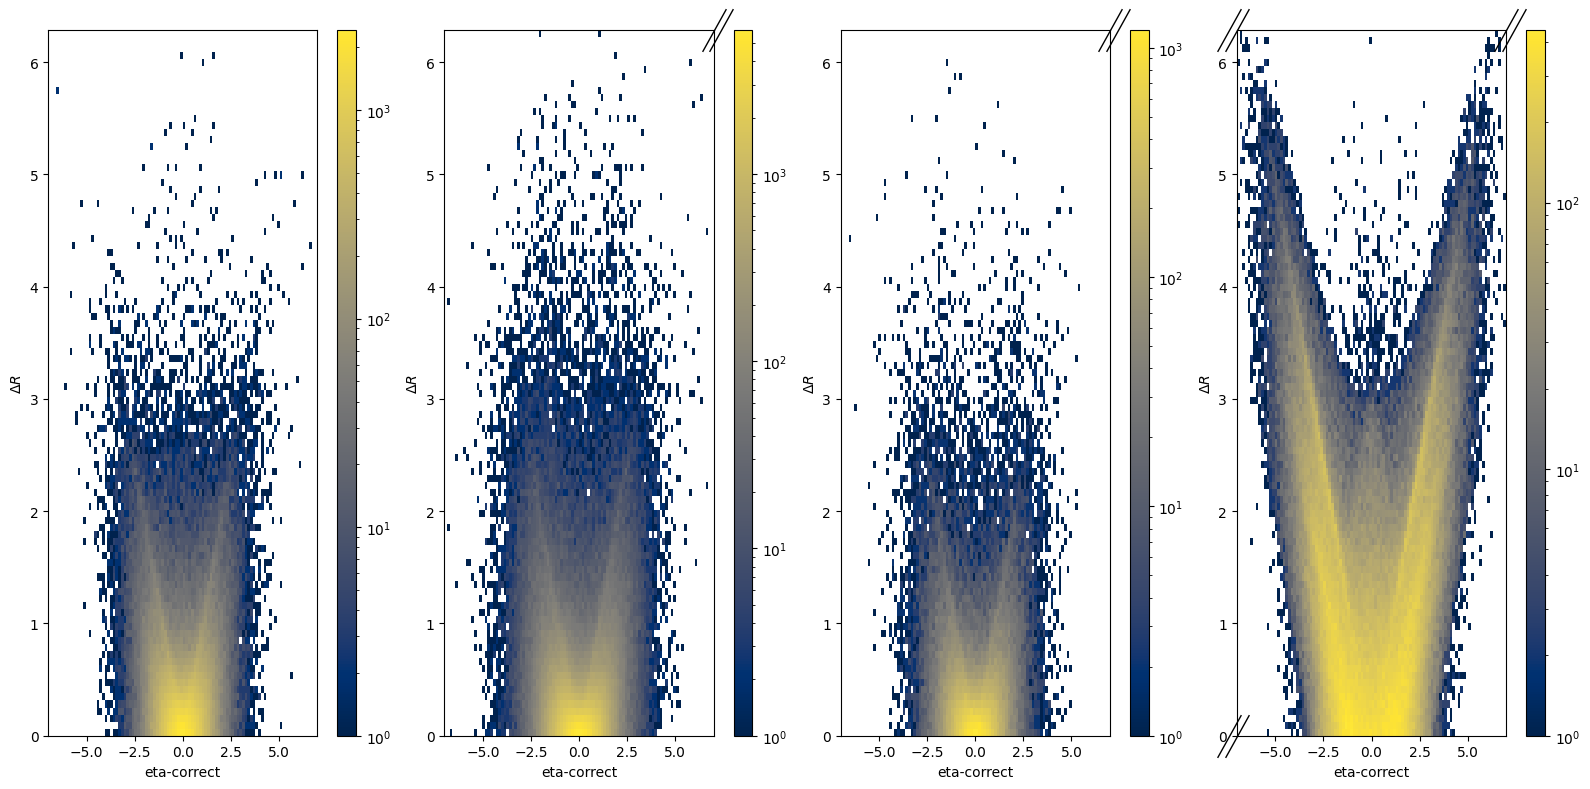

In [176]:
plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask, ISR_mask = ISR_mask, log=True)

plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep, glISRCorrect, glISR,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask),
        ISR_mask = np.logical_not(ISR_mask), log=True)

# New plots

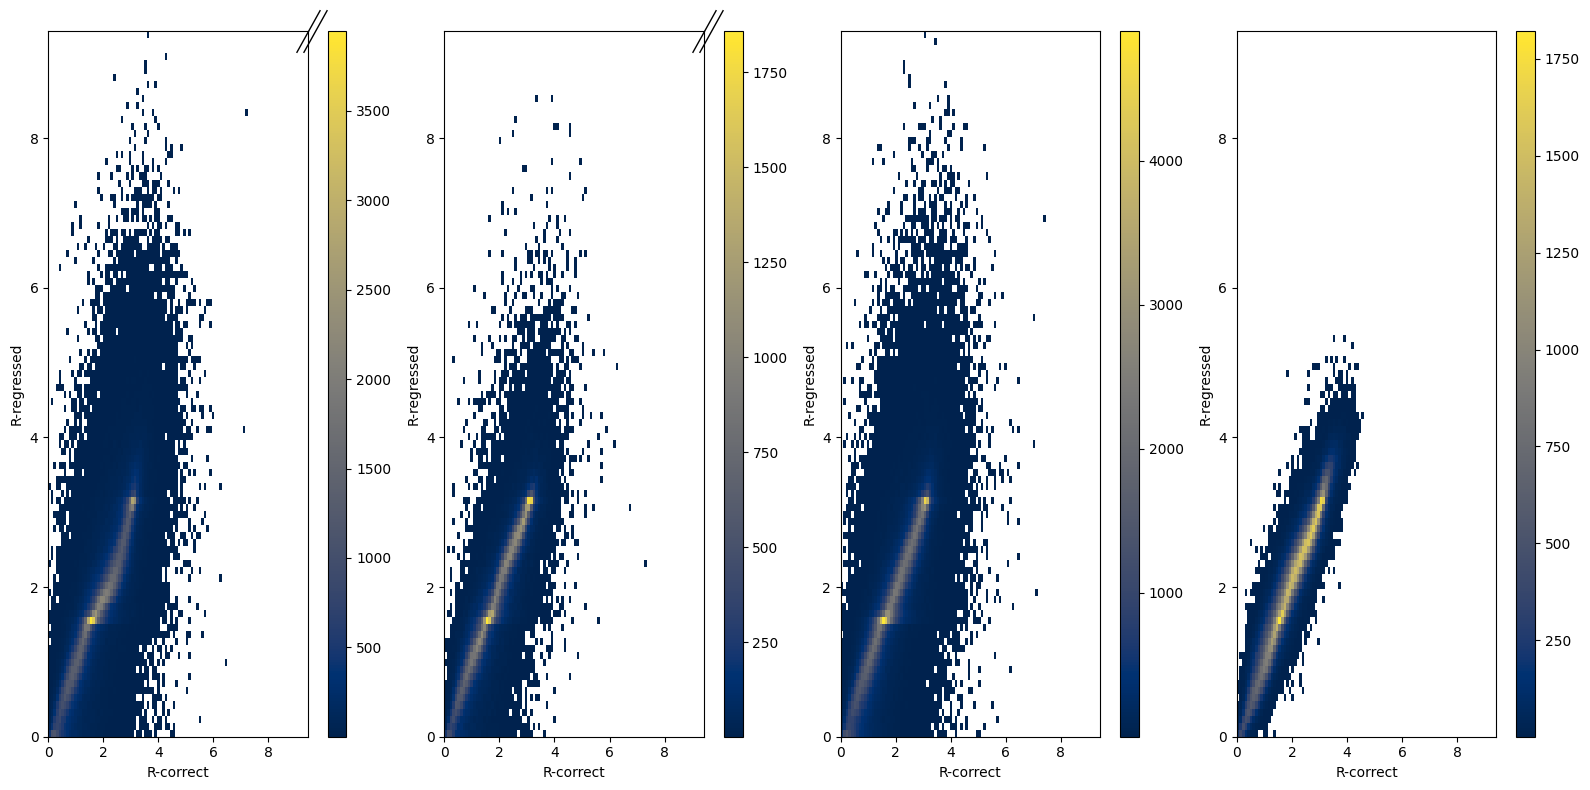

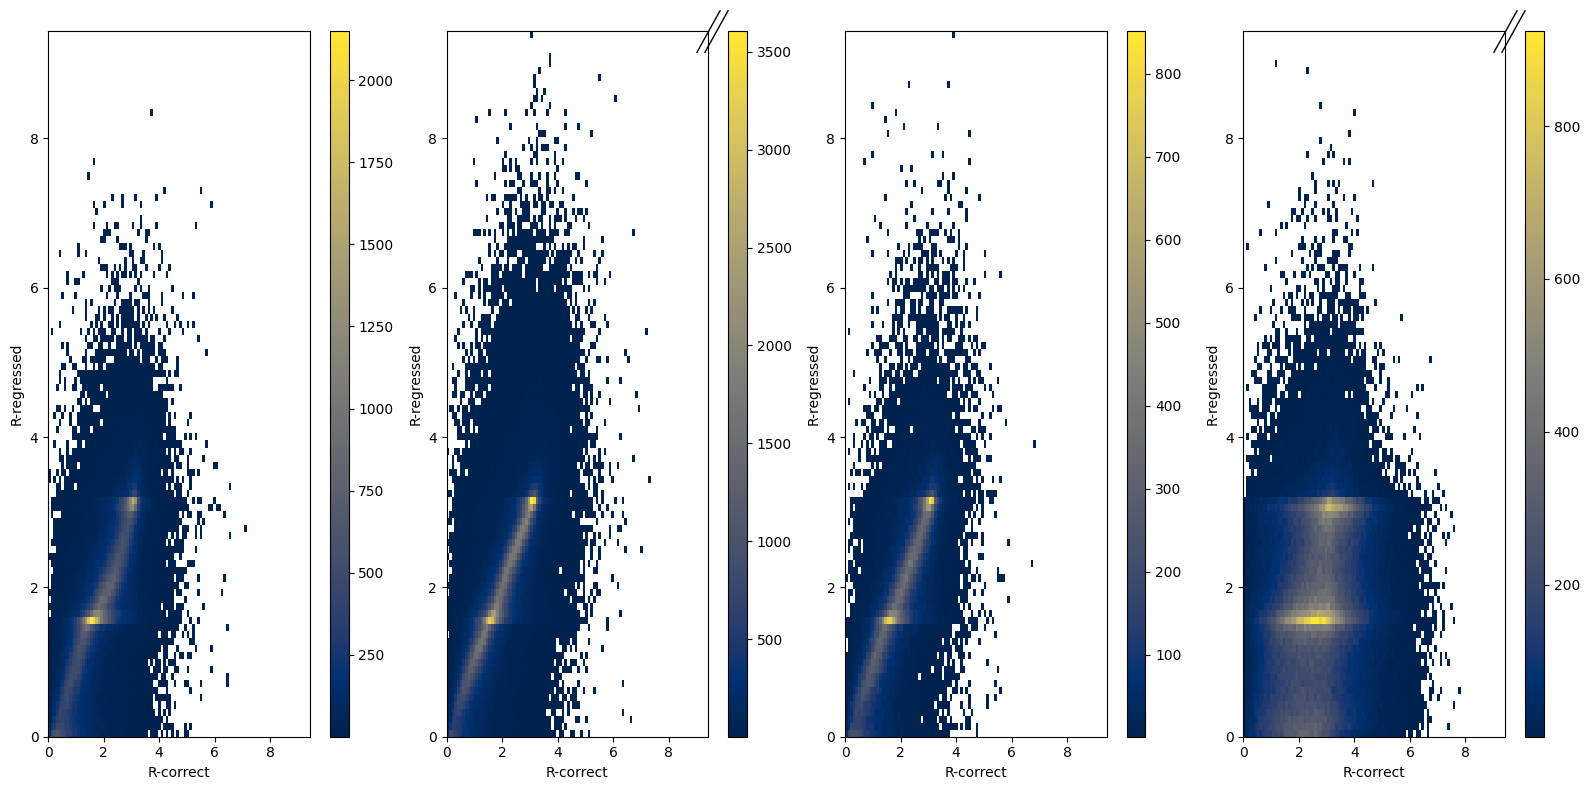

In [177]:
higgsCorr_R = np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2)
higgs_R = np.sqrt(higgs.phi**2 + higgs.eta**2)

thadCorr_R = np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2)
thad_R = np.sqrt(thad.phi**2 + thad.eta**2)

tlepCorr_R = np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2)
tlep_R = np.sqrt(tlep.phi**2 + tlep.eta**2)

glIRSRCorr_R = np.sqrt(glISRCorrect.phi**2 + glISRCorrect.eta**2)
glISR_R = np.sqrt(glISR.phi**2 + glISR.eta**2)


plot_var2d(higgs_var1=higgsCorr_R, higgs_var2=higgs_R, thad_var1=thadCorr_R, thad_var2=thad_R,
           tlep_var1=tlepCorr_R, tlep_var2=tlep_R, ISR_var1=glIRSRCorr_R, ISR_var2=glISR_R,
           name1='R-correct', name2='R-regressed',
           start1=0, stop1=3*pi, start2=0, stop2=3*pi,
            bins1=100, bins2=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var2d(higgs_var1=higgsCorr_R, higgs_var2=higgs_R, thad_var1=thadCorr_R, thad_var2=thad_R,
           tlep_var1=tlepCorr_R, tlep_var2=tlep_R, ISR_var1=glIRSRCorr_R, ISR_var2=glISR_R,
           name1='R-correct', name2='R-regressed',
           start1=0, stop1=3*pi, start2=0, stop2=3*pi,
            bins1=100, bins2=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

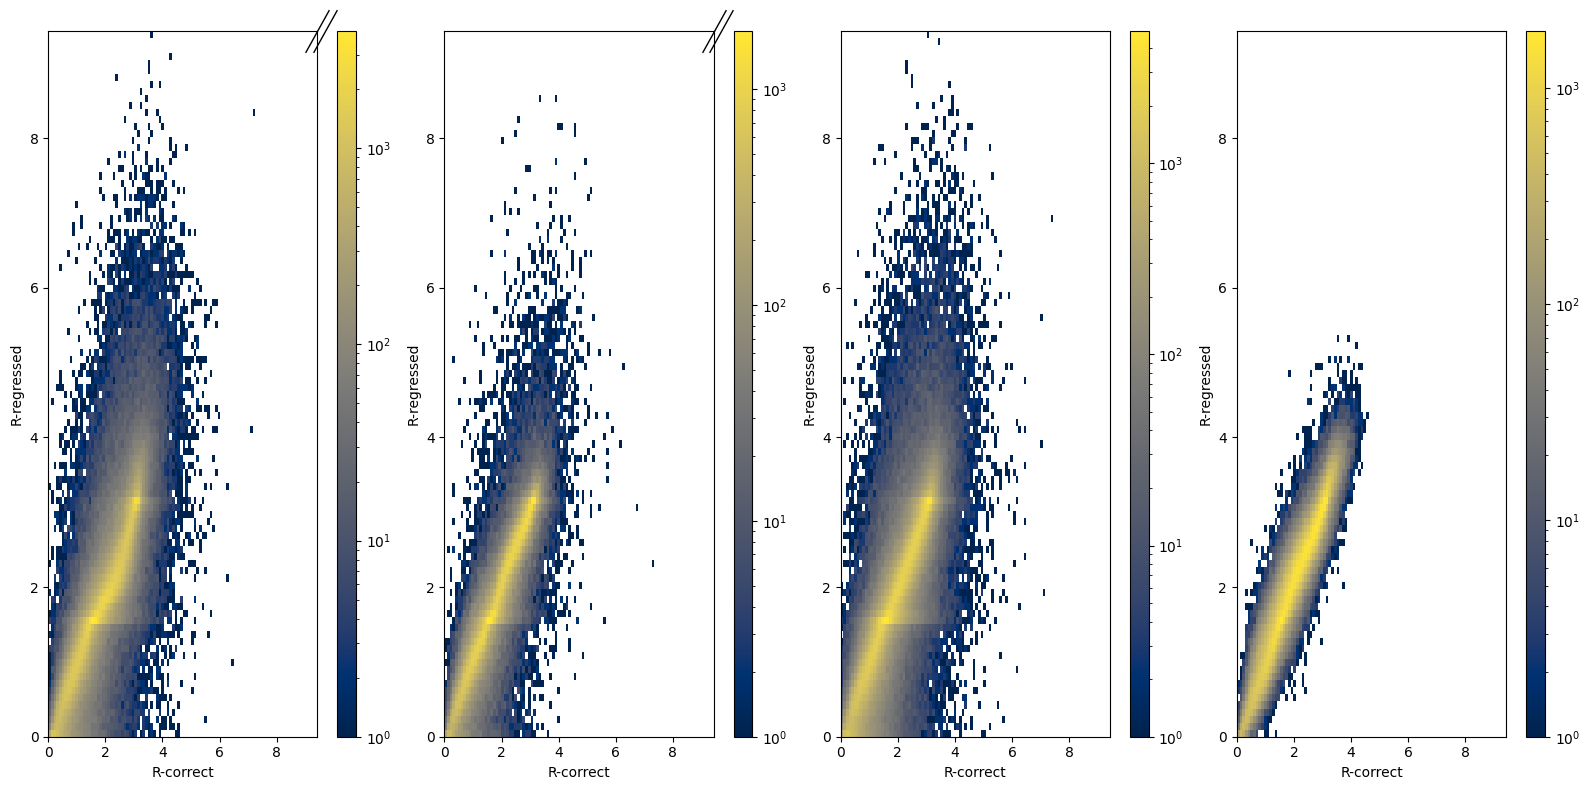

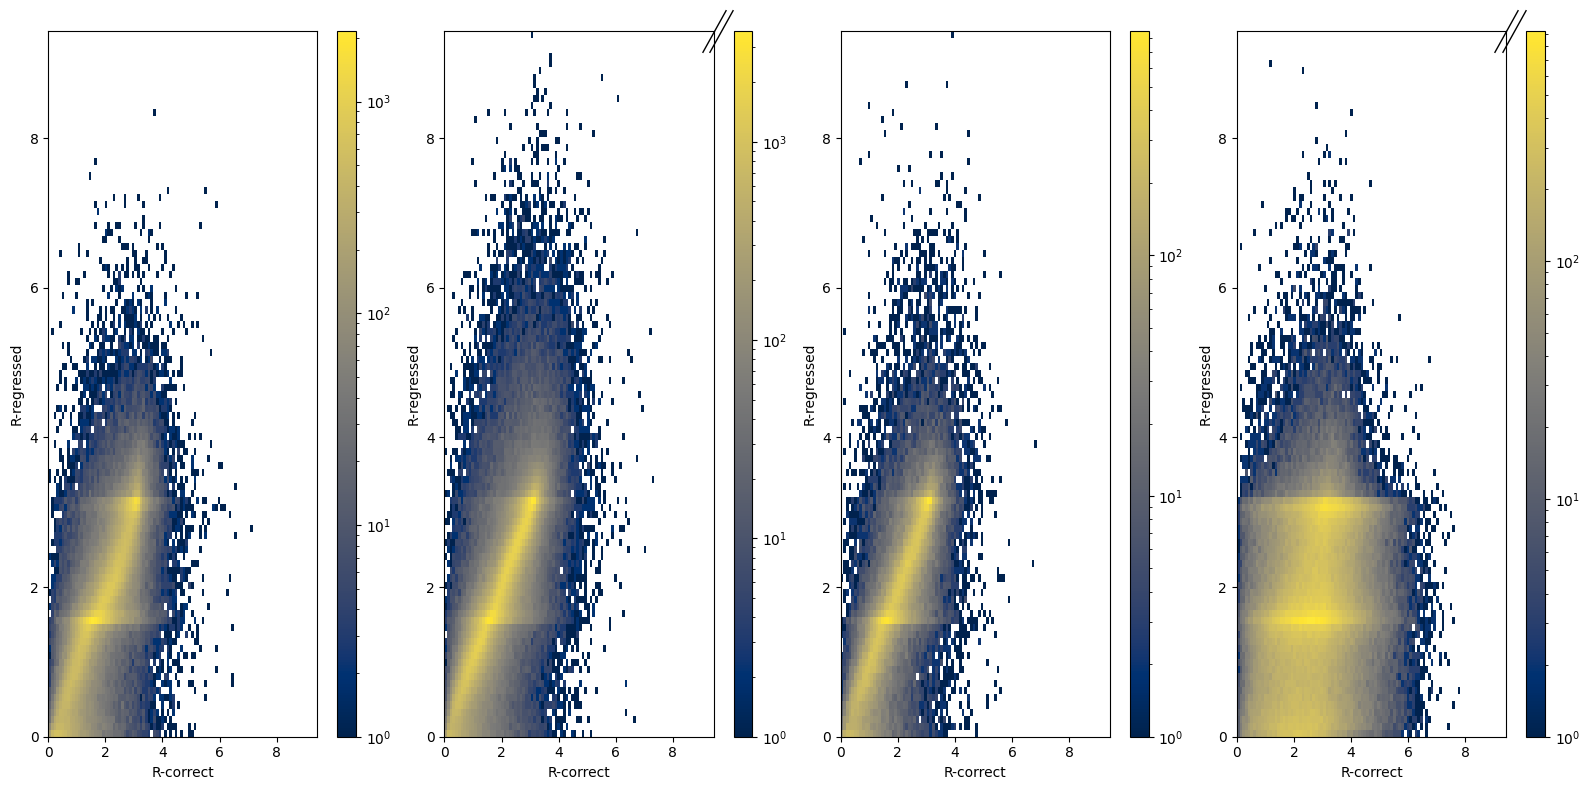

In [178]:
plot_var2d(higgs_var1=higgsCorr_R, higgs_var2=higgs_R, thad_var1=thadCorr_R, thad_var2=thad_R,
           tlep_var1=tlepCorr_R, tlep_var2=tlep_R, ISR_var1=glIRSRCorr_R, ISR_var2=glISR_R,
           name1='R-correct', name2='R-regressed',
           start1=0, stop1=3*pi, start2=0, stop2=3*pi,
            bins1=100, bins2=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=True)

plot_var2d(higgs_var1=higgsCorr_R, higgs_var2=higgs_R, thad_var1=thadCorr_R, thad_var2=thad_R,
           tlep_var1=tlepCorr_R, tlep_var2=tlep_R, ISR_var1=glIRSRCorr_R, ISR_var2=glISR_R,
           name1='R-correct', name2='R-regressed',
           start1=0, stop1=3*pi, start2=0, stop2=3*pi,
            bins1=100, bins2=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=True)

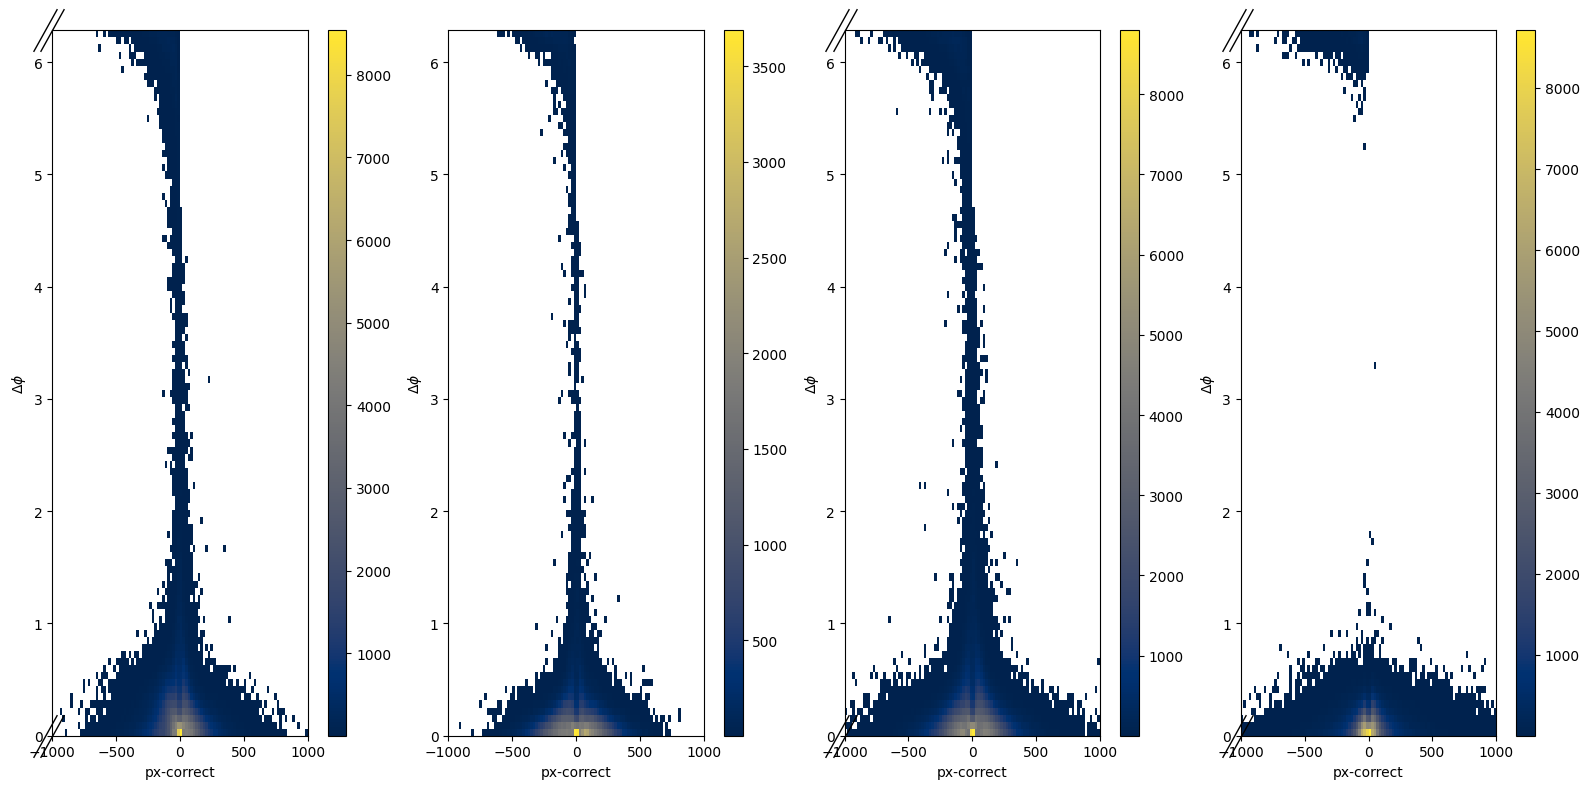

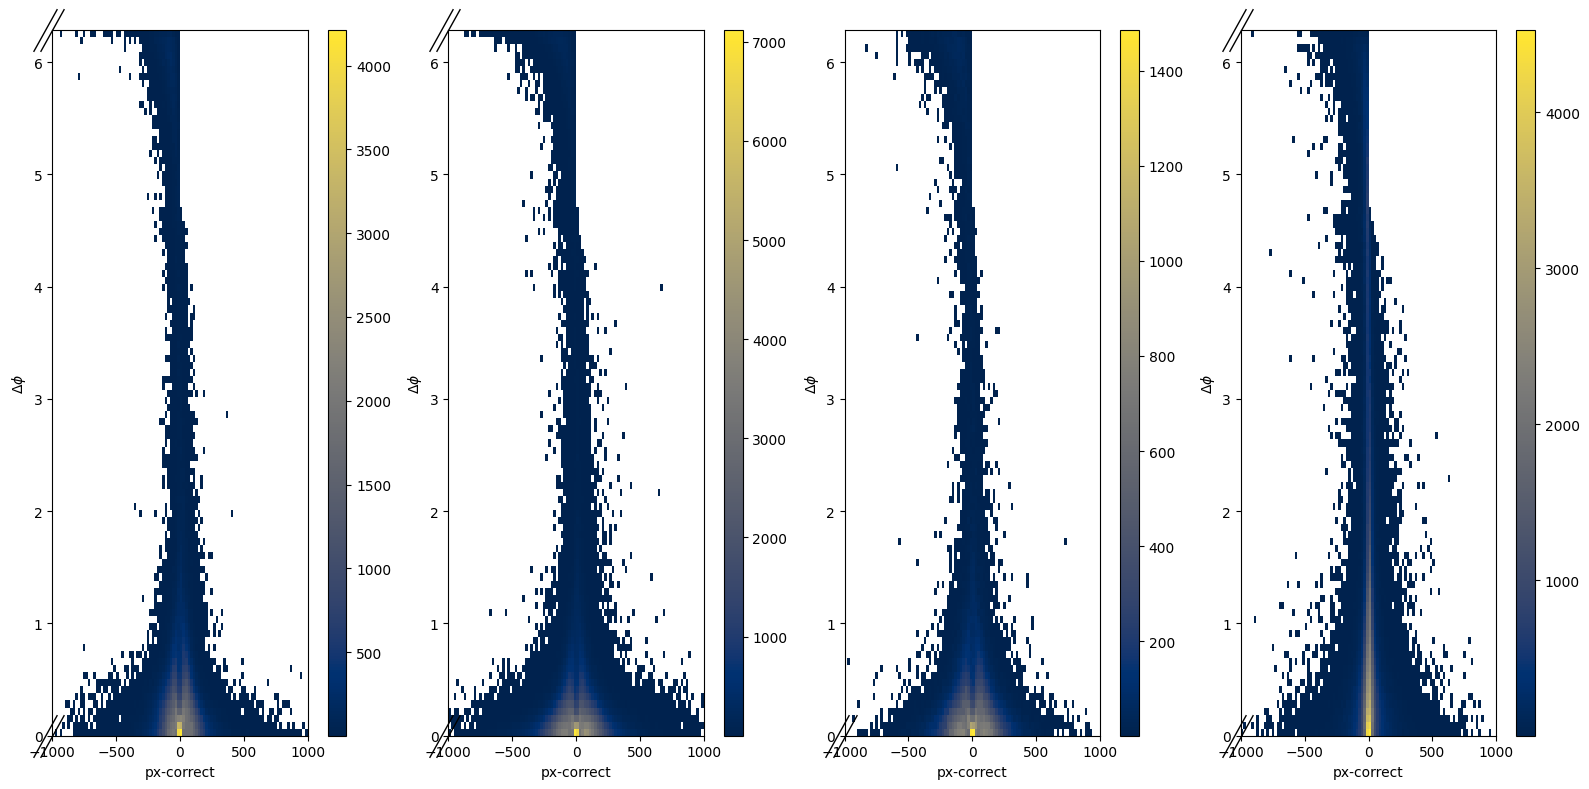

In [179]:
higgsCorr_px = higgsCorrect.px
higgs_DiffPhi = np.abs(higgs.phi - higgsCorrect.phi)

thadCorr_px = thadCorrect.px
thad_DiffPhi = np.abs(thad.phi - thadCorrect.phi)

tlepCorr_px = tlepCorrect.px
tlep_DiffPhi = np.abs(tlep.phi - tlepCorrect.phi)

glIRSRCorr_px = glISRCorrect.px
glISR_DiffPhi = np.abs(glISR.phi - glISRCorrect.phi)


plot_var2d(higgs_var1=higgsCorr_px, higgs_var2=higgs_DiffPhi, thad_var1=thadCorr_px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorr_px, tlep_var2=tlep_DiffPhi, ISR_var1=glIRSRCorr_px, ISR_var2=glISR_DiffPhi,
           name1='px-correct', name2='$\Delta \phi$',
           start1=-1000, stop1=1000, start2=0, stop2=2*pi,
            bins1=100, bins2=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var2d(higgs_var1=higgsCorr_px, higgs_var2=higgs_DiffPhi, thad_var1=thadCorr_px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorr_px, tlep_var2=tlep_DiffPhi, ISR_var1=glIRSRCorr_px, ISR_var2=glISR_DiffPhi,
           name1='px-correct', name2='$\Delta \phi$',
           start1=-1000, stop1=1000, start2=0, stop2=2*pi,
            bins1=100, bins2=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

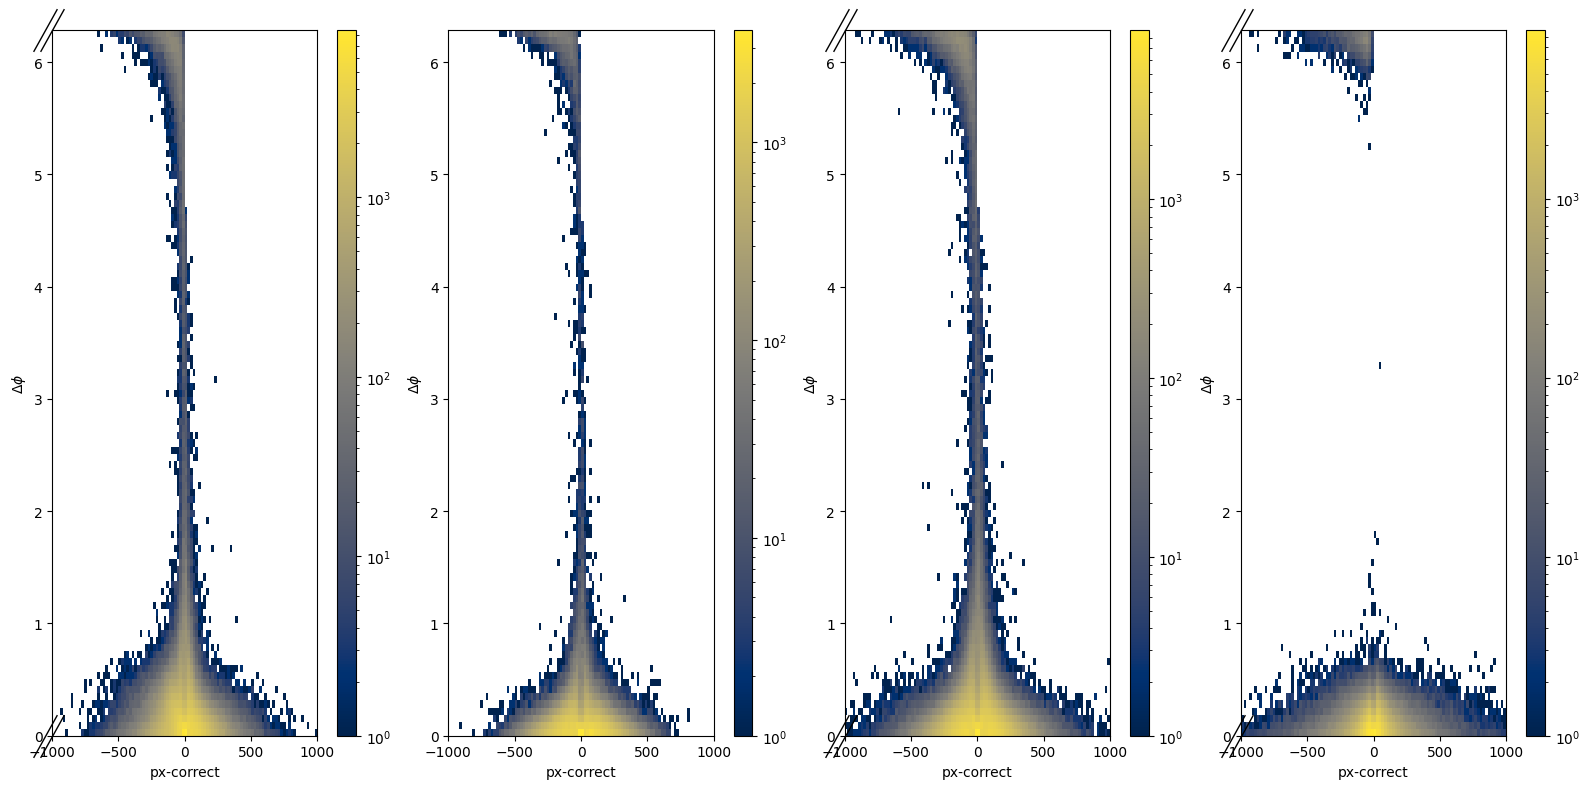

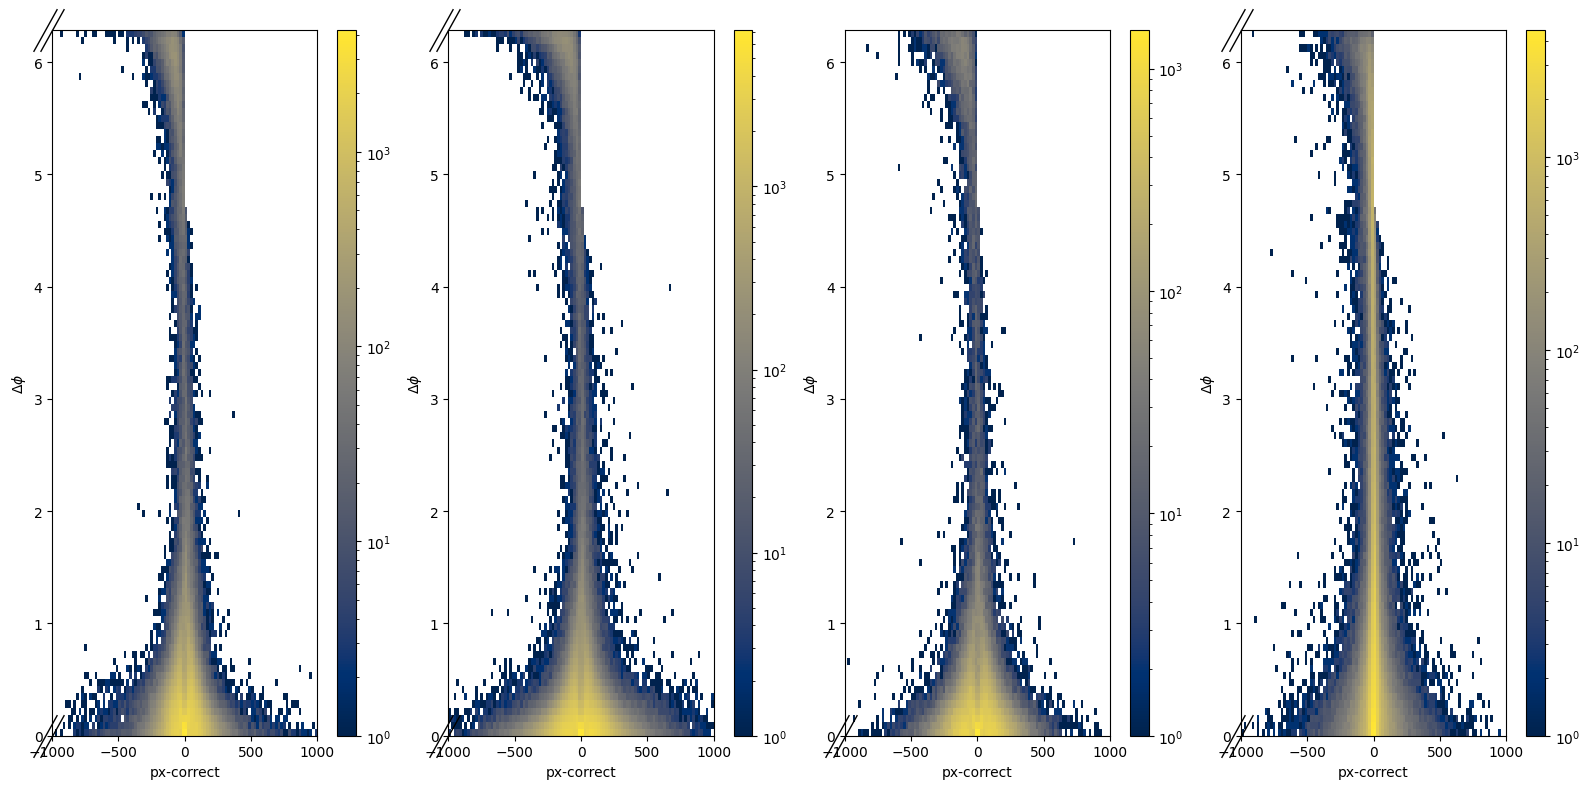

In [180]:
plot_var2d(higgs_var1=higgsCorr_px, higgs_var2=higgs_DiffPhi, thad_var1=thadCorr_px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorr_px, tlep_var2=tlep_DiffPhi, ISR_var1=glIRSRCorr_px, ISR_var2=glISR_DiffPhi,
           name1='px-correct', name2='$\Delta \phi$',
           start1=-1000, stop1=1000, start2=0, stop2=2*pi,
            bins1=100, bins2=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=True)

plot_var2d(higgs_var1=higgsCorr_px, higgs_var2=higgs_DiffPhi, thad_var1=thadCorr_px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorr_px, tlep_var2=tlep_DiffPhi, ISR_var1=glIRSRCorr_px, ISR_var2=glISR_DiffPhi,
           name1='px-correct', name2='$\Delta \phi$',
           start1=-1000, stop1=1000, start2=0, stop2=2*pi,
            bins1=100, bins2=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=True)

# Plot 1d

/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is insta

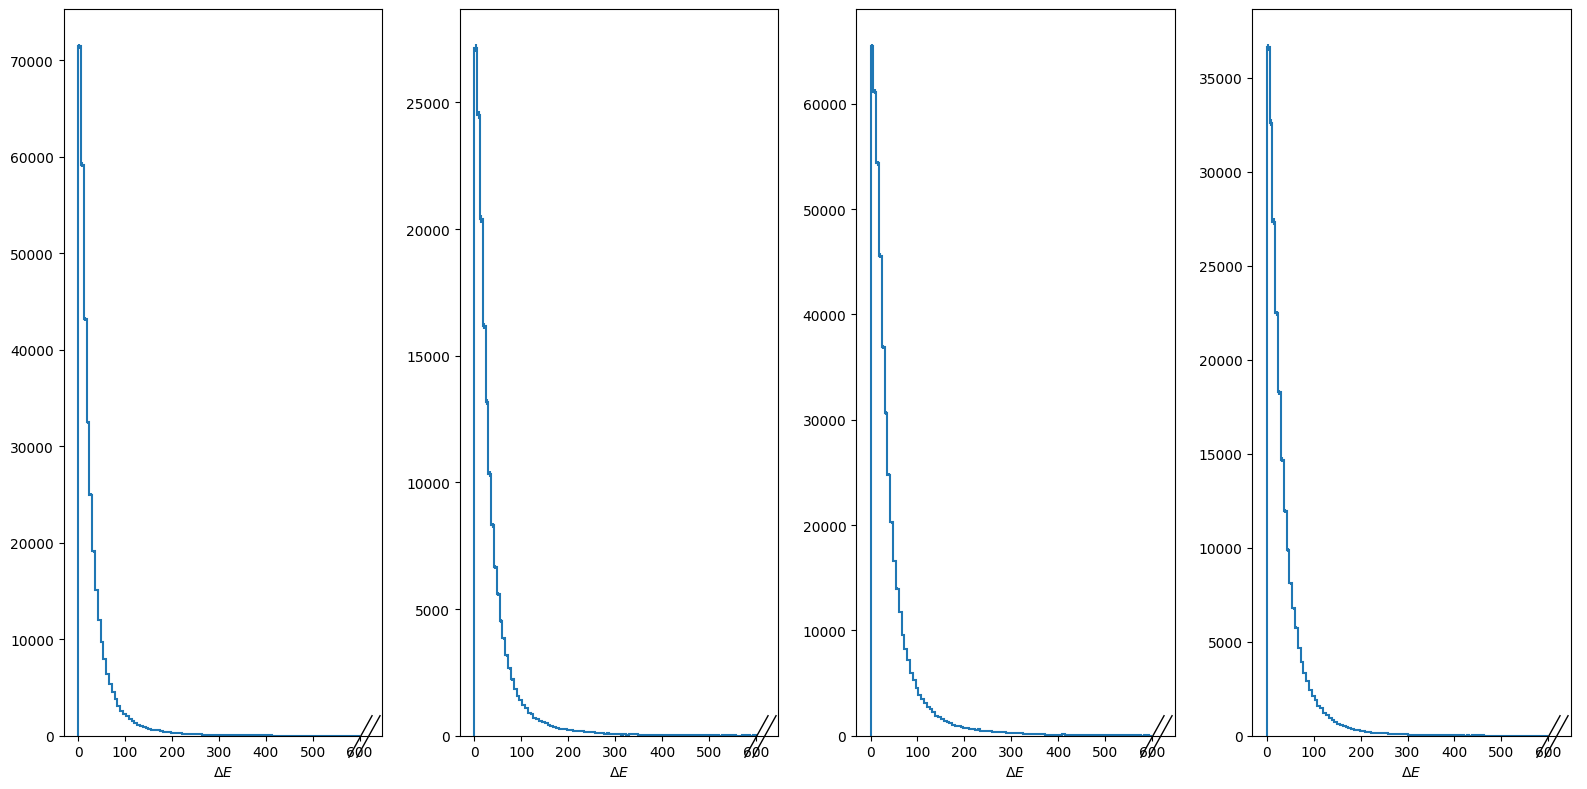

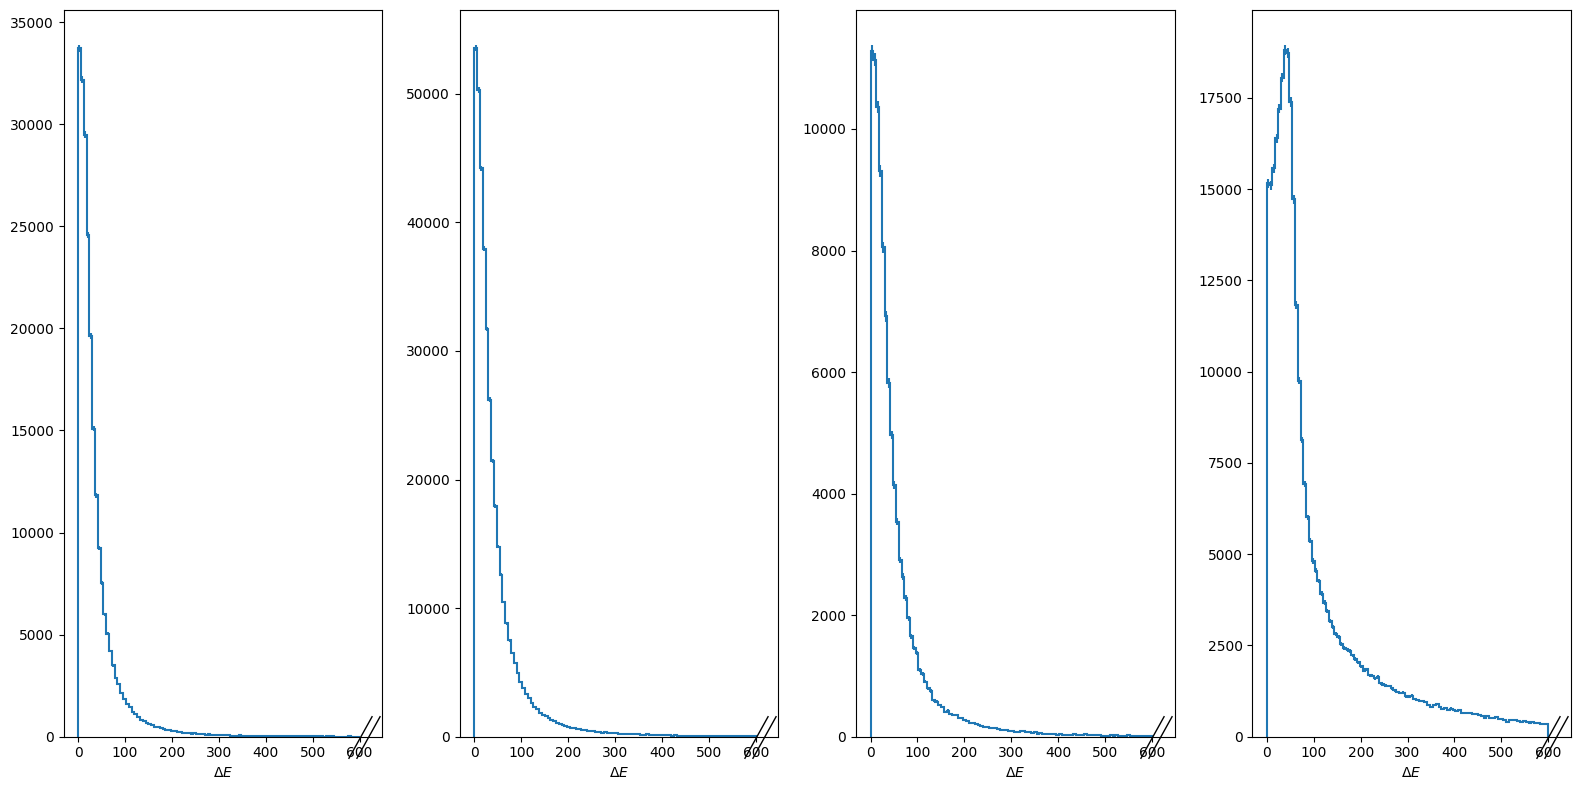

In [181]:
higgs_DiffE = np.abs(higgsCorrect.E - higgs.E)
thad_DiffE = np.abs(thadCorrect.E - thad.E)
tlep_DiffE = np.abs(tlepCorrect.E - tlep.E)
glISR_DiffE = np.abs(glISRCorrect.E - glISR.E)

plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE, tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
           name1='$\Delta E$', start1=0, stop1=600, bins1=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE, tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
           name1='$\Delta E$', start1=0, stop1=600, bins1=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

In [ ]:
higgs_DiffE = higgs_prov.E - higgs_Noprov.E
thad_DiffE = thad_prov.E - thad_Noprov.E
tlep_DiffE = tlep_prov.E - tlep_Noprov.E
glISR_DiffE = glISR_prov.E - glISR_Noprov.E


plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE, tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
           name1='$\Delta E$', start1=0, stop1=300, bins1=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE, tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
           name1='$\Delta E$', start1=0, stop1=300, bins1=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is insta

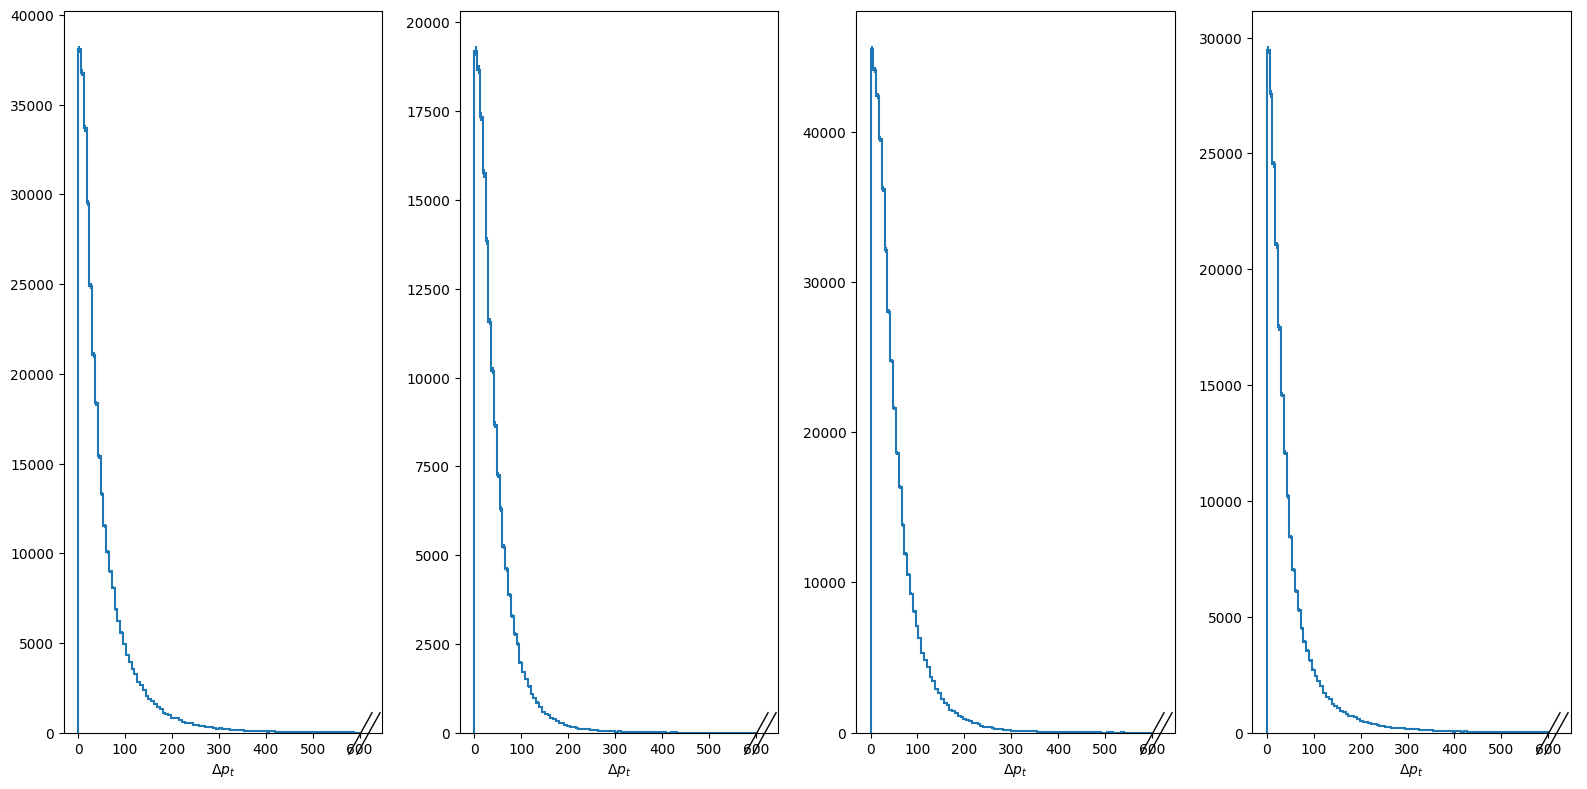

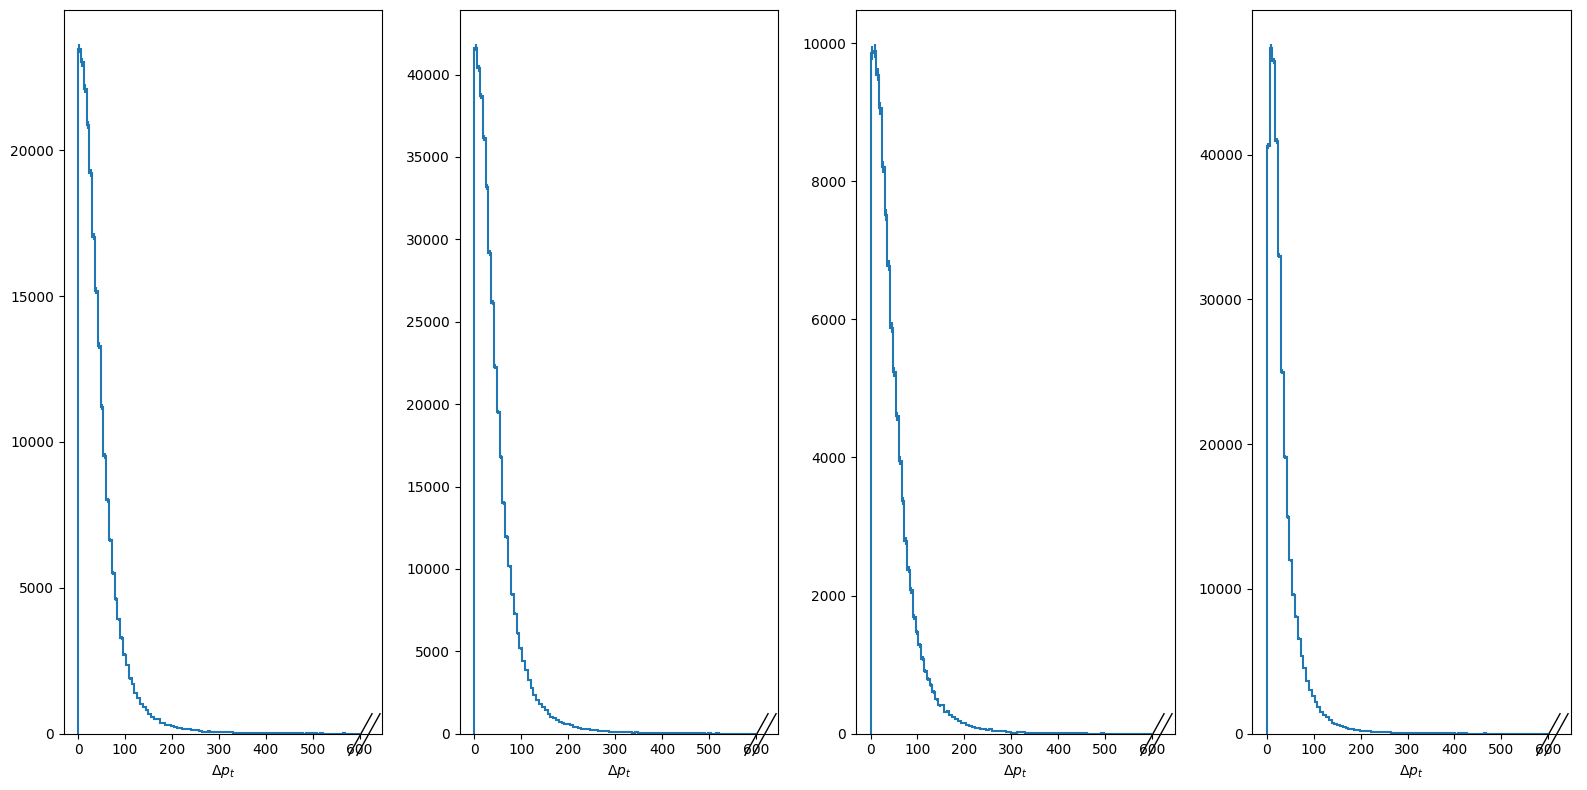

In [182]:
higgs_DiffPt = np.abs(higgsCorrect.pt - higgs.pt)
thad_DiffPt = np.abs(thadCorrect.pt - thad.pt)
tlep_DiffPt = np.abs(tlepCorrect.pt - tlep.pt)
glISR_DiffPt = np.abs(glISRCorrect.pt - glISR.pt)

plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt, tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
           name1='$\Delta p_t$', start1=0, stop1=600, bins1=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt, tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
           name1='$\Delta p_t$', start1=0, stop1=600, bins1=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

In [ ]:
higgs_DiffPt = higgs_prov.pt - higgs_Noprov.pt
thad_DiffPt = thad_prov.pt - thad_Noprov.pt
tlep_DiffPt = tlep_prov.pt - tlep_Noprov.pt
glISR_DiffPt = glISR_prov.pt - glISR_Noprov.pt


plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt, tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
           name1='$\Delta p_t$', start1=0, stop1=300, bins1=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt, tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
           name1='$\Delta p_t$', start1=0, stop1=300, bins1=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is insta

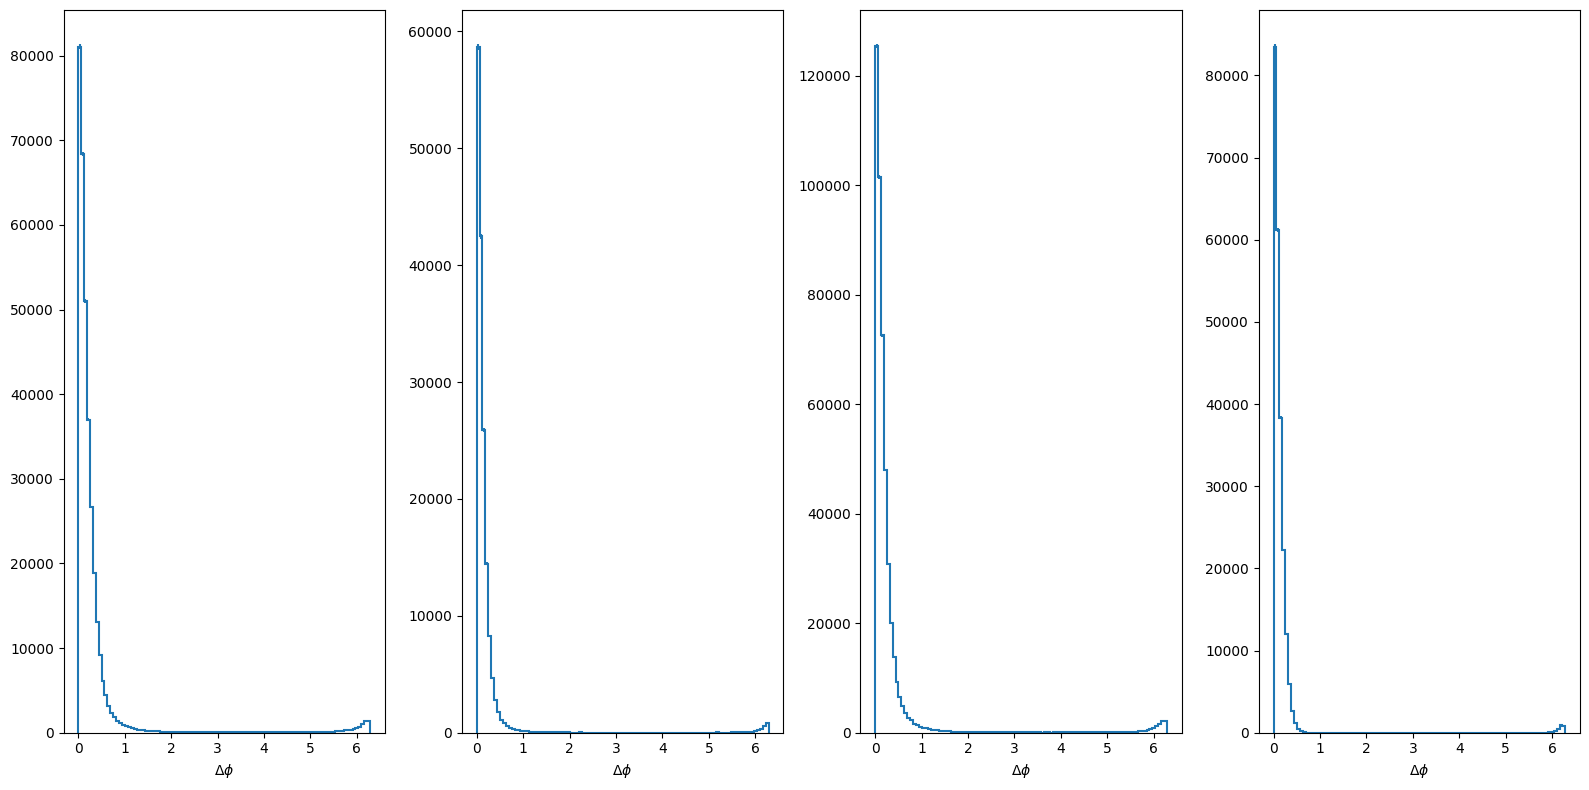

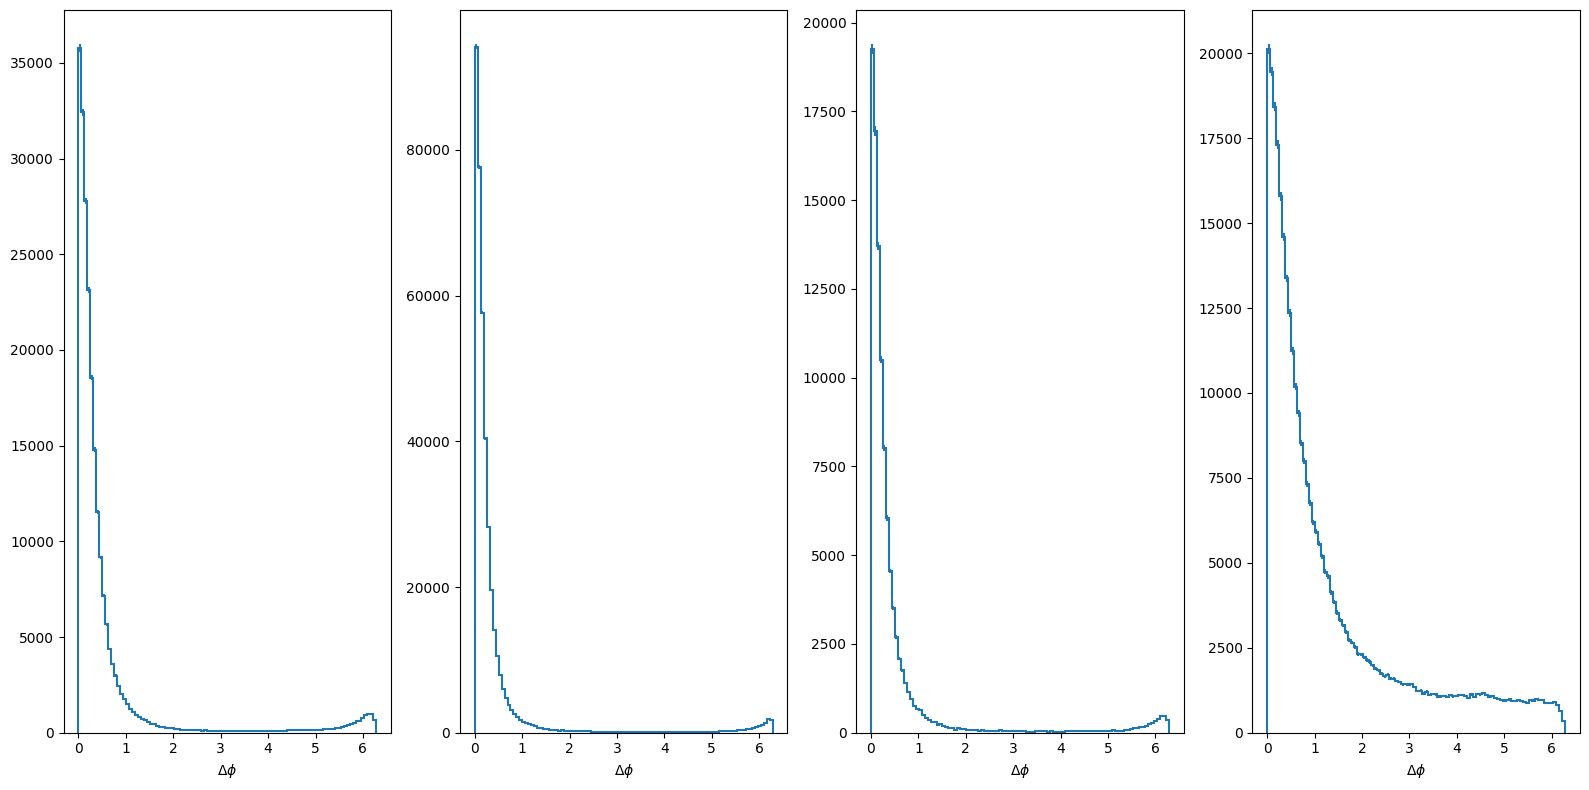

In [183]:
higgs_DiffPhi = np.abs(higgsCorrect.phi - higgs.phi)
thad_DiffPhi = np.abs(thadCorrect.phi - thad.phi)
tlep_DiffPhi = np.abs(tlepCorrect.phi - tlep.phi)
glISR_DiffPhi = np.abs(glISRCorrect.phi - glISR.phi)

plot_var1d(higgs_var1=higgs_DiffPhi, thad_var1=thad_DiffPhi, tlep_var1=tlep_DiffPhi, ISR_var1=glISR_DiffPhi,
           name1='$\Delta \phi$', start1=0, stop1=2*pi, bins1=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var1d(higgs_var1=higgs_DiffPhi, thad_var1=thad_DiffPhi, tlep_var1=tlep_DiffPhi, ISR_var1=glISR_DiffPhi,
           name1='$\Delta \phi$', start1=0, stop1=2*pi, bins1=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is insta

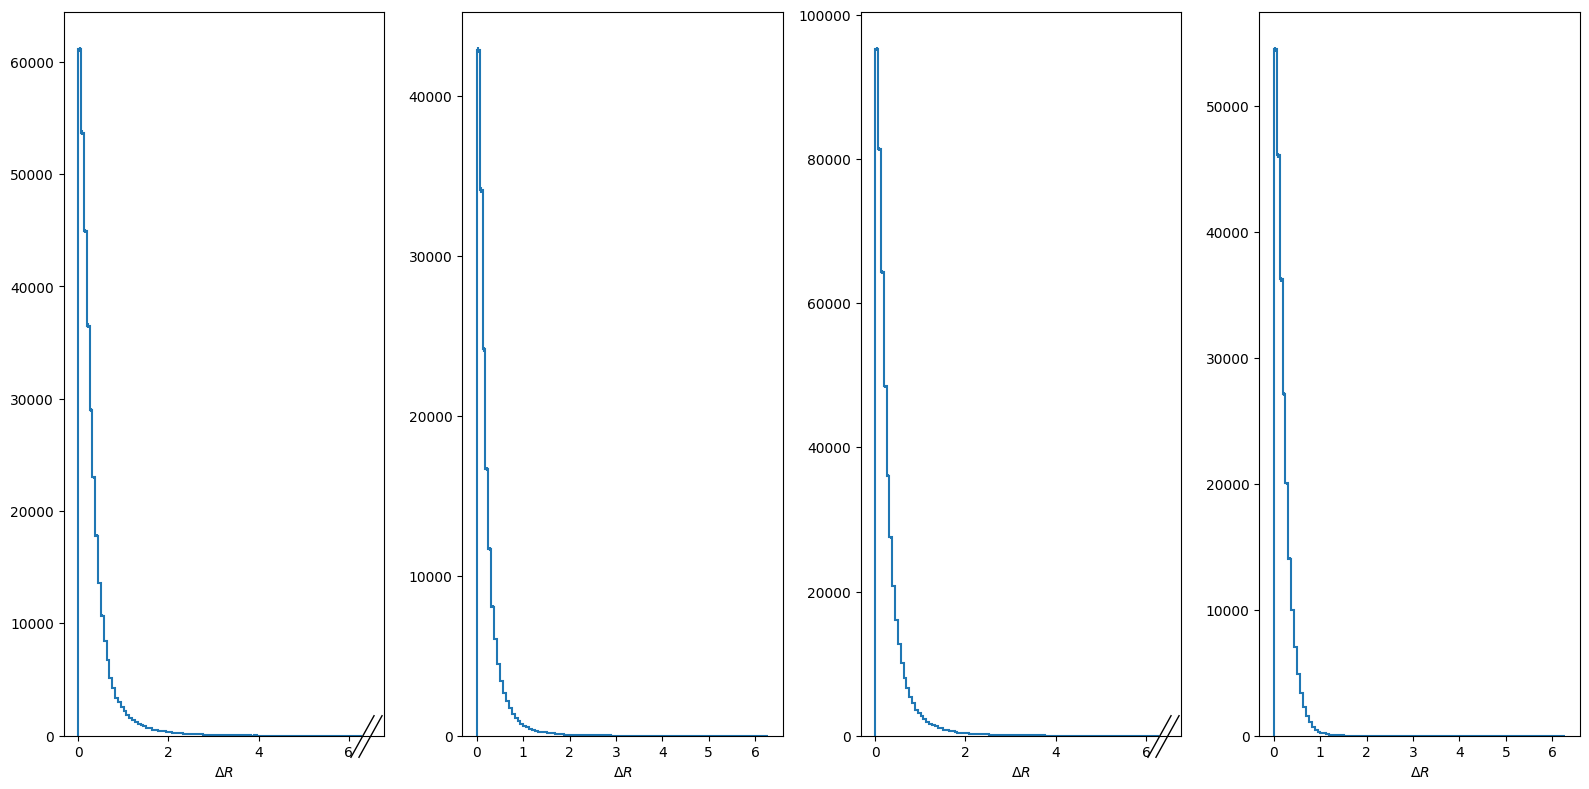

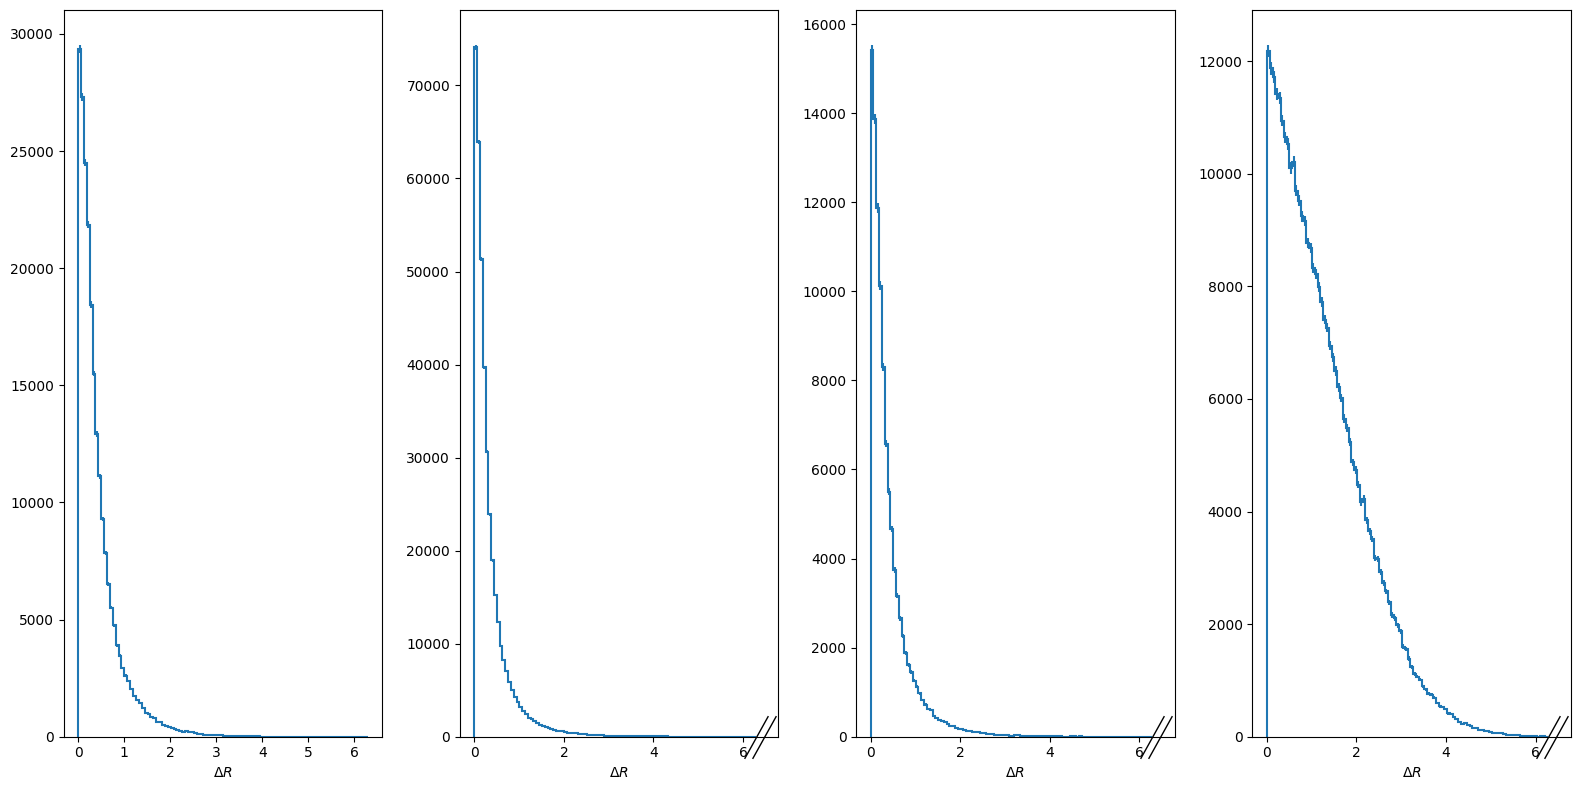

In [184]:
higgs_DiffR = np.abs(np.sqrt(higgs.phi**2 + higgs.eta**2) -  np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2))
thad_DiffR = np.abs(np.sqrt(thad.phi**2 + thad.eta**2) -  np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2))
tlep_DiffR = np.abs(np.sqrt(tlep.phi**2 + tlep.eta**2) -  np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2))
glISR_DiffR = np.abs(np.sqrt(glISR.phi**2 + glISR.eta**2) -  np.sqrt(glISRCorrect.phi**2 + glISRCorrect.eta**2))

plot_var1d(higgs_var1=higgs_DiffR, thad_var1=thad_DiffR, tlep_var1=tlep_DiffR, ISR_var1=glISR_DiffR,
           name1='$\Delta R$', start1=0, stop1=2*pi, bins1=100,
            higgs_mask=higgs_mask, thad_mask=hadt_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask, log=False)

plot_var1d(higgs_var1=higgs_DiffR, thad_var1=thad_DiffR, tlep_var1=tlep_DiffR, ISR_var1=glISR_DiffR,
           name1='$\Delta R$', start1=0, stop1=2*pi, bins1=100,
            higgs_mask = np.logical_not(higgs_mask),
            thad_mask = np.logical_not(hadt_mask),
            tlep_mask = np.logical_not(tlep_mask),
            ISR_mask = np.logical_not(ISR_mask), log=False)

# Debug

In [ ]:
data_debug = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=[],
                        parton_list=['data_higgs_t_tbar_ISR',
                                    'data_higgs_t_tbar_ISR_cartesian',
                                     'log_data_higgs_t_tbar_ISR_cartesian',
                                     'logScaled_data_higgs_t_tbar_ISR_cartesian',
                                    'mean_log_data_higgs_t_tbar_ISR_cartesian',
                                    'std_log_data_higgs_t_tbar_ISR_cartesian'])
        

In [ ]:
data_debug.parton_data.std_log_data_higgs_t_tbar_ISR_cartesian

In [ ]:
data_debug.parton_data.mean_log_data_higgs_t_tbar_ISR_cartesian

In [ ]:
logP_Befnow = data_debug.parton_data.data_higgs_t_tbar_ISR_cartesian
noCart = data_debug.parton_data.data_higgs_t_tbar_ISR

logP_now = torch.sign(logP_Befnow)*torch.log(1+torch.abs(logP_Befnow))

print(logP_now.shape)

In [ ]:
logP = data_debug.parton_data.log_data_higgs_t_tbar_ISR_cartesian
print(logP.shape)

In [ ]:
particle = 3
feature = 0

print(logP_Befnow[:,particle,feature])
print(logP[:,particle,feature])
print(logP_now[:,particle,feature])

In [ ]:
for p in range(4):
    for i in range(4):
        print(f"[{p}, {i}]: {torch.sum(logP[:,p,i])}")

In [ ]:
particle = 0
feature = 0

print(logP_Befnow[:,particle,1])
print(noCart[:,particle,0])
print(torch.cos(noCart[:,particle,2]))

print(logP[:,particle,0])
print('')
print(unscaledTensor[:,particle,feature].detach())
print(data_regressed[:,particle,feature].detach())